# Experiments: TensorFlow Lite applications analysis for both with and without HTTP handling implementation

This notebook allows to run every experiments used to analyze the capabilities of the two implmentations of the TensorFlow Lite application, i.e. with and without HTTP handling capability.

In [1]:
# Imports
import os
import re
import sys
import ast
import time
import pathlib
import datetime
import itertools
import textwrap
import numpy as np
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Global variables

# Paths
global_res_dir = "./results"
assets_path="./assets"


In [3]:
# ssh and scp functions with arguements
ssh_with_args = "ssh -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no"
scp_with_args = "scp -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no"

In [121]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Experiment 1: Analysis of the execution time of each important part of the TensorFlow Lite application for classical setup

In [122]:
# Experiment setup
experiment_name = "Execution time by part"
timestamp = timestamp=datetime.datetime.now() # Current timestamp

iteration = 20
ssh_info = "pptc@192.168.88.3"
ssh_ip = "192.168.88.3"
implementations = ["label_image", "label_image_with_crow"]
mediums = ["WiFi 2.4GHz 20-40MHz", "WiFi 5.0GHz 20-40-80MHz", "Ethernet"]
count_for_usage_script = 30 # correspond to the number of measure taken (1 per second)

### Perform experiment

In [114]:
# Experiment path
exp_folder_name = experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_folder_name = experiment_name.replace(' ', '_') + "_Final"
curr_exp_dir = global_res_dir + "/" + exp_folder_name

# Remote path
remote_exp_results_dir = "~/" + exp_folder_name + "/results"
remote_exp_cpu_usage_dir = remote_exp_results_dir + "/cpu_usage"
remote_exp_ram_usage_dir = remote_exp_results_dir + "/ram_usage"
remote_exp_scripts_dir = "~/" + exp_folder_name + "/scripts"

# Copy scripts on remote device
!{ssh_with_args} {ssh_info} "mkdir -p ~/{exp_folder_name}"
!{scp_with_args} -r scripts/ {ssh_info}:~/{exp_folder_name}

# Perform the experiment
for imp in implementations:
    imp_mediums = ["na"] if imp == "label_image" else mediums

    # Copy needed assets (executable and images)
    print(f"Copy assets for {imp} on remote device")
    !{scp_with_args} -r {assets_path}/{imp} {ssh_info}:~/{exp_folder_name}/{imp}

    for med in imp_mediums:
        # Validate config:
        print(f"Prepare next config:\n\tImplementation: {imp}\n\tMedium: {med}\n\t\n")
        time.sleep(2)
        v = input("Press ENTER to run the benchmark")
        print(f"Value : {v}")
        if v == "s": # stop
            break
        print("Run benchmark...")

        # Create remote workspace
        !{ssh_with_args} {ssh_info} "mkdir -p {remote_exp_cpu_usage_dir}; mkdir -p {remote_exp_ram_usage_dir}"

        # Implementation paths
        curr_exp_imp_dir = curr_exp_dir + "/" + imp.replace(' ', '_')
        curr_exp_imp_med_dir = curr_exp_imp_dir + ("/" + med.replace(' ', '_') if med != "na" else "")
        curr_exp_imp_raw_dir = curr_exp_imp_med_dir + "/raw_results"
        curr_exp_imp_raw_file = curr_exp_imp_raw_dir + "/execution_time_by_part.txt"
        curr_exp_imp_res_dir = curr_exp_imp_med_dir + "/results"

        # Remote paths
        cpu_usage_remote_file = remote_exp_cpu_usage_dir + "/results_cpu_usage_" + imp + "_" + med.replace(' ', '_') + ".txt"
        ram_usage_remote_file = remote_exp_ram_usage_dir + "/results_ram_usage_" + imp + "_" + med.replace(' ', '_') + ".txt"

        # Create results dir
        path = Path(curr_exp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_raw_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Print experiment setup in results file
        # Local for execution time
        with open(curr_exp_imp_raw_file, "w") as raw:
            raw.write(f"# SSH_INFO={ssh_info}\n")
            raw.write(f"# ITERATIONS={iteration}\n")
            raw.write(f"# IMPLEMENTATION={imp}\n")
            raw.write(f"# MEDIUM={med}\n")

        # Remote for cpu and ram usage
        !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# COUNT={count_for_usage_script}\n\" > {cpu_usage_remote_file}"
        !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# COUNT={count_for_usage_script}\n\" > {ram_usage_remote_file}"

        # Perform test
        for i in range(iteration):
            # Print iteration
            print(f"Iteration {i}")
            with open(curr_exp_imp_raw_file, "a") as raw:
                raw.write(f"\n# ITERATION {i}\n")
            !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {cpu_usage_remote_file}"
            !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {ram_usage_remote_file}"

            # Run cpu and ram usage script
            print("Start CPU and RAM usage scripts")
            
            cpu_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/cpu_usage_script.sh {count_for_usage_script} {cpu_usage_remote_file} 0"', shell=True)
            ram_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/ram_usage_script.sh {count_for_usage_script} {ram_usage_remote_file} 0"', shell=True)

            print("Sleep 3s")
            time.sleep(3) # To have more usage measures

            
            print("Perform measure")
            if imp == "label_image":
                start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                !{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; (time ./{imp} -m mobilenet_v1_1.0_224.tflite -l labels.txt -i grace_hopper.bmp -t 1 -d 1 -w 0)" &>> {curr_exp_imp_raw_file}

                stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
            else:
                server_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; ./{imp} -c config.json"', shell=True)
                time.sleep(3)
                
                start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                !(time curl -X POST -F "image=@{assets_path}/label_image_with_crow/grace_hopper.bmp" http://{ssh_ip}:18080/label_image) &>> {curr_exp_imp_raw_file}

                stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                
                # Kill server
                print("Kill server")
                server_process.kill()
                !{ssh_with_args} {ssh_info} 'kill $(pidof {imp})'


            print("Sleep 3s")
            time.sleep(3)  # To have more usage measures

            print("Kill CPU and RAM usage scripts")
            cpu_usage_process.kill()
            ram_usage_process.kill()
            !{ssh_with_args} {ssh_info} 'kill $(pidof cpu_usage_script.sh)'
            !{ssh_with_args} {ssh_info} 'kill $(pidof ram_usage_script.sh)'

            !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {cpu_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {cpu_usage_remote_file}"
            !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {ram_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {ram_usage_remote_file}"

        print("Retrieve usage results and remove remote workspace")
        !{scp_with_args} -r {ssh_info}:{remote_exp_cpu_usage_dir} {curr_exp_imp_raw_dir}
        !{scp_with_args} -r {ssh_info}:{remote_exp_ram_usage_dir} {curr_exp_imp_raw_dir}

        !{ssh_with_args} {ssh_info} "rm -rf {remote_exp_cpu_usage_dir}; rm -rf {remote_exp_ram_usage_dir}"

# Remove remote workspace
!{ssh_with_args} {ssh_info} "rm -rf ~/{exp_folder_name}"

cpu_usage_script.sh                           100% 1189   666.5KB/s   00:00    
ram_usage_script.sh                           100% 1253   816.5KB/s   00:00    
Copy assets for label_image on remote device
label_image                                   100% 4996KB  11.1MB/s   00:00    
mobilenet_v1_1.0_224.tflite                   100%   16MB   3.4MB/s   00:04    
grace_hopper.bmp                              100%  919KB  10.7MB/s   00:00    
labels.txt                                    100%   10KB   3.0MB/s   00:00    
Prepare next config:
	Implementation: label_image
	Medium: na
	

Value : 
Run benchmark...
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Retrieve usage results and remove remote workspace
results_cpu_usage_label_image_na.txt          100% 8571     2.9MB/s   00:00    
results_ram_usage_label_image_na.txt          100%   10KB   2.6MB/s   00:00    


### Process results

In [99]:
def process_part_execution_time_raw_results_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    parts = []
    subparts = []
    values = []
    iterations = []

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                iterations.append(int(line.split(' ')[2].strip()))
            elif line.startswith("TIME: "):
                _, part, subpart, value = line.split(':')
                value = float(value.strip().split(' ')[0].strip())
                parts.append(part.strip())
                subparts.append(subpart.strip())
                values.append(value)
            elif line.startswith("real"):
                min_sec_ms = line.strip().split('\t')[1]
                min, sec_ms = min_sec_ms.split('m')
                min = int(min.strip())
                sec_ms = float(sec_ms.strip()[:-1])
                parts.append("Real time")
                subparts.append("Global time")
                values.append(((min * 60) + sec_ms) * 1000000)


    n_repeat = len(parts)//len(iterations)
    iterations = [iterations[i//n_repeat] for i in range(len(iterations) * n_repeat)]
    df["Iteration"] = iterations
    df["Part"] = parts
    df["Subpart"] = subparts
    df["Execution Time (in us)"] = values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]

    df["Part"] = df["Part"].replace("Crow", "Crow Webserver")
    df["Part"] = df["Part"].replace("Real time", "Response Time")
    df["Subpart"] = df["Subpart"].replace("Average invokation time per loop", "Average interpreter invocation per loop")
    df["Subpart"] = df["Subpart"].replace("Total invokation time", "Interpreter invocation")
    df["Subpart"] = df["Subpart"].replace("Read labels from file", "Process results")
    df["Subpart"] = df["Subpart"].replace("Print results", "Display results")
    df["Subpart"] = df["Subpart"].replace("Resize image and copy it to input tensor", "Resize and copy image to input tensor")
    df["Subpart"] = df["Subpart"].replace("Read BMP", "Read image from file")
    df["Subpart"] = df["Subpart"].replace("Configure and Build Interpreter", "Configure and build interpreter")
    df["Subpart"] = df["Subpart"].replace("Handling and saving input image", "Handle POST request with image")

    return df

def process_cpu_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    timestamp_values = []
    user_values = []
    nice_values = []
    system_values = []
    idle_values = []
    iowait_values = []
    irq_values = []
    softirq_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, user_v, nice_v, system_v, idle_v, iowait_v, irq_v, softirq_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                user_values.append(float(user_v.strip()))
                nice_values.append(float(nice_v.strip()))
                system_values.append(float(system_v.strip()))
                idle_values.append(float(idle_v.strip()))
                iowait_values.append(float(iowait_v.strip()))
                irq_values.append(float(irq_v.strip()))
                softirq_values.append(float(softirq_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Timestamp"] = timestamp_values
    df["User"] = user_values
    df["Nice"] = nice_values
    df["System"] = system_values
    df["Idle"] = idle_values
    df["IOwait"] = iowait_values
    df["IRQ"] = irq_values
    df["SoftIRQ"] = softirq_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute CPU usage and Timestamp from 0
    df['Total'] = df[["User", "Nice", "System", "Idle", "IOwait", "IRQ", "SoftIRQ"]].sum(axis=1)
    
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])

        group['Last Idle'] = group['Idle'].shift(1).fillna(0)
        group['Last Total'] = group['Total'].shift(1).fillna(0)
        group['Idle Delta'] = group['Idle'] - group['Last Idle']
        group['Total Delta'] = group['Total'] - group['Last Total']
        group['Usage'] = 100.0 * (1.0 - (group['Idle Delta'] / group['Total Delta']))

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df.drop(["Total"], axis="columns")


def process_ram_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    timestamp_values = []
    memtotal_values = []
    memfree_values = []
    memavailable_values = []
    cache_values = []
    buffer_values = []
    swaptotal_values = []
    swapfree_values = []
    swapcached_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, memtotal_v, memfree_v, memavailable_v, cache_v, buffer_v, swaptotal_v, swapfree_v, swapcached_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                memtotal_values.append(float(memtotal_v.strip()))
                memfree_values.append(float(memfree_v.strip()))
                memavailable_values.append(float(memavailable_v.strip()))
                cache_values.append(float(cache_v.strip()))
                buffer_values.append(float(buffer_v.strip()))
                swaptotal_values.append(float(swaptotal_v.strip()))
                swapfree_values.append(float(swapfree_v.strip()))
                swapcached_values.append(float(swapcached_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Timestamp"] = timestamp_values
    df["Total Memory"] = memtotal_values
    df["Free Memory"] = memfree_values
    df["Available Memory"] = memavailable_values
    df["Cache"] = cache_values
    df["Buffer"] = buffer_values
    df["Total Swap"] = swaptotal_values
    df["Free Swap"] = swapfree_values
    df["Cached Swap"] = swapcached_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute RAM usage and Timestamp from 0
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])
        group["Usage"] = (1 - (group["Free Memory"]/group["Total Memory"])) * 100.0

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df


In [100]:
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

df_execution_time_by_part = []
df_cpu_usages = []
df_ram_usages= []

for imp in implementations:
    exp_imp_dir = exp_dir + "/" + imp
    imp_mediums = ["na"] if imp == "label_image" else mediums
    for med in imp_mediums:
        exp_imp_med_dir = exp_imp_dir + (("/" + med.replace(' ', '_')) if imp != "label_image" else "")
        exp_imp_med_raw_dir = exp_imp_med_dir + "/raw_results"
        exp_cpu_imp_med_raw_dir = exp_imp_med_raw_dir + "/cpu_usage"
        exp_ram_imp_med_raw_dir = exp_imp_med_raw_dir + "/ram_usage"
        exp_imp_med_res_dir = exp_imp_med_dir + "/results"

        path = Path(exp_imp_med_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Execution time by part
        df_execution_time_by_part_imp_med = process_part_execution_time_raw_results_to_dataframe(exp_imp_med_raw_dir + "/execution_time_by_part.txt")
        df_execution_time_by_part.append(df_execution_time_by_part_imp_med)
        df_execution_time_by_part_imp_med.to_csv(exp_imp_med_res_dir + "/execution_time_by_parts_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

        # CPU usage
        df_cpu_usages_med = []
        for file in os.listdir(exp_cpu_imp_med_raw_dir):
            df_cpu_usages_med.append(process_cpu_usage_to_dataframe(exp_cpu_imp_med_raw_dir + "/" + file))
        df_cpu_usages_med = pd.concat(df_cpu_usages_med, ignore_index=True)
        df_cpu_usages.append(df_cpu_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/cpu_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)


        # RAM usage
        df_ram_usages_med = []
        for file in os.listdir(exp_ram_imp_med_raw_dir):
            df_ram_usages_med.append(process_ram_usage_to_dataframe(exp_ram_imp_med_raw_dir + "/" + file))
        df_ram_usages_med = pd.concat(df_ram_usages_med, ignore_index=True)
        df_ram_usages.append(df_ram_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/ram_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

# Execution time by part
df_execution_time_by_part = pd.concat(df_execution_time_by_part, ignore_index=True)
df_execution_time_by_part.to_csv(exp_dir + "/execution_time_by_parts.csv", index=False)

# CPU usage
df_cpu_usages = pd.concat(df_cpu_usages, ignore_index=True)
df_cpu_usages.to_csv(exp_dir + "/cpu_usage.csv", index=False)

# RAM usage
df_ram_usages = pd.concat(df_ram_usages, ignore_index=True)
df_ram_usages.to_csv(exp_dir + "/ram_usage.csv", index=False)

# display(df_execution_time_by_part)
# display(df_cpu_usages)
# display(df_ram_usages)

### Make Graphs

In [123]:
# Global variables
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

graphs_dir = exp_dir + "/graphs"
graphs_exec_time_dir = graphs_dir + "/execution_time_by_part"
graphs_cpu_usage_dir = graphs_dir + "/cpu_usage"
graphs_ram_usage_dir = graphs_dir + "/ram_usage"

path = Path(graphs_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_exec_time_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_cpu_usage_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_ram_usage_dir)
path.mkdir(parents=True, exist_ok=True)


/tmp/ipykernel_148756/2311513605.py:43: UserWarning: 
The palette list has fewer values (3) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)


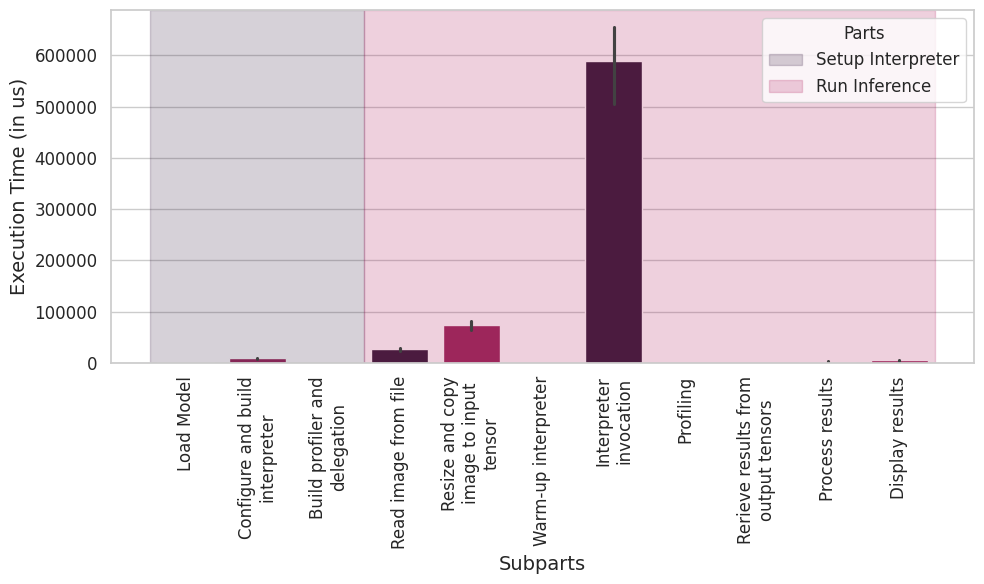

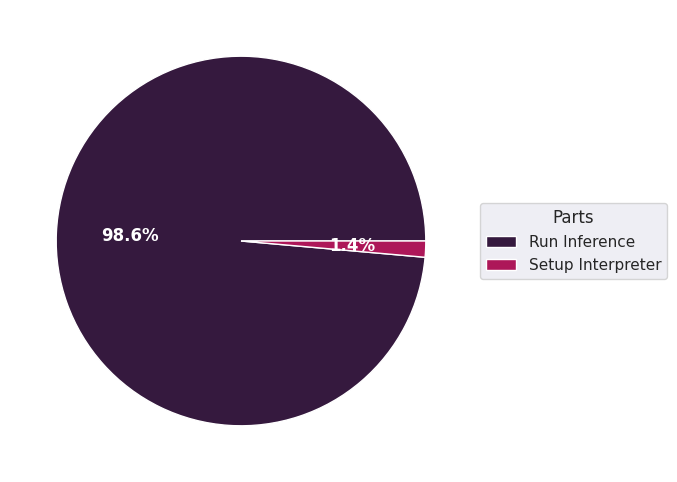

/tmp/ipykernel_148756/2311513605.py:43: UserWarning: 
The palette list has fewer values (3) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)


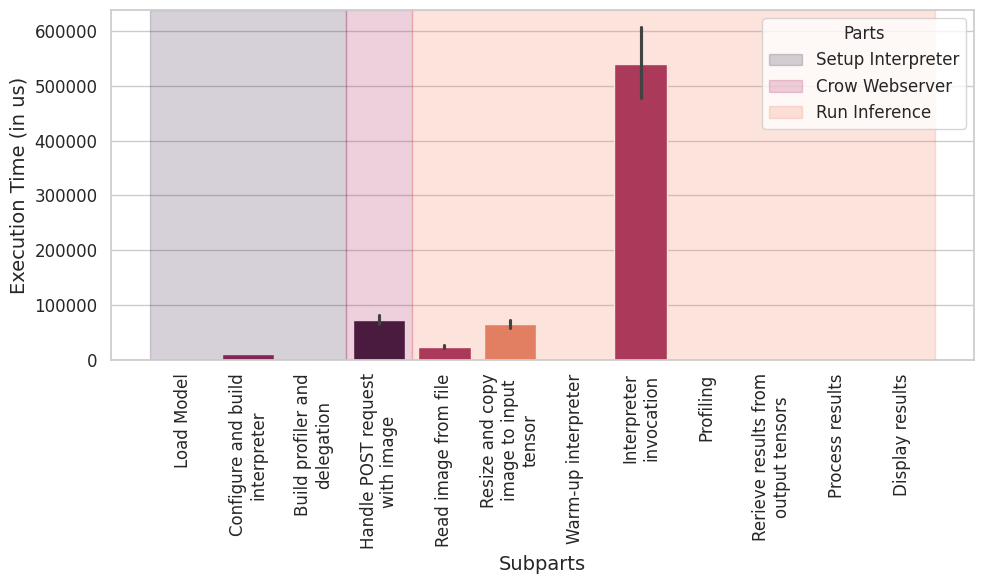

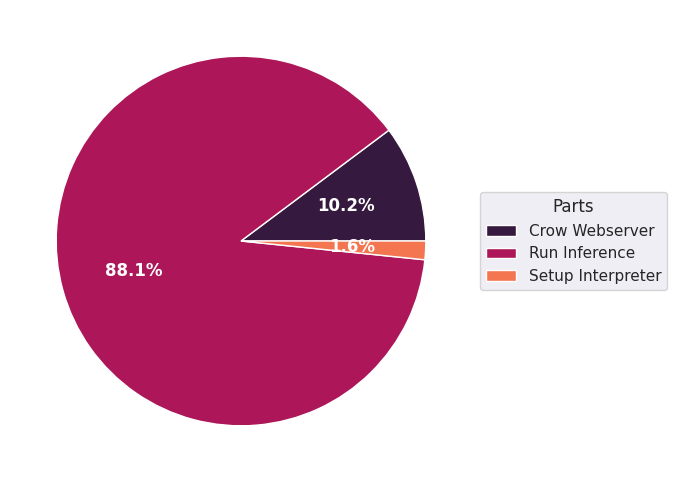

/tmp/ipykernel_148756/2311513605.py:43: UserWarning: 
The palette list has fewer values (3) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)


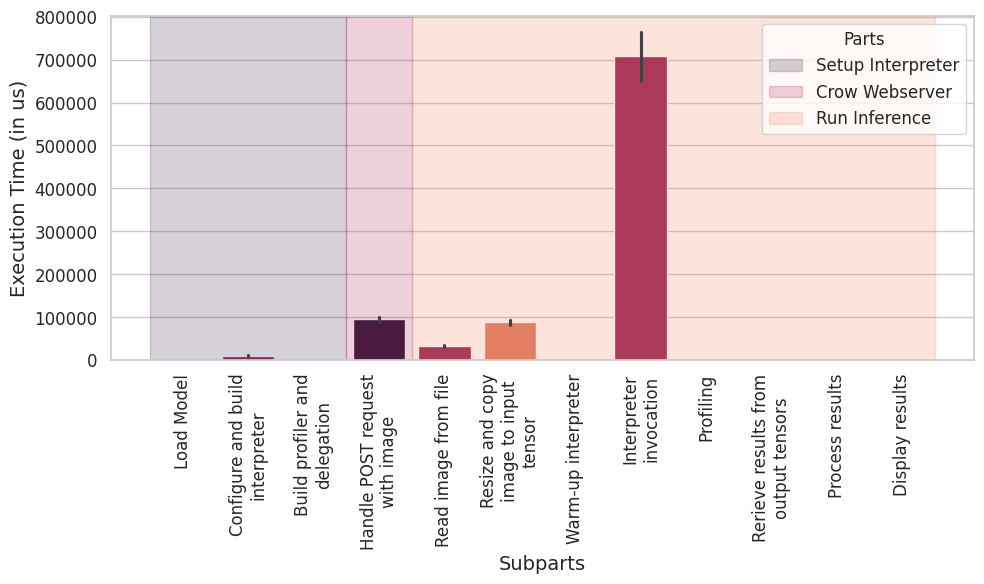

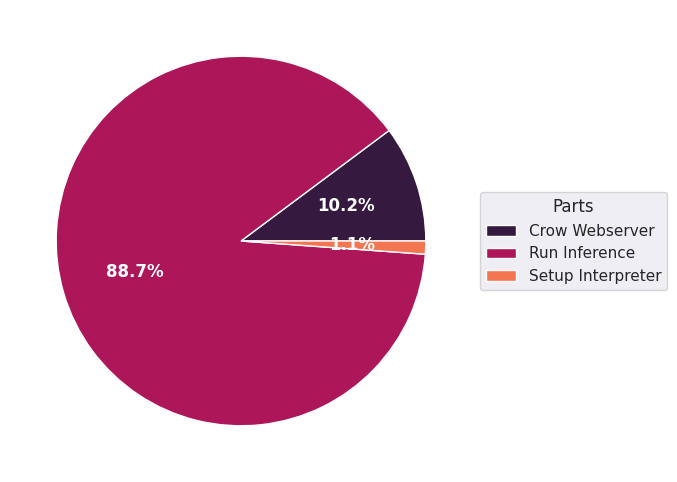

/tmp/ipykernel_148756/2311513605.py:43: UserWarning: 
The palette list has fewer values (3) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)


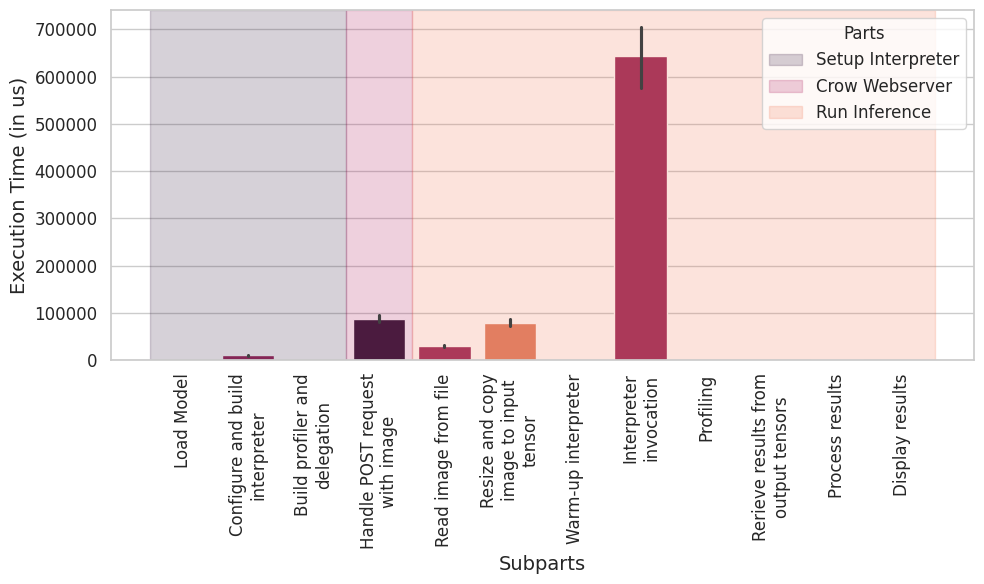

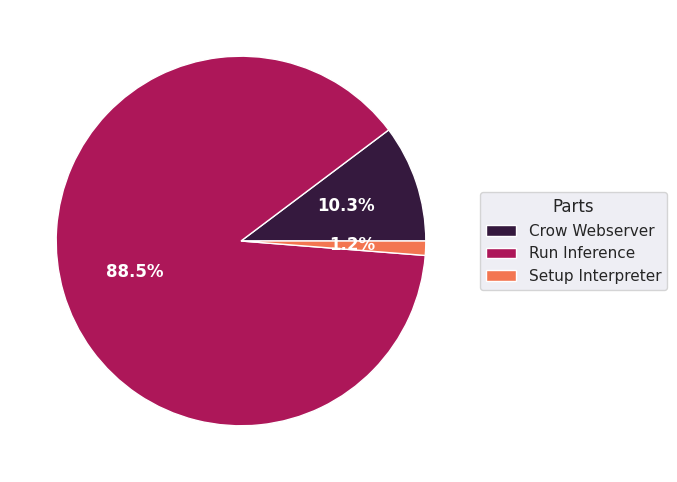

In [130]:
df_exec_time = pd.read_csv(exp_dir + "/execution_time_by_parts.csv")
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

for imp in implementations:
    df_exec_time_imp = df_exec_time[df_exec_time["Implementation"] == imp]
    # mask = df_exec_time_imp[(df_exec_time_imp["Subpart"] != "Global time") & (df_exec_time_imp["Subpart"] != "Run inference") & (df_exec_time_imp["Subpart"] != "Average invokation time per loop")]
    df_exec_time_imp = df_exec_time_imp[(df_exec_time_imp["Subpart"] != "Global time") & (df_exec_time_imp["Subpart"] != "Run inference") & (df_exec_time_imp["Subpart"] != "Average interpreter invocation per loop")]
    df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
    df_cpu_usage_imp = df_cpu_usage[df_cpu_usage["Implementation"] == imp]
    df_ram_usage_imp = df_ram_usage[df_ram_usage["Implementation"] == imp]

    df_exec_time_imp_med = df_exec_time_imp.groupby(["Medium"])

    medium_group = df_exec_time_imp.groupby("Medium")

    

    part_subpart_order = df_exec_time_imp[["Part", "Subpart"]].drop_duplicates()
    part_order = part_subpart_order["Part"].unique()
    subpart_order = part_subpart_order["Subpart"].to_list()
    
    # Generate unique colors for each part
    # colors = plt.cm.viridis([i / float(len(part_order)) for i in range(len(part_order))])

    for med, item in medium_group:
        SMALL_SIZE = 12
        MEDIUM_SIZE = 14
        BIGGER_SIZE = 16

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

        colors = sns.color_palette('rocket')[::2]
        # Bar plot
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)

        # Add background colors
        start_idx = 0
        start_idx = 0
        for i, part in enumerate(part_order):
            part_count = len(part_subpart_order[part_subpart_order["Part"] == part])
            end_idx = start_idx + part_count
            plt.axvspan(start_idx - 0.5, end_idx - 0.5, color=colors[i], alpha=0.2, label=part)
            start_idx = end_idx
        
        plt.legend(title="Parts")
        plt.xlabel("Subparts")
        plt.xticks(rotation=90)
        plt.ylim(bottom=0)
        plt.tight_layout()
    
        plt.savefig(graphs_exec_time_dir + "/barplot_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")
        plt.show()

        # Pie plot
        SMALL_SIZE = 12
        MEDIUM_SIZE = 14
        BIGGER_SIZE = 16

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

        colors = sns.color_palette('rocket')[::2] 
        sns.set_theme()

        data_by_part = item.groupby("Part").sum()
        data_by_part["Execution Time (in us)"] = data_by_part["Execution Time (in us)"] / data_by_part["Execution Time (in us)"].sum()

        wedges, texts, autotexts = ax.pie(data_by_part["Execution Time (in us)"], autopct='%1.1f%%', colors=colors, startangle=0)

        for text in plt.gca().texts:
            text.set_color('white')
            text.set_fontsize(16)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(16)

        ax.legend(wedges, data_by_part.index.values,
                title="Parts",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1))

        plt.setp(autotexts, size=12, weight="bold")

        plt.savefig(graphs_exec_time_dir + "/pieplot_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")
        plt.show()

/tmp/ipykernel_148756/2112033994.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)


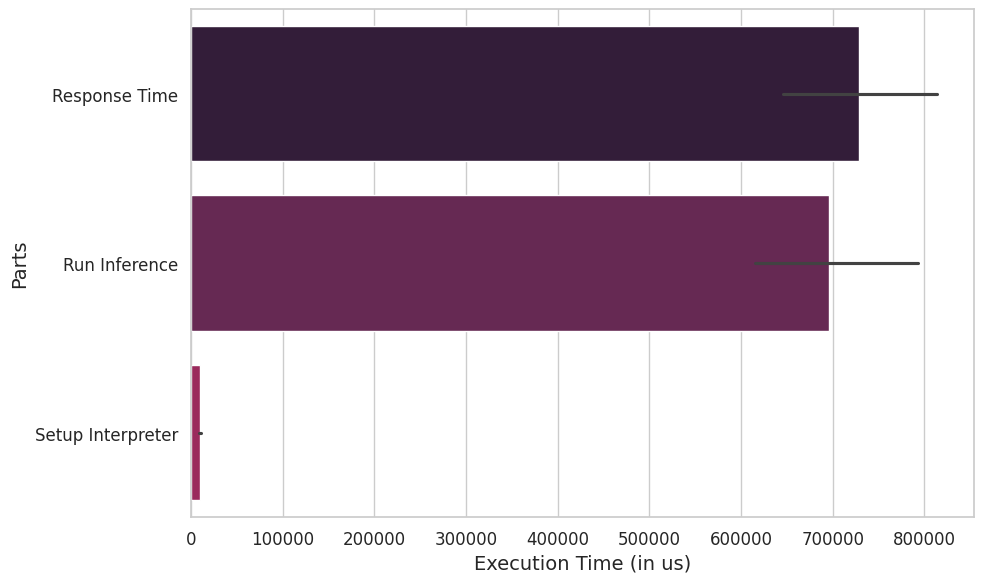

/tmp/ipykernel_148756/2112033994.py:44: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)


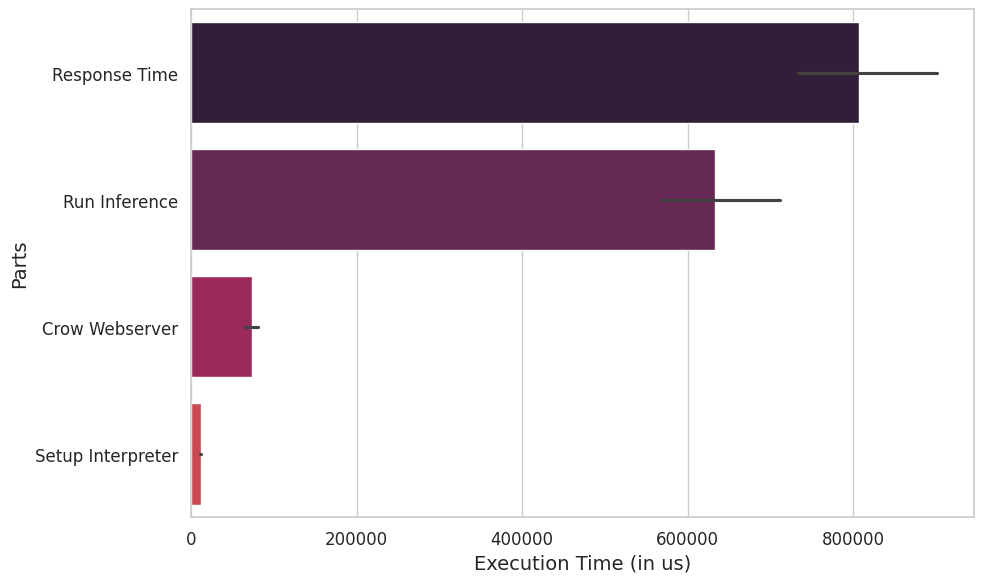

/tmp/ipykernel_148756/2112033994.py:44: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)


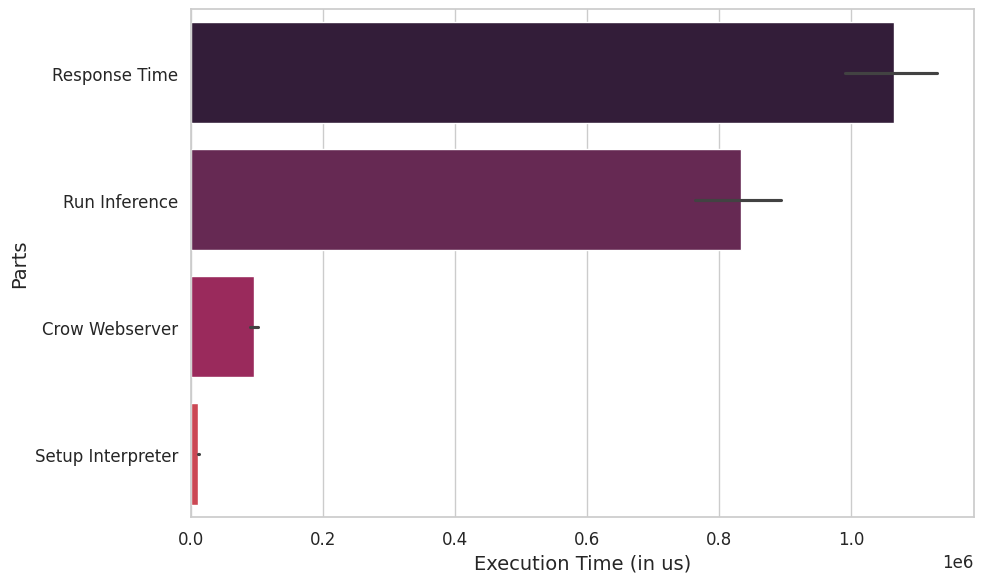

/tmp/ipykernel_148756/2112033994.py:44: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)


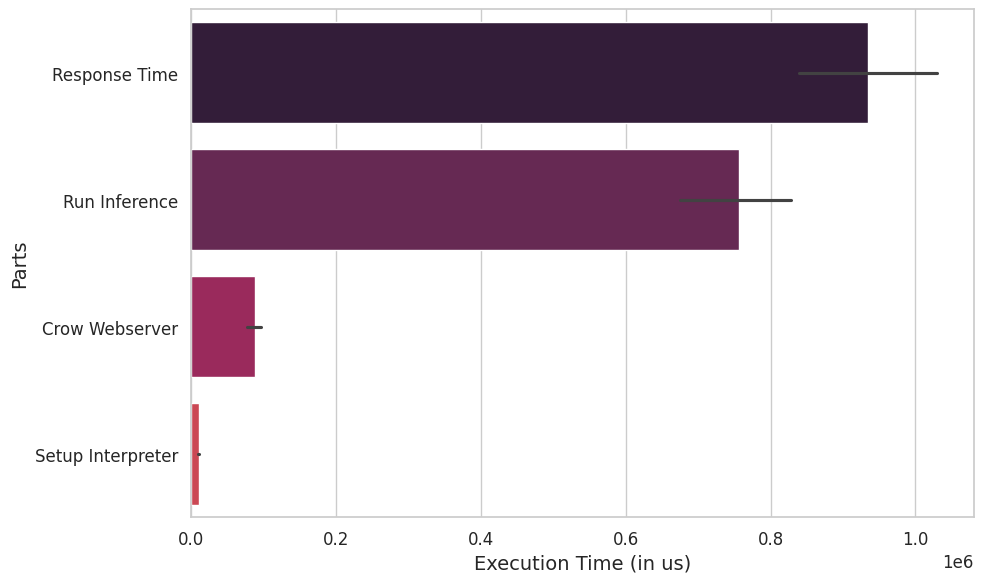

In [131]:
df_exec_time = pd.read_csv(exp_dir + "/execution_time_by_parts.csv")
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

for imp in implementations:
    df_exec_time_imp = df_exec_time[df_exec_time["Implementation"] == imp]
    df_exec_time_imp = df_exec_time_imp[((df_exec_time_imp["Subpart"] != "Global time") | (df_exec_time_imp["Part"] == "Response Time")) & (df_exec_time_imp["Subpart"] != "Run inference") & (df_exec_time_imp["Subpart"] != "Average interpreter invocation per loop")]
    df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
    df_cpu_usage_imp = df_cpu_usage[df_cpu_usage["Implementation"] == imp]
    df_ram_usage_imp = df_ram_usage[df_ram_usage["Implementation"] == imp]

    df_exec_time_imp_med = df_exec_time_imp.groupby(["Medium"])

    medium_group = df_exec_time_imp.groupby("Medium")

    colors = sns.color_palette('rocket')[::]
    # Generate unique colors for each part
    # colors = plt.cm.viridis([i / float(len(part_order)) for i in range(len(part_order))])

    for med, item in medium_group:
        SMALL_SIZE = 12
        MEDIUM_SIZE = 14
        BIGGER_SIZE = 16

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        # Process data
        item = item[["Iteration", "Part", "Execution Time (in us)"]]
        item_group = item.groupby(["Iteration", "Part"]).sum()

        # Get order
        label_order = item_group.groupby("Part").mean().sort_values(by=["Execution Time (in us)"], ascending=False)
        label_order.reset_index(inplace=True)
        label_order = label_order["Part"]

        # Bar plot
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)
        
        # plt.xticks(rotation=90)
        plt.xlim(left=0)
        plt.ylabel("Parts")
        plt.tight_layout()
        plt.tight_layout()
    
        plt.savefig(graphs_exec_time_dir + "/barplot_global_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")
        plt.show()


## Experiment 2: Analysis of the evolution of the execution time of each important part of the TensorFlow Lite application for classical setup with increasing number of inference threads

In [144]:
# Experiment setup
experiment_name = "Evolution of execution time with inference thread"
timestamp = timestamp=datetime.datetime.now() # Current timestamp

iteration = 20
ssh_info = "pptc@192.168.88.3"
ssh_ip = "192.168.88.3"
implementations = ["label_image", "label_image_with_crow"]
mediums = ["WiFi 2.4GHz 20-40MHz", "WiFi 5.0GHz 20-40-80MHz", "Ethernet"]
n_threads = [1, 2, 3, 4]
count_for_usage_script = 30 # correspond to the number of measure taken (1 per second)# Experiment setup

### Perform experiment

In [127]:
# Experiment path
exp_folder_name = experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_folder_name = experiment_name.replace(' ', '_') + "_Final"
curr_exp_dir = global_res_dir + "/" + exp_folder_name

# Remote path
remote_exp_results_dir = "~/" + exp_folder_name + "/results"
remote_exp_cpu_usage_dir = remote_exp_results_dir + "/cpu_usage"
remote_exp_ram_usage_dir = remote_exp_results_dir + "/ram_usage"
remote_exp_scripts_dir = "~/" + exp_folder_name + "/scripts"

# Copy scripts on remote device
!{ssh_with_args} {ssh_info} "mkdir -p ~/{exp_folder_name}"
!{scp_with_args} -r scripts/ {ssh_info}:~/{exp_folder_name}

# Perform the experiment
for imp in implementations:
    imp_mediums = ["na"] if imp == "label_image" else mediums

    # Copy needed assets (executable and images)
    print(f"Copy assets for {imp} on remote device")
    !{scp_with_args} -r {assets_path}/{imp} {ssh_info}:~/{exp_folder_name}/{imp}

    for med in imp_mediums:
        # Validate config:
        print(f"Prepare next config:\n\tImplementation: {imp}\n\tMedium: {med}\n\t\n")
        time.sleep(2)
        v = input("Press ENTER to run the benchmark")
        print(f"Value : {v}")
        if v == "s": # stop
            break
        print("Run benchmark...")

        # Create remote workspace
        !{ssh_with_args} {ssh_info} "mkdir -p {remote_exp_cpu_usage_dir}; mkdir -p {remote_exp_ram_usage_dir}"

        # Implementation paths
        curr_exp_imp_dir = curr_exp_dir + "/" + imp.replace(' ', '_')
        curr_exp_imp_med_dir = curr_exp_imp_dir + ("/" + med.replace(' ', '_') if med != "na" else "")
        curr_exp_imp_raw_dir = curr_exp_imp_med_dir + "/raw_results"
        curr_exp_imp_res_dir = curr_exp_imp_med_dir + "/results"
        curr_exp_imp_raw_file = curr_exp_imp_raw_dir + "/execution_time_by_part.txt"

        # Create results dir
        path = Path(curr_exp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_raw_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Print experiment setup in results file
        # Local for execution time
        with open(curr_exp_imp_raw_file, "w") as raw:
            raw.write(f"# SSH_INFO={ssh_info}\n")
            raw.write(f"# ITERATIONS={iteration}\n")
            raw.write(f"# IMPLEMENTATION={imp}\n")
            raw.write(f"# MEDIUM={med}\n")

        for t in n_threads:
            with open(curr_exp_imp_raw_file, "a") as raw:
                raw.write(f"\n# THREADS {t}\n")

            # Remote paths
            cpu_usage_remote_file = remote_exp_cpu_usage_dir + "/results_cpu_usage_" + imp + "_" + med.replace(' ', '_') + "_" + str(t) + ".txt"
            ram_usage_remote_file = remote_exp_ram_usage_dir + "/results_ram_usage_" + imp + "_" + med.replace(' ', '_') + "_" + str(t) + ".txt"

            # Remote for cpu and ram usage
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# THREADS={t}\n# COUNT={count_for_usage_script}\n\" > {cpu_usage_remote_file}"
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# THREADS={t}\n# COUNT={count_for_usage_script}\n\" > {ram_usage_remote_file}"

            # Perform test
            for i in range(iteration):
                # Print iteration
                print(f"Iteration {i}")
                with open(curr_exp_imp_raw_file, "a") as raw:
                    raw.write(f"\n# ITERATION {i}\n")
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {cpu_usage_remote_file}"
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {ram_usage_remote_file}"

                # Run cpu and ram usage script
                print("Start CPU and RAM usage scripts")
                
                cpu_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/cpu_usage_script.sh {count_for_usage_script} {cpu_usage_remote_file} 0"', shell=True)
                ram_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/ram_usage_script.sh {count_for_usage_script} {ram_usage_remote_file} 0"', shell=True)

                print("Sleep 3s")
                time.sleep(3) # To have more usage measures

                
                print("Perform measure")
                if imp == "label_image":
                    start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                    !{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; (time ./{imp} -m mobilenet_v1_1.0_224.tflite -l labels.txt -i grace_hopper.bmp --num_threads {t} -d 1 -w 0)" &>> {curr_exp_imp_raw_file}

                    stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                else:
                    server_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; ./{imp} -c config.json -t {t}"', shell=True)
                    time.sleep(3)
                    
                    start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                    !(time curl -X POST -F "image=@{assets_path}/label_image_with_crow/grace_hopper.bmp" http://{ssh_ip}:18080/label_image) &>> {curr_exp_imp_raw_file}

                    stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                    
                    # Kill server
                    print("Kill server")
                    server_process.kill()
                    !{ssh_with_args} {ssh_info} 'kill $(pidof {imp})'


                print("Sleep 3s")
                time.sleep(3)  # To have more usage measures

                print("Kill CPU and RAM usage scripts")
                cpu_usage_process.kill()
                ram_usage_process.kill()
                !{ssh_with_args} {ssh_info} 'kill $(pidof cpu_usage_script.sh)'
                !{ssh_with_args} {ssh_info} 'kill $(pidof ram_usage_script.sh)'

                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {cpu_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {cpu_usage_remote_file}"
                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {ram_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {ram_usage_remote_file}"

        print("Retrieve usage results and remove remote workspace")
        !{scp_with_args} -r {ssh_info}:{remote_exp_cpu_usage_dir} {curr_exp_imp_raw_dir}
        !{scp_with_args} -r {ssh_info}:{remote_exp_ram_usage_dir} {curr_exp_imp_raw_dir}

        !{ssh_with_args} {ssh_info} "rm -rf {remote_exp_cpu_usage_dir}; rm -rf {remote_exp_ram_usage_dir}"

# Remove remote workspace
!{ssh_with_args} {ssh_info} "rm -rf ~/{exp_folder_name}"

cpu_usage_script.sh                           100% 1189   724.0KB/s   00:00    
ram_usage_script.sh                           100% 1253   860.1KB/s   00:00    
Copy assets for label_image_with_crow on remote device
label_image_with_crow                         100% 5425KB  11.1MB/s   00:00    
mobilenet_v1_1.0_224.tflite                   100%   16MB   3.3MB/s   00:04    
grace_hopper.bmp                              100%  919KB  10.7MB/s   00:00    
labels.txt                                    100%   10KB   3.0MB/s   00:00    
config.json                                   100%  530   334.8KB/s   00:00    
Prepare next config:
	Implementation: label_image_with_crow
	Medium: Ethernet
	

Value : 
Run benchmark...
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:54:20) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:54:20) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:54:23) [INFO    ] Request: 192.168.88.200:38454 0xb5d4b200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:54:24) [INFO    ] Response: 0xb5d4b200 /label_image 200 0


Sleep 3s


(2024-08-11 21:54:25) [INFO    ] Closing IO service 0xb580b6f0
(2024-08-11 21:54:25) [INFO    ] Closing IO service 0xb580b6f4
(2024-08-11 21:54:25) [INFO    ] Closing IO service 0xb580b6f8
(2024-08-11 21:54:25) [INFO    ] Closing main IO service (0xb5d394dc)
(2024-08-11 21:54:25) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:54:34) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:54:34) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:54:37) [INFO    ] Request: 192.168.88.200:53652 0xb5ce8200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:54:37) [INFO    ] Response: 0xb5ce8200 /label_image 200 0


Sleep 3s


(2024-08-11 21:54:38) [INFO    ] Closing IO service 0xb57a86f0
(2024-08-11 21:54:38) [INFO    ] Closing IO service 0xb57a86f4
(2024-08-11 21:54:38) [INFO    ] Closing IO service 0xb57a86f8
(2024-08-11 21:54:38) [INFO    ] Closing main IO service (0xb5cd64dc)
(2024-08-11 21:54:38) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:54:47) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:54:47) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:54:50) [INFO    ] Request: 192.168.88.200:51876 0xb5c88200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:54:51) [INFO    ] Response: 0xb5c88200 /label_image 200 0


Sleep 3s


(2024-08-11 21:54:51) [INFO    ] Closing IO service 0xb57486f0
(2024-08-11 21:54:51) [INFO    ] Closing IO service 0xb57486f4
(2024-08-11 21:54:51) [INFO    ] Closing IO service 0xb57486f8
(2024-08-11 21:54:51) [INFO    ] Closing main IO service (0xb5c764dc)
(2024-08-11 21:54:51) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:55:01) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:55:01) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:55:03) [INFO    ] Request: 192.168.88.200:53266 0xb5cd0200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:55:04) [INFO    ] Response: 0xb5cd0200 /label_image 200 0


Sleep 3s


(2024-08-11 21:55:05) [INFO    ] Closing IO service 0xb57906f0
(2024-08-11 21:55:05) [INFO    ] Closing IO service 0xb57906f4
(2024-08-11 21:55:05) [INFO    ] Closing IO service 0xb57906f8
(2024-08-11 21:55:05) [INFO    ] Closing main IO service (0xb5cbe4dc)
(2024-08-11 21:55:05) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:55:14) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:55:14) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:55:17) [INFO    ] Request: 192.168.88.200:57994 0xb5d14200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:55:18) [INFO    ] Response: 0xb5d14200 /label_image 200 0


Sleep 3s


(2024-08-11 21:55:18) [INFO    ] Closing IO service 0xb57d46f0
(2024-08-11 21:55:18) [INFO    ] Closing IO service 0xb57d46f4
(2024-08-11 21:55:18) [INFO    ] Closing IO service 0xb57d46f8
(2024-08-11 21:55:18) [INFO    ] Closing main IO service (0xb5d024dc)
(2024-08-11 21:55:18) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:55:28) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:55:28) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:55:31) [INFO    ] Request: 192.168.88.200:51632 0xb5cef200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:55:31) [INFO    ] Response: 0xb5cef200 /label_image 200 0


Sleep 3s


(2024-08-11 21:55:32) [INFO    ] Closing IO service 0xb57af6f0
(2024-08-11 21:55:32) [INFO    ] Closing IO service 0xb57af6f4
(2024-08-11 21:55:32) [INFO    ] Closing IO service 0xb57af6f8
(2024-08-11 21:55:32) [INFO    ] Closing main IO service (0xb5cdd4dc)
(2024-08-11 21:55:32) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:55:41) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:55:41) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:55:44) [INFO    ] Request: 192.168.88.200:37142 0xb5cd8200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:55:45) [INFO    ] Response: 0xb5cd8200 /label_image 200 0


Sleep 3s


(2024-08-11 21:55:45) [INFO    ] Closing IO service 0xb57986f0
(2024-08-11 21:55:45) [INFO    ] Closing IO service 0xb57986f4
(2024-08-11 21:55:45) [INFO    ] Closing IO service 0xb57986f8
(2024-08-11 21:55:45) [INFO    ] Closing main IO service (0xb5cc64dc)
(2024-08-11 21:55:45) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:55:55) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:55:55) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:55:57) [INFO    ] Request: 192.168.88.200:37360 0xb5c73200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:55:58) [INFO    ] Response: 0xb5c73200 /label_image 200 0


Sleep 3s


(2024-08-11 21:55:59) [INFO    ] Closing IO service 0xb57336f0
(2024-08-11 21:55:59) [INFO    ] Closing IO service 0xb57336f4
(2024-08-11 21:55:59) [INFO    ] Closing IO service 0xb57336f8
(2024-08-11 21:55:59) [INFO    ] Closing main IO service (0xb5c614dc)
(2024-08-11 21:55:59) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:56:08) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:56:08) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:56:11) [INFO    ] Request: 192.168.88.200:58136 0xb5c75200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:56:12) [INFO    ] Response: 0xb5c75200 /label_image 200 0


Sleep 3s


(2024-08-11 21:56:13) [INFO    ] Closing IO service 0xb57356f0
(2024-08-11 21:56:13) [INFO    ] Closing IO service 0xb57356f4
(2024-08-11 21:56:13) [INFO    ] Closing IO service 0xb57356f8
(2024-08-11 21:56:13) [INFO    ] Closing main IO service (0xb5c634dc)
(2024-08-11 21:56:13) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:56:22) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:56:22) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:56:25) [INFO    ] Request: 192.168.88.200:44382 0xb5c95200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:56:26) [INFO    ] Response: 0xb5c95200 /label_image 200 0


Sleep 3s


(2024-08-11 21:56:26) [INFO    ] Closing IO service 0xb57556f0
(2024-08-11 21:56:26) [INFO    ] Closing IO service 0xb57556f4
(2024-08-11 21:56:26) [INFO    ] Closing IO service 0xb57556f8
(2024-08-11 21:56:26) [INFO    ] Closing main IO service (0xb5c834dc)
(2024-08-11 21:56:26) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:56:36) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:56:36) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:56:38) [INFO    ] Request: 192.168.88.200:42512 0xb5d19200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:56:39) [INFO    ] Response: 0xb5d19200 /label_image 200 0


Sleep 3s


(2024-08-11 21:56:39) [INFO    ] Closing IO service 0xb57d96f0
(2024-08-11 21:56:39) [INFO    ] Closing IO service 0xb57d96f4
(2024-08-11 21:56:39) [INFO    ] Closing IO service 0xb57d96f8
(2024-08-11 21:56:39) [INFO    ] Closing main IO service (0xb5d074dc)
(2024-08-11 21:56:39) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:56:49) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:56:49) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:56:52) [INFO    ] Request: 192.168.88.200:49324 0xb5d4c200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:56:52) [INFO    ] Response: 0xb5d4c200 /label_image 200 0


Sleep 3s


(2024-08-11 21:56:53) [INFO    ] Closing IO service 0xb580c6f0
(2024-08-11 21:56:53) [INFO    ] Closing IO service 0xb580c6f4
(2024-08-11 21:56:53) [INFO    ] Closing IO service 0xb580c6f8
(2024-08-11 21:56:53) [INFO    ] Closing main IO service (0xb5d3a4dc)
(2024-08-11 21:56:53) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:57:02) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:57:02) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:57:05) [INFO    ] Request: 192.168.88.200:55800 0xb5c8f200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:57:05) [INFO    ] Response: 0xb5c8f200 /label_image 200 0


Sleep 3s


(2024-08-11 21:57:06) [INFO    ] Closing IO service 0xb574f6f0
(2024-08-11 21:57:06) [INFO    ] Closing IO service 0xb574f6f4
(2024-08-11 21:57:06) [INFO    ] Closing IO service 0xb574f6f8
(2024-08-11 21:57:06) [INFO    ] Closing main IO service (0xb5c7d4dc)
(2024-08-11 21:57:06) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:57:15) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:57:15) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:57:18) [INFO    ] Request: 192.168.88.200:57938 0xb5c65200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:57:19) [INFO    ] Response: 0xb5c65200 /label_image 200 0


Sleep 3s


(2024-08-11 21:57:19) [INFO    ] Closing IO service 0xb57256f0
(2024-08-11 21:57:19) [INFO    ] Closing IO service 0xb57256f4
(2024-08-11 21:57:19) [INFO    ] Closing IO service 0xb57256f8
(2024-08-11 21:57:19) [INFO    ] Closing main IO service (0xb5c534dc)
(2024-08-11 21:57:19) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:57:29) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:57:29) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:57:31) [INFO    ] Request: 192.168.88.200:57336 0xb5ca4200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:57:32) [INFO    ] Response: 0xb5ca4200 /label_image 200 0


Sleep 3s


(2024-08-11 21:57:32) [INFO    ] Closing IO service 0xb57646f0
(2024-08-11 21:57:32) [INFO    ] Closing IO service 0xb57646f4
(2024-08-11 21:57:32) [INFO    ] Closing IO service 0xb57646f8
(2024-08-11 21:57:32) [INFO    ] Closing main IO service (0xb5c924dc)
(2024-08-11 21:57:32) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:57:42) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:57:42) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:57:45) [INFO    ] Request: 192.168.88.200:34904 0xb5c6f200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:57:45) [INFO    ] Response: 0xb5c6f200 /label_image 200 0


Sleep 3s


(2024-08-11 21:57:46) [INFO    ] Closing IO service 0xb572f6f0
(2024-08-11 21:57:46) [INFO    ] Closing IO service 0xb572f6f4
(2024-08-11 21:57:46) [INFO    ] Closing IO service 0xb572f6f8
(2024-08-11 21:57:46) [INFO    ] Closing main IO service (0xb5c5d4dc)
(2024-08-11 21:57:46) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:57:55) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:57:55) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:57:58) [INFO    ] Request: 192.168.88.200:56752 0xb5c69200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:57:58) [INFO    ] Response: 0xb5c69200 /label_image 200 0


Sleep 3s


(2024-08-11 21:57:59) [INFO    ] Closing IO service 0xb57296f0
(2024-08-11 21:57:59) [INFO    ] Closing IO service 0xb57296f4
(2024-08-11 21:57:59) [INFO    ] Closing IO service 0xb57296f8
(2024-08-11 21:57:59) [INFO    ] Closing main IO service (0xb5c574dc)
(2024-08-11 21:57:59) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:58:08) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:58:08) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:58:11) [INFO    ] Request: 192.168.88.200:48006 0xb5d24200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:58:12) [INFO    ] Response: 0xb5d24200 /label_image 200 0


Sleep 3s


(2024-08-11 21:58:12) [INFO    ] Closing IO service 0xb57e46f0
(2024-08-11 21:58:12) [INFO    ] Closing IO service 0xb57e46f4
(2024-08-11 21:58:12) [INFO    ] Closing IO service 0xb57e46f8
(2024-08-11 21:58:12) [INFO    ] Closing main IO service (0xb5d124dc)
(2024-08-11 21:58:12) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:58:21) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:58:21) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:58:24) [INFO    ] Request: 192.168.88.200:42388 0xb5d19200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:58:25) [INFO    ] Response: 0xb5d19200 /label_image 200 0


Sleep 3s


(2024-08-11 21:58:25) [INFO    ] Closing IO service 0xb57d96f0
(2024-08-11 21:58:25) [INFO    ] Closing IO service 0xb57d96f4
(2024-08-11 21:58:25) [INFO    ] Closing IO service 0xb57d96f8
(2024-08-11 21:58:25) [INFO    ] Closing main IO service (0xb5d074dc)
(2024-08-11 21:58:25) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:58:35) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:58:35) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:58:37) [INFO    ] Request: 192.168.88.200:54422 0xb5cd3200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:58:38) [INFO    ] Response: 0xb5cd3200 /label_image 200 0


Sleep 3s


(2024-08-11 21:58:38) [INFO    ] Closing IO service 0xb57936f0
(2024-08-11 21:58:38) [INFO    ] Closing IO service 0xb57936f4
(2024-08-11 21:58:38) [INFO    ] Closing IO service 0xb57936f8
(2024-08-11 21:58:38) [INFO    ] Closing main IO service (0xb5cc14dc)
(2024-08-11 21:58:38) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:58:49) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:58:49) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:58:52) [INFO    ] Request: 192.168.88.200:54690 0xb5c8e210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:58:53) [INFO    ] Response: 0xb5c8e210 /label_image 200 0


Sleep 3s


(2024-08-11 21:58:53) [INFO    ] Closing IO service 0xb476a6d0
(2024-08-11 21:58:53) [INFO    ] Closing IO service 0xb476a6d4
(2024-08-11 21:58:53) [INFO    ] Closing IO service 0xb476a6d8
(2024-08-11 21:58:53) [INFO    ] Closing main IO service (0xb5c7b34c)
(2024-08-11 21:58:53) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:59:03) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:59:03) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:59:05) [INFO    ] Request: 192.168.88.200:52912 0xb5c57210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:59:07) [INFO    ] Response: 0xb5c57210 /label_image 200 0


Sleep 3s


(2024-08-11 21:59:07) [INFO    ] Closing IO service 0xb47336d0
(2024-08-11 21:59:07) [INFO    ] Closing IO service 0xb47336d4
(2024-08-11 21:59:07) [INFO    ] Closing IO service 0xb47336d8
(2024-08-11 21:59:07) [INFO    ] Closing main IO service (0xb5c4434c)
(2024-08-11 21:59:07) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:59:17) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:59:17) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:59:19) [INFO    ] Request: 192.168.88.200:57398 0xb5ce6210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:59:21) [INFO    ] Response: 0xb5ce6210 /label_image 200 0


Sleep 3s


(2024-08-11 21:59:21) [INFO    ] Closing IO service 0xb47c26d0
(2024-08-11 21:59:21) [INFO    ] Closing IO service 0xb47c26d4
(2024-08-11 21:59:21) [INFO    ] Closing IO service 0xb47c26d8
(2024-08-11 21:59:21) [INFO    ] Closing main IO service (0xb5cd334c)
(2024-08-11 21:59:21) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:59:31) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:59:31) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:59:33) [INFO    ] Request: 192.168.88.200:45404 0xb5c93210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:59:35) [INFO    ] Response: 0xb5c93210 /label_image 200 0


Sleep 3s


(2024-08-11 21:59:35) [INFO    ] Closing IO service 0xb476f6d0
(2024-08-11 21:59:35) [INFO    ] Closing IO service 0xb476f6d4
(2024-08-11 21:59:35) [INFO    ] Closing IO service 0xb476f6d8
(2024-08-11 21:59:35) [INFO    ] Closing main IO service (0xb5c8034c)
(2024-08-11 21:59:35) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:59:44) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:59:44) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:59:47) [INFO    ] Request: 192.168.88.200:46620 0xb5d55210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:59:48) [INFO    ] Response: 0xb5d55210 /label_image 200 0


Sleep 3s


(2024-08-11 21:59:49) [INFO    ] Closing IO service 0xb48316d0
(2024-08-11 21:59:49) [INFO    ] Closing IO service 0xb48316d4
(2024-08-11 21:59:49) [INFO    ] Closing IO service 0xb48316d8
(2024-08-11 21:59:49) [INFO    ] Closing main IO service (0xb5d4234c)
(2024-08-11 21:59:49) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:59:58) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:59:58) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:00:01) [INFO    ] Request: 192.168.88.200:44800 0xb5cc4210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:00:02) [INFO    ] Response: 0xb5cc4210 /label_image 200 0


Sleep 3s


(2024-08-11 22:00:03) [INFO    ] Closing IO service 0xb47a06d0
(2024-08-11 22:00:03) [INFO    ] Closing IO service 0xb47a06d4
(2024-08-11 22:00:03) [INFO    ] Closing IO service 0xb47a06d8
(2024-08-11 22:00:03) [INFO    ] Closing main IO service (0xb5cb134c)
(2024-08-11 22:00:03) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:00:12) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:00:12) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:00:15) [INFO    ] Request: 192.168.88.200:53060 0xb5d0a210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:00:16) [INFO    ] Response: 0xb5d0a210 /label_image 200 0


Sleep 3s


(2024-08-11 22:00:17) [INFO    ] Closing IO service 0xb47e66d0
(2024-08-11 22:00:17) [INFO    ] Closing IO service 0xb47e66d4
(2024-08-11 22:00:17) [INFO    ] Closing IO service 0xb47e66d8
(2024-08-11 22:00:17) [INFO    ] Closing main IO service (0xb5cf734c)
(2024-08-11 22:00:17) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:00:26) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:00:26) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:00:29) [INFO    ] Request: 192.168.88.200:36660 0xb5d38210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:00:30) [INFO    ] Response: 0xb5d38210 /label_image 200 0


Sleep 3s


(2024-08-11 22:00:30) [INFO    ] Closing IO service 0xb48146d0
(2024-08-11 22:00:30) [INFO    ] Closing IO service 0xb48146d4
(2024-08-11 22:00:30) [INFO    ] Closing IO service 0xb48146d8
(2024-08-11 22:00:30) [INFO    ] Closing main IO service (0xb5d2534c)
(2024-08-11 22:00:30) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:00:40) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:00:40) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:00:43) [INFO    ] Request: 192.168.88.200:47842 0xb5ce6210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:00:44) [INFO    ] Response: 0xb5ce6210 /label_image 200 0


Sleep 3s


(2024-08-11 22:00:44) [INFO    ] Closing IO service 0xb47c26d0
(2024-08-11 22:00:44) [INFO    ] Closing IO service 0xb47c26d4
(2024-08-11 22:00:44) [INFO    ] Closing IO service 0xb47c26d8
(2024-08-11 22:00:44) [INFO    ] Closing main IO service (0xb5cd334c)
(2024-08-11 22:00:44) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:00:54) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:00:54) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:00:56) [INFO    ] Request: 192.168.88.200:57896 0xb5d50210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:00:58) [INFO    ] Response: 0xb5d50210 /label_image 200 0


Sleep 3s


(2024-08-11 22:00:58) [INFO    ] Closing IO service 0xb482c6d0
(2024-08-11 22:00:58) [INFO    ] Closing IO service 0xb482c6d4
(2024-08-11 22:00:58) [INFO    ] Closing IO service 0xb482c6d8
(2024-08-11 22:00:58) [INFO    ] Closing main IO service (0xb5d3d34c)
(2024-08-11 22:00:58) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:01:07) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:01:07) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:01:10) [INFO    ] Request: 192.168.88.200:41814 0xb5c57210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:01:12) [INFO    ] Response: 0xb5c57210 /label_image 200 0


Sleep 3s


(2024-08-11 22:01:12) [INFO    ] Closing IO service 0xb47336d0
(2024-08-11 22:01:12) [INFO    ] Closing IO service 0xb47336d4
(2024-08-11 22:01:12) [INFO    ] Closing IO service 0xb47336d8
(2024-08-11 22:01:12) [INFO    ] Closing main IO service (0xb5c4434c)
(2024-08-11 22:01:12) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:01:21) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:01:21) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:01:24) [INFO    ] Request: 192.168.88.200:38866 0xb5cc8210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:01:25) [INFO    ] Response: 0xb5cc8210 /label_image 200 0


Sleep 3s


(2024-08-11 22:01:26) [INFO    ] Closing IO service 0xb47a46d0
(2024-08-11 22:01:26) [INFO    ] Closing IO service 0xb47a46d4
(2024-08-11 22:01:26) [INFO    ] Closing IO service 0xb47a46d8
(2024-08-11 22:01:26) [INFO    ] Closing main IO service (0xb5cb534c)
(2024-08-11 22:01:26) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:01:35) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:01:35) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:01:38) [INFO    ] Request: 192.168.88.200:42238 0xb5c8c210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:01:39) [INFO    ] Response: 0xb5c8c210 /label_image 200 0


Sleep 3s


(2024-08-11 22:01:40) [INFO    ] Closing IO service 0xb47686d0
(2024-08-11 22:01:40) [INFO    ] Closing IO service 0xb47686d4
(2024-08-11 22:01:40) [INFO    ] Closing IO service 0xb47686d8
(2024-08-11 22:01:40) [INFO    ] Closing main IO service (0xb5c7934c)
(2024-08-11 22:01:40) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:01:49) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:01:49) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:01:52) [INFO    ] Request: 192.168.88.200:53230 0xb5cb3210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:01:53) [INFO    ] Response: 0xb5cb3210 /label_image 200 0


Sleep 3s


(2024-08-11 22:01:54) [INFO    ] Closing IO service 0xb478f6d0
(2024-08-11 22:01:54) [INFO    ] Closing IO service 0xb478f6d4
(2024-08-11 22:01:54) [INFO    ] Closing IO service 0xb478f6d8
(2024-08-11 22:01:54) [INFO    ] Closing main IO service (0xb5ca034c)
(2024-08-11 22:01:54) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:02:03) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:02:03) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:02:06) [INFO    ] Request: 192.168.88.200:48488 0xb5cab210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:02:07) [INFO    ] Response: 0xb5cab210 /label_image 200 0


Sleep 3s


(2024-08-11 22:02:08) [INFO    ] Closing IO service 0xb47876d0
(2024-08-11 22:02:08) [INFO    ] Closing IO service 0xb47876d4
(2024-08-11 22:02:08) [INFO    ] Closing IO service 0xb47876d8
(2024-08-11 22:02:08) [INFO    ] Closing main IO service (0xb5c9834c)
(2024-08-11 22:02:08) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:02:17) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:02:17) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:02:20) [INFO    ] Request: 192.168.88.200:37626 0xb5c65210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:02:21) [INFO    ] Response: 0xb5c65210 /label_image 200 0


Sleep 3s


(2024-08-11 22:02:22) [INFO    ] Closing IO service 0xb47416d0
(2024-08-11 22:02:22) [INFO    ] Closing IO service 0xb47416d4
(2024-08-11 22:02:22) [INFO    ] Closing IO service 0xb47416d8
(2024-08-11 22:02:22) [INFO    ] Closing main IO service (0xb5c5234c)
(2024-08-11 22:02:22) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:02:31) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:02:31) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:02:34) [INFO    ] Request: 192.168.88.200:50162 0xb5c8d210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:02:35) [INFO    ] Response: 0xb5c8d210 /label_image 200 0


Sleep 3s


(2024-08-11 22:02:36) [INFO    ] Closing IO service 0xb47696d0
(2024-08-11 22:02:36) [INFO    ] Closing IO service 0xb47696d4
(2024-08-11 22:02:36) [INFO    ] Closing IO service 0xb47696d8
(2024-08-11 22:02:36) [INFO    ] Closing main IO service (0xb5c7a34c)
(2024-08-11 22:02:36) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:02:45) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:02:45) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:02:48) [INFO    ] Request: 192.168.88.200:42834 0xb5cf7210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:02:49) [INFO    ] Response: 0xb5cf7210 /label_image 200 0


Sleep 3s


(2024-08-11 22:02:50) [INFO    ] Closing IO service 0xb47d36d0
(2024-08-11 22:02:50) [INFO    ] Closing IO service 0xb47d36d4
(2024-08-11 22:02:50) [INFO    ] Closing IO service 0xb47d36d8
(2024-08-11 22:02:50) [INFO    ] Closing main IO service (0xb5ce434c)
(2024-08-11 22:02:50) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:02:59) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:02:59) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:03:02) [INFO    ] Request: 192.168.88.200:48314 0xb5c79210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:03:03) [INFO    ] Response: 0xb5c79210 /label_image 200 0


Sleep 3s


(2024-08-11 22:03:04) [INFO    ] Closing IO service 0xb47556d0
(2024-08-11 22:03:04) [INFO    ] Closing IO service 0xb47556d4
(2024-08-11 22:03:04) [INFO    ] Closing IO service 0xb47556d8
(2024-08-11 22:03:04) [INFO    ] Closing main IO service (0xb5c6634c)
(2024-08-11 22:03:04) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:03:13) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:03:13) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:03:16) [INFO    ] Request: 192.168.88.200:40190 0xb5c88210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:03:17) [INFO    ] Response: 0xb5c88210 /label_image 200 0


Sleep 3s


(2024-08-11 22:03:18) [INFO    ] Closing IO service 0xb47646d0
(2024-08-11 22:03:18) [INFO    ] Closing IO service 0xb47646d4
(2024-08-11 22:03:18) [INFO    ] Closing IO service 0xb47646d8
(2024-08-11 22:03:18) [INFO    ] Closing main IO service (0xb5c7534c)
(2024-08-11 22:03:18) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:03:28) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:03:28) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:03:31) [INFO    ] Request: 192.168.88.200:44130 0xb5ca6210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:03:32) [INFO    ] Response: 0xb5ca6210 /label_image 200 0


Sleep 3s


(2024-08-11 22:03:33) [INFO    ] Closing IO service 0xb47826d0
(2024-08-11 22:03:33) [INFO    ] Closing IO service 0xb47826d4
(2024-08-11 22:03:33) [INFO    ] Closing IO service 0xb47826d8
(2024-08-11 22:03:33) [INFO    ] Closing main IO service (0xb5c9334c)
(2024-08-11 22:03:33) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:03:42) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:03:42) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:03:45) [INFO    ] Request: 192.168.88.200:60112 0xb5d38210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:03:46) [INFO    ] Response: 0xb5d38210 /label_image 200 0


Sleep 3s


(2024-08-11 22:03:46) [INFO    ] Closing IO service 0xb48146d0
(2024-08-11 22:03:46) [INFO    ] Closing IO service 0xb48146d4
(2024-08-11 22:03:46) [INFO    ] Closing IO service 0xb48146d8
(2024-08-11 22:03:46) [INFO    ] Closing main IO service (0xb5d2534c)
(2024-08-11 22:03:46) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:03:56) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:03:56) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:03:59) [INFO    ] Request: 192.168.88.200:35264 0xb5c67210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:04:00) [INFO    ] Response: 0xb5c67210 /label_image 200 0


Sleep 3s


(2024-08-11 22:04:00) [INFO    ] Closing IO service 0xb47436d0
(2024-08-11 22:04:00) [INFO    ] Closing IO service 0xb47436d4
(2024-08-11 22:04:00) [INFO    ] Closing IO service 0xb47436d8
(2024-08-11 22:04:00) [INFO    ] Closing main IO service (0xb5c5434c)
(2024-08-11 22:04:00) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:04:10) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:04:10) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:04:12) [INFO    ] Request: 192.168.88.200:56092 0xb5c6b210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:04:13) [INFO    ] Response: 0xb5c6b210 /label_image 200 0


Sleep 3s


(2024-08-11 22:04:14) [INFO    ] Closing IO service 0xb47476d0
(2024-08-11 22:04:14) [INFO    ] Closing IO service 0xb47476d4
(2024-08-11 22:04:14) [INFO    ] Closing IO service 0xb47476d8
(2024-08-11 22:04:14) [INFO    ] Closing main IO service (0xb5c5834c)
(2024-08-11 22:04:14) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:04:23) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:04:23) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:04:26) [INFO    ] Request: 192.168.88.200:36458 0xb5c76210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:04:27) [INFO    ] Response: 0xb5c76210 /label_image 200 0


Sleep 3s


(2024-08-11 22:04:28) [INFO    ] Closing IO service 0xb47526d0
(2024-08-11 22:04:28) [INFO    ] Closing IO service 0xb47526d4
(2024-08-11 22:04:28) [INFO    ] Closing IO service 0xb47526d8
(2024-08-11 22:04:28) [INFO    ] Closing main IO service (0xb5c6334c)
(2024-08-11 22:04:28) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:04:37) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:04:37) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:04:40) [INFO    ] Request: 192.168.88.200:36974 0xb5d4d210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:04:41) [INFO    ] Response: 0xb5d4d210 /label_image 200 0


Sleep 3s


(2024-08-11 22:04:42) [INFO    ] Closing IO service 0xb48296d0
(2024-08-11 22:04:42) [INFO    ] Closing IO service 0xb48296d4
(2024-08-11 22:04:42) [INFO    ] Closing IO service 0xb48296d8
(2024-08-11 22:04:42) [INFO    ] Closing main IO service (0xb5d3a34c)
(2024-08-11 22:04:42) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:04:51) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:04:51) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:04:54) [INFO    ] Request: 192.168.88.200:46366 0xb5d39210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:04:55) [INFO    ] Response: 0xb5d39210 /label_image 200 0


Sleep 3s


(2024-08-11 22:04:56) [INFO    ] Closing IO service 0xb48156d0
(2024-08-11 22:04:56) [INFO    ] Closing IO service 0xb48156d4
(2024-08-11 22:04:56) [INFO    ] Closing IO service 0xb48156d8
(2024-08-11 22:04:56) [INFO    ] Closing main IO service (0xb5d2634c)
(2024-08-11 22:04:56) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:05:05) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:05:05) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:05:08) [INFO    ] Request: 192.168.88.200:55482 0xb5cd0210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:05:09) [INFO    ] Response: 0xb5cd0210 /label_image 200 0


Sleep 3s


(2024-08-11 22:05:10) [INFO    ] Closing IO service 0xb47ac6d0
(2024-08-11 22:05:10) [INFO    ] Closing IO service 0xb47ac6d4
(2024-08-11 22:05:10) [INFO    ] Closing IO service 0xb47ac6d8
(2024-08-11 22:05:10) [INFO    ] Closing main IO service (0xb5cbd34c)
(2024-08-11 22:05:10) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:05:19) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:05:19) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:05:22) [INFO    ] Request: 192.168.88.200:56630 0xb5c86210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:05:23) [INFO    ] Response: 0xb5c86210 /label_image 200 0


Sleep 3s


(2024-08-11 22:05:23) [INFO    ] Closing IO service 0xb47626d0
(2024-08-11 22:05:23) [INFO    ] Closing IO service 0xb47626d4
(2024-08-11 22:05:23) [INFO    ] Closing IO service 0xb47626d8
(2024-08-11 22:05:23) [INFO    ] Closing main IO service (0xb5c7334c)
(2024-08-11 22:05:23) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:05:33) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:05:33) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:05:36) [INFO    ] Request: 192.168.88.200:52764 0xb5c8f210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:05:37) [INFO    ] Response: 0xb5c8f210 /label_image 200 0


Sleep 3s


(2024-08-11 22:05:37) [INFO    ] Closing IO service 0xb476b6d0
(2024-08-11 22:05:37) [INFO    ] Closing IO service 0xb476b6d4
(2024-08-11 22:05:37) [INFO    ] Closing IO service 0xb476b6d8
(2024-08-11 22:05:37) [INFO    ] Closing main IO service (0xb5c7c34c)
(2024-08-11 22:05:37) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:05:47) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:05:47) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:05:50) [INFO    ] Request: 192.168.88.200:44076 0xb5c8e210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:05:51) [INFO    ] Response: 0xb5c8e210 /label_image 200 0


Sleep 3s


(2024-08-11 22:05:51) [INFO    ] Closing IO service 0xb476a6d0
(2024-08-11 22:05:51) [INFO    ] Closing IO service 0xb476a6d4
(2024-08-11 22:05:51) [INFO    ] Closing IO service 0xb476a6d8
(2024-08-11 22:05:51) [INFO    ] Closing main IO service (0xb5c7b34c)
(2024-08-11 22:05:51) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:06:01) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:06:01) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:06:03) [INFO    ] Request: 192.168.88.200:38786 0xb5d03210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:06:04) [INFO    ] Response: 0xb5d03210 /label_image 200 0


Sleep 3s


(2024-08-11 22:06:05) [INFO    ] Closing IO service 0xb47df6d0
(2024-08-11 22:06:05) [INFO    ] Closing IO service 0xb47df6d4
(2024-08-11 22:06:05) [INFO    ] Closing IO service 0xb47df6d8
(2024-08-11 22:06:05) [INFO    ] Closing main IO service (0xb5cf034c)
(2024-08-11 22:06:05) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:06:14) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:06:14) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:06:17) [INFO    ] Request: 192.168.88.200:52746 0xb5d1d210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:06:18) [INFO    ] Response: 0xb5d1d210 /label_image 200 0


Sleep 3s


(2024-08-11 22:06:19) [INFO    ] Closing IO service 0xb47f96d0
(2024-08-11 22:06:19) [INFO    ] Closing IO service 0xb47f96d4
(2024-08-11 22:06:19) [INFO    ] Closing IO service 0xb47f96d8
(2024-08-11 22:06:19) [INFO    ] Closing main IO service (0xb5d0a34c)
(2024-08-11 22:06:19) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:06:28) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:06:28) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:06:31) [INFO    ] Request: 192.168.88.200:49882 0xb5d42210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:06:32) [INFO    ] Response: 0xb5d42210 /label_image 200 0


Sleep 3s


(2024-08-11 22:06:33) [INFO    ] Closing IO service 0xb481e6d0
(2024-08-11 22:06:33) [INFO    ] Closing IO service 0xb481e6d4
(2024-08-11 22:06:33) [INFO    ] Closing IO service 0xb481e6d8
(2024-08-11 22:06:33) [INFO    ] Closing main IO service (0xb5d2f34c)
(2024-08-11 22:06:33) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:06:42) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:06:42) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:06:45) [INFO    ] Request: 192.168.88.200:39242 0xb5ced210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:06:46) [INFO    ] Response: 0xb5ced210 /label_image 200 0


Sleep 3s


(2024-08-11 22:06:47) [INFO    ] Closing IO service 0xb47c96d0
(2024-08-11 22:06:47) [INFO    ] Closing IO service 0xb47c96d4
(2024-08-11 22:06:47) [INFO    ] Closing IO service 0xb47c96d8
(2024-08-11 22:06:47) [INFO    ] Closing main IO service (0xb5cda34c)
(2024-08-11 22:06:47) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:06:56) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:06:56) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:06:59) [INFO    ] Request: 192.168.88.200:36040 0xb5d50210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:07:00) [INFO    ] Response: 0xb5d50210 /label_image 200 0


Sleep 3s


(2024-08-11 22:07:01) [INFO    ] Closing IO service 0xb482c6d0
(2024-08-11 22:07:01) [INFO    ] Closing IO service 0xb482c6d4
(2024-08-11 22:07:01) [INFO    ] Closing IO service 0xb482c6d8
(2024-08-11 22:07:01) [INFO    ] Closing main IO service (0xb5d3d34c)
(2024-08-11 22:07:01) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:07:10) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:07:10) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:07:13) [INFO    ] Request: 192.168.88.200:38336 0xb5d32210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:07:14) [INFO    ] Response: 0xb5d32210 /label_image 200 0


Sleep 3s


(2024-08-11 22:07:15) [INFO    ] Closing IO service 0xb480e6d0
(2024-08-11 22:07:15) [INFO    ] Closing IO service 0xb480e6d4
(2024-08-11 22:07:15) [INFO    ] Closing IO service 0xb480e6d8
(2024-08-11 22:07:15) [INFO    ] Closing main IO service (0xb5d1f34c)
(2024-08-11 22:07:15) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:07:24) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:07:24) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:07:27) [INFO    ] Request: 192.168.88.200:59814 0xb5d00210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:07:28) [INFO    ] Response: 0xb5d00210 /label_image 200 0


Sleep 3s


(2024-08-11 22:07:28) [INFO    ] Closing IO service 0xb47dc6d0
(2024-08-11 22:07:28) [INFO    ] Closing IO service 0xb47dc6d4
(2024-08-11 22:07:28) [INFO    ] Closing IO service 0xb47dc6d8
(2024-08-11 22:07:28) [INFO    ] Closing main IO service (0xb5ced34c)
(2024-08-11 22:07:28) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:07:38) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:07:38) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:07:41) [INFO    ] Request: 192.168.88.200:43696 0xb5d39210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:07:42) [INFO    ] Response: 0xb5d39210 /label_image 200 0


Sleep 3s


(2024-08-11 22:07:42) [INFO    ] Closing IO service 0xb48156d0
(2024-08-11 22:07:42) [INFO    ] Closing IO service 0xb48156d4
(2024-08-11 22:07:42) [INFO    ] Closing IO service 0xb48156d8
(2024-08-11 22:07:42) [INFO    ] Closing main IO service (0xb5d2634c)
(2024-08-11 22:07:42) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:07:52) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:07:52) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:07:54) [INFO    ] Request: 192.168.88.200:56436 0xb5c7d210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:07:55) [INFO    ] Response: 0xb5c7d210 /label_image 200 0


Sleep 3s


(2024-08-11 22:07:56) [INFO    ] Closing IO service 0xb47596d0
(2024-08-11 22:07:56) [INFO    ] Closing IO service 0xb47596d4
(2024-08-11 22:07:56) [INFO    ] Closing IO service 0xb47596d8
(2024-08-11 22:07:56) [INFO    ] Closing main IO service (0xb5c6a34c)
(2024-08-11 22:07:56) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:08:06) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:08:06) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:08:09) [INFO    ] Request: 192.168.88.200:39926 0xb5d30210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:08:10) [INFO    ] Response: 0xb5d30210 /label_image 200 0


Sleep 3s


(2024-08-11 22:08:11) [INFO    ] Closing IO service 0xb480c6d0
(2024-08-11 22:08:11) [INFO    ] Closing IO service 0xb480c6d4
(2024-08-11 22:08:11) [INFO    ] Closing IO service 0xb480c6d8
(2024-08-11 22:08:11) [INFO    ] Closing main IO service (0xb5d1d34c)
(2024-08-11 22:08:11) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:08:20) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:08:20) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:08:23) [INFO    ] Request: 192.168.88.200:53750 0xb5d31210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:08:24) [INFO    ] Response: 0xb5d31210 /label_image 200 0


Sleep 3s


(2024-08-11 22:08:25) [INFO    ] Closing IO service 0xb480d6d0
(2024-08-11 22:08:25) [INFO    ] Closing IO service 0xb480d6d4
(2024-08-11 22:08:25) [INFO    ] Closing IO service 0xb480d6d8
(2024-08-11 22:08:25) [INFO    ] Closing main IO service (0xb5d1e34c)
(2024-08-11 22:08:25) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:08:34) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:08:34) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:08:37) [INFO    ] Request: 192.168.88.200:48790 0xb5ca2210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:08:38) [INFO    ] Response: 0xb5ca2210 /label_image 200 0


Sleep 3s


(2024-08-11 22:08:38) [INFO    ] Closing IO service 0xb477e6d0
(2024-08-11 22:08:38) [INFO    ] Closing IO service 0xb477e6d4
(2024-08-11 22:08:38) [INFO    ] Closing IO service 0xb477e6d8
(2024-08-11 22:08:38) [INFO    ] Closing main IO service (0xb5c8f34c)
(2024-08-11 22:08:38) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:08:48) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:08:48) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:08:50) [INFO    ] Request: 192.168.88.200:35360 0xb5cb7210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:08:52) [INFO    ] Response: 0xb5cb7210 /label_image 200 0


Sleep 3s


(2024-08-11 22:08:52) [INFO    ] Closing IO service 0xb47936d0
(2024-08-11 22:08:52) [INFO    ] Closing IO service 0xb47936d4
(2024-08-11 22:08:52) [INFO    ] Closing IO service 0xb47936d8
(2024-08-11 22:08:52) [INFO    ] Closing main IO service (0xb5ca434c)
(2024-08-11 22:08:52) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:09:02) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:09:02) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:09:04) [INFO    ] Request: 192.168.88.200:34446 0xb5ce9210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:09:06) [INFO    ] Response: 0xb5ce9210 /label_image 200 0


Sleep 3s


(2024-08-11 22:09:06) [INFO    ] Closing IO service 0xb47c56d0
(2024-08-11 22:09:06) [INFO    ] Closing IO service 0xb47c56d4
(2024-08-11 22:09:06) [INFO    ] Closing IO service 0xb47c56d8
(2024-08-11 22:09:06) [INFO    ] Closing main IO service (0xb5cd634c)
(2024-08-11 22:09:06) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:09:15) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:09:15) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:09:18) [INFO    ] Request: 192.168.88.200:46300 0xb5c7f210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:09:19) [INFO    ] Response: 0xb5c7f210 /label_image 200 0


Sleep 3s


(2024-08-11 22:09:20) [INFO    ] Closing IO service 0xb475b6d0
(2024-08-11 22:09:20) [INFO    ] Closing IO service 0xb475b6d4
(2024-08-11 22:09:20) [INFO    ] Closing IO service 0xb475b6d8
(2024-08-11 22:09:20) [INFO    ] Closing main IO service (0xb5c6c34c)
(2024-08-11 22:09:20) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:09:29) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:09:29) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:09:32) [INFO    ] Request: 192.168.88.200:50284 0xb5ca1210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:09:33) [INFO    ] Response: 0xb5ca1210 /label_image 200 0


Sleep 3s


(2024-08-11 22:09:34) [INFO    ] Closing IO service 0xb477d6d0
(2024-08-11 22:09:34) [INFO    ] Closing IO service 0xb477d6d4
(2024-08-11 22:09:34) [INFO    ] Closing IO service 0xb477d6d8
(2024-08-11 22:09:34) [INFO    ] Closing main IO service (0xb5c8e34c)
(2024-08-11 22:09:34) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:09:43) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:09:43) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:09:46) [INFO    ] Request: 192.168.88.200:43174 0xb5c92210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:09:47) [INFO    ] Response: 0xb5c92210 /label_image 200 0


Sleep 3s


(2024-08-11 22:09:48) [INFO    ] Closing IO service 0xb476e6d0
(2024-08-11 22:09:48) [INFO    ] Closing IO service 0xb476e6d4
(2024-08-11 22:09:48) [INFO    ] Closing IO service 0xb476e6d8
(2024-08-11 22:09:48) [INFO    ] Closing main IO service (0xb5c7f34c)
(2024-08-11 22:09:48) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:09:57) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:09:57) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:10:00) [INFO    ] Request: 192.168.88.200:43492 0xb5d23210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:10:01) [INFO    ] Response: 0xb5d23210 /label_image 200 0


Sleep 3s


(2024-08-11 22:10:01) [INFO    ] Closing IO service 0xb47ff6d0
(2024-08-11 22:10:01) [INFO    ] Closing IO service 0xb47ff6d4
(2024-08-11 22:10:01) [INFO    ] Closing IO service 0xb47ff6d8
(2024-08-11 22:10:01) [INFO    ] Closing main IO service (0xb5d1034c)
(2024-08-11 22:10:01) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:10:11) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:10:11) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:10:14) [INFO    ] Request: 192.168.88.200:36350 0xb5d20210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:10:15) [INFO    ] Response: 0xb5d20210 /label_image 200 0


Sleep 3s


(2024-08-11 22:10:15) [INFO    ] Closing IO service 0xb47fc6d0
(2024-08-11 22:10:15) [INFO    ] Closing IO service 0xb47fc6d4
(2024-08-11 22:10:15) [INFO    ] Closing IO service 0xb47fc6d8
(2024-08-11 22:10:15) [INFO    ] Closing main IO service (0xb5d0d34c)
(2024-08-11 22:10:15) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:10:25) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:10:25) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:10:27) [INFO    ] Request: 192.168.88.200:49648 0xb5cd8210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:10:28) [INFO    ] Response: 0xb5cd8210 /label_image 200 0


Sleep 3s


(2024-08-11 22:10:29) [INFO    ] Closing IO service 0xb47b46d0
(2024-08-11 22:10:29) [INFO    ] Closing IO service 0xb47b46d4
(2024-08-11 22:10:29) [INFO    ] Closing IO service 0xb47b46d8
(2024-08-11 22:10:29) [INFO    ] Closing main IO service (0xb5cc534c)
(2024-08-11 22:10:29) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:10:38) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:10:38) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:10:41) [INFO    ] Request: 192.168.88.200:45542 0xb5ced210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:10:42) [INFO    ] Response: 0xb5ced210 /label_image 200 0


Sleep 3s


(2024-08-11 22:10:43) [INFO    ] Closing IO service 0xb47c96d0
(2024-08-11 22:10:43) [INFO    ] Closing IO service 0xb47c96d4
(2024-08-11 22:10:43) [INFO    ] Closing IO service 0xb47c96d8
(2024-08-11 22:10:43) [INFO    ] Closing main IO service (0xb5cda34c)
(2024-08-11 22:10:43) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:10:52) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:10:52) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:10:55) [INFO    ] Request: 192.168.88.200:50108 0xb5d1b210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:10:56) [INFO    ] Response: 0xb5d1b210 /label_image 200 0


Sleep 3s


(2024-08-11 22:10:56) [INFO    ] Closing IO service 0xb47f76d0
(2024-08-11 22:10:56) [INFO    ] Closing IO service 0xb47f76d4
(2024-08-11 22:10:56) [INFO    ] Closing IO service 0xb47f76d8
(2024-08-11 22:10:56) [INFO    ] Closing main IO service (0xb5d0834c)
(2024-08-11 22:10:56) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:11:06) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:11:06) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:11:09) [INFO    ] Request: 192.168.88.200:59590 0xb5c6f210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:11:10) [INFO    ] Response: 0xb5c6f210 /label_image 200 0


Sleep 3s


(2024-08-11 22:11:10) [INFO    ] Closing IO service 0xb474b6d0
(2024-08-11 22:11:10) [INFO    ] Closing IO service 0xb474b6d4
(2024-08-11 22:11:10) [INFO    ] Closing IO service 0xb474b6d8
(2024-08-11 22:11:10) [INFO    ] Closing main IO service (0xb5c5c34c)
(2024-08-11 22:11:10) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:11:20) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:11:20) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:11:23) [INFO    ] Request: 192.168.88.200:56408 0xb5cb5210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:11:24) [INFO    ] Response: 0xb5cb5210 /label_image 200 0


Sleep 3s


(2024-08-11 22:11:24) [INFO    ] Closing IO service 0xb47916d0
(2024-08-11 22:11:24) [INFO    ] Closing IO service 0xb47916d4
(2024-08-11 22:11:24) [INFO    ] Closing IO service 0xb47916d8
(2024-08-11 22:11:24) [INFO    ] Closing main IO service (0xb5ca234c)
(2024-08-11 22:11:24) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:11:34) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:11:34) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:11:36) [INFO    ] Request: 192.168.88.200:42226 0xb5cef210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:11:37) [INFO    ] Response: 0xb5cef210 /label_image 200 0


Sleep 3s


(2024-08-11 22:11:38) [INFO    ] Closing IO service 0xb47cb6d0
(2024-08-11 22:11:38) [INFO    ] Closing IO service 0xb47cb6d4
(2024-08-11 22:11:38) [INFO    ] Closing IO service 0xb47cb6d8
(2024-08-11 22:11:38) [INFO    ] Closing main IO service (0xb5cdc34c)
(2024-08-11 22:11:38) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:11:47) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:11:47) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:11:50) [INFO    ] Request: 192.168.88.200:54040 0xb5cab210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:11:51) [INFO    ] Response: 0xb5cab210 /label_image 200 0


Sleep 3s


(2024-08-11 22:11:52) [INFO    ] Closing IO service 0xb47876d0
(2024-08-11 22:11:52) [INFO    ] Closing IO service 0xb47876d4
(2024-08-11 22:11:52) [INFO    ] Closing IO service 0xb47876d8
(2024-08-11 22:11:52) [INFO    ] Closing main IO service (0xb5c9834c)
(2024-08-11 22:11:52) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:12:01) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:12:01) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:12:04) [INFO    ] Request: 192.168.88.200:41894 0xb5c9b210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:12:05) [INFO    ] Response: 0xb5c9b210 /label_image 200 0


Sleep 3s


(2024-08-11 22:12:06) [INFO    ] Closing IO service 0xb47776d0
(2024-08-11 22:12:06) [INFO    ] Closing IO service 0xb47776d4
(2024-08-11 22:12:06) [INFO    ] Closing IO service 0xb47776d8
(2024-08-11 22:12:06) [INFO    ] Closing main IO service (0xb5c8834c)
(2024-08-11 22:12:06) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:12:15) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:12:15) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:12:18) [INFO    ] Request: 192.168.88.200:37778 0xb5ce9210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:12:19) [INFO    ] Response: 0xb5ce9210 /label_image 200 0


Sleep 3s


(2024-08-11 22:12:19) [INFO    ] Closing IO service 0xb47c56d0
(2024-08-11 22:12:19) [INFO    ] Closing IO service 0xb47c56d4
(2024-08-11 22:12:19) [INFO    ] Closing IO service 0xb47c56d8
(2024-08-11 22:12:19) [INFO    ] Closing main IO service (0xb5cd634c)
(2024-08-11 22:12:19) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:12:29) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:12:29) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:12:31) [INFO    ] Request: 192.168.88.200:33426 0xb5c78210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:12:33) [INFO    ] Response: 0xb5c78210 /label_image 200 0


Sleep 3s


(2024-08-11 22:12:33) [INFO    ] Closing IO service 0xb47546d0
(2024-08-11 22:12:33) [INFO    ] Closing IO service 0xb47546d4
(2024-08-11 22:12:33) [INFO    ] Closing IO service 0xb47546d8
(2024-08-11 22:12:33) [INFO    ] Closing main IO service (0xb5c6534c)
(2024-08-11 22:12:33) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Retrieve usage results and remove remote workspace
results_cpu_usage_label_image_with_crow_Ether 100%   11KB   2.6MB/s   00:00    
results_cpu_usage_label_image_with_crow_Ether 100%   12KB   2.6MB/s   00:00    
results_cpu_usage_label_image_with_crow_Ether 100%   12KB   3.4MB/s   00:00    
results_cpu_usage_label_image_with_crow_Ether 100%   12KB   3.3MB/s   00:00    
results_ram_usage_label_image_with_crow_Ether 100%   14KB   2.9MB/s   00:00    
results_ram_usage_label_image_with_crow_Ether 100%   14KB   3.0MB/s   00:00    
results_ram_usage_label_image_with_crow_Ether 100%   14KB   3.3MB/s   00:00    
results_ram_usage_label_image_with_crow_Ether 100%   13KB   3.5MB/s   00:00    


### Process results

In [145]:
def process_part_execution_time_raw_results_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    parts = []
    subparts = []
    values = []
    iterations = []
    n_threads = []

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                iterations.append(int(line.split(' ')[2].strip()))
            elif line.startswith("# THREADS"):
                n_threads.append(int(line.split(' ')[2].strip()))
            elif line.startswith("TIME: "):
                _, part, subpart, value = line.split(':')
                value = float(value.strip().split(' ')[0].strip())
                parts.append(part.strip())
                subparts.append(subpart.strip())
                values.append(value)
            elif line.startswith("real"):
                min_sec_ms = line.strip().split('\t')[1]
                min, sec_ms = min_sec_ms.split('m')
                min = int(min.strip())
                sec_ms = float(sec_ms.strip()[:-1])
                parts.append("Real time")
                subparts.append("Global time")
                values.append(((min * 60) + sec_ms) * 1000000)


    n_repeat = len(parts)//len(iterations)
    iterations = [iterations[i//n_repeat] for i in range(len(iterations) * n_repeat)]
    n_iter = len(iterations) // len(n_threads)
    n_threads = [n_threads[i//n_iter] for i in range(len(iterations))]
    df["Iteration"] = iterations
    df["Inference Threads"] = n_threads
    df["Part"] = parts
    df["Subpart"] = subparts
    df["Execution Time (in us)"] = values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]

    df["Part"] = df["Part"].replace("Crow", "Crow Webserver")

    return df

def process_cpu_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""
    n_threads=0

    timestamp_values = []
    user_values = []
    nice_values = []
    system_values = []
    idle_values = []
    iowait_values = []
    irq_values = []
    softirq_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# THREADS="):
                n_threads = int(line.split('=')[1].strip())
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, user_v, nice_v, system_v, idle_v, iowait_v, irq_v, softirq_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                user_values.append(float(user_v.strip()))
                nice_values.append(float(nice_v.strip()))
                system_values.append(float(system_v.strip()))
                idle_values.append(float(idle_v.strip()))
                iowait_values.append(float(iowait_v.strip()))
                irq_values.append(float(irq_v.strip()))
                softirq_values.append(float(softirq_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Inference Threads"] = [n_threads] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["User"] = user_values
    df["Nice"] = nice_values
    df["System"] = system_values
    df["Idle"] = idle_values
    df["IOwait"] = iowait_values
    df["IRQ"] = irq_values
    df["SoftIRQ"] = softirq_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute CPU usage and Timestamp from 0
    df['Total'] = df[["User", "Nice", "System", "Idle", "IOwait", "IRQ", "SoftIRQ"]].sum(axis=1)
    
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])

        group['Last Idle'] = group['Idle'].shift(1).fillna(0)
        group['Last Total'] = group['Total'].shift(1).fillna(0)
        group['Idle Delta'] = group['Idle'] - group['Last Idle']
        group['Total Delta'] = group['Total'] - group['Last Total']
        group['Usage'] = 100.0 * (1.0 - (group['Idle Delta'] / group['Total Delta']))

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df.drop(["Total"], axis="columns")


def process_ram_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""
    n_threads=0

    timestamp_values = []
    memtotal_values = []
    memfree_values = []
    memavailable_values = []
    cache_values = []
    buffer_values = []
    swaptotal_values = []
    swapfree_values = []
    swapcached_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# THREADS="):
                n_threads = int(line.split('=')[1].strip())
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, memtotal_v, memfree_v, memavailable_v, cache_v, buffer_v, swaptotal_v, swapfree_v, swapcached_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                memtotal_values.append(float(memtotal_v.strip()))
                memfree_values.append(float(memfree_v.strip()))
                memavailable_values.append(float(memavailable_v.strip()))
                cache_values.append(float(cache_v.strip()))
                buffer_values.append(float(buffer_v.strip()))
                swaptotal_values.append(float(swaptotal_v.strip()))
                swapfree_values.append(float(swapfree_v.strip()))
                swapcached_values.append(float(swapcached_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Inference Threads"] = [n_threads] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["Total Memory"] = memtotal_values
    df["Free Memory"] = memfree_values
    df["Available Memory"] = memavailable_values
    df["Cache"] = cache_values
    df["Buffer"] = buffer_values
    df["Total Swap"] = swaptotal_values
    df["Free Swap"] = swapfree_values
    df["Cached Swap"] = swapcached_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute RAM usage and Timestamp from 0
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])
        group["Usage"] = (1 - (group["Free Memory"]/group["Total Memory"])) * 100.0

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df


In [146]:
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

df_execution_time_by_part = []
df_cpu_usages = []
df_ram_usages= []

for imp in implementations:
    exp_imp_dir = exp_dir + "/" + imp
    imp_mediums = ["na"] if imp == "label_image" else mediums
    for med in imp_mediums:
        exp_imp_med_dir = exp_imp_dir + (("/" + med.replace(' ', '_')) if imp != "label_image" else "")
        exp_imp_med_raw_dir = exp_imp_med_dir + "/raw_results"
        exp_cpu_imp_med_raw_dir = exp_imp_med_raw_dir + "/cpu_usage"
        exp_ram_imp_med_raw_dir = exp_imp_med_raw_dir + "/ram_usage"
        exp_imp_med_res_dir = exp_imp_med_dir + "/results"

        path = Path(exp_imp_med_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Execution time by part
        df_execution_time_by_part_imp_med = process_part_execution_time_raw_results_to_dataframe(exp_imp_med_raw_dir + "/execution_time_by_part.txt")
        df_execution_time_by_part.append(df_execution_time_by_part_imp_med)
        df_execution_time_by_part_imp_med.to_csv(exp_imp_med_res_dir + "/execution_time_by_parts_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

        # CPU usage
        df_cpu_usages_med = []
        for file in os.listdir(exp_cpu_imp_med_raw_dir):
            df_cpu_usages_med.append(process_cpu_usage_to_dataframe(exp_cpu_imp_med_raw_dir + "/" + file))
        df_cpu_usages_med = pd.concat(df_cpu_usages_med, ignore_index=True)
        df_cpu_usages.append(df_cpu_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/cpu_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)


        # RAM usage
        df_ram_usages_med = []
        for file in os.listdir(exp_ram_imp_med_raw_dir):
            df_ram_usages_med.append(process_ram_usage_to_dataframe(exp_ram_imp_med_raw_dir + "/" + file))
        df_ram_usages_med = pd.concat(df_ram_usages_med, ignore_index=True)
        df_ram_usages.append(df_ram_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/ram_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

# Execution time by part
df_execution_time_by_part = pd.concat(df_execution_time_by_part, ignore_index=True)
df_execution_time_by_part.to_csv(exp_dir + "/execution_time_by_parts.csv", index=False)

# CPU usage
df_cpu_usages = pd.concat(df_cpu_usages, ignore_index=True)
df_cpu_usages.to_csv(exp_dir + "/cpu_usage.csv", index=False)

# RAM usage
df_ram_usages = pd.concat(df_ram_usages, ignore_index=True)
df_ram_usages.to_csv(exp_dir + "/ram_usage.csv", index=False)

# display(df_execution_time_by_part)
# display(df_cpu_usages)
# display(df_ram_usages)

### Make Graphs

In [145]:
# Global variables
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

graphs_dir = exp_dir + "/graphs"
graphs_exec_time_dir = graphs_dir + "/execution_time_by_part"
graphs_cpu_usage_dir = graphs_dir + "/cpu_usage"
graphs_ram_usage_dir = graphs_dir + "/ram_usage"

path = Path(graphs_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_exec_time_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_cpu_usage_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_ram_usage_dir)
path.mkdir(parents=True, exist_ok=True)


/tmp/ipykernel_148756/963830723.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))


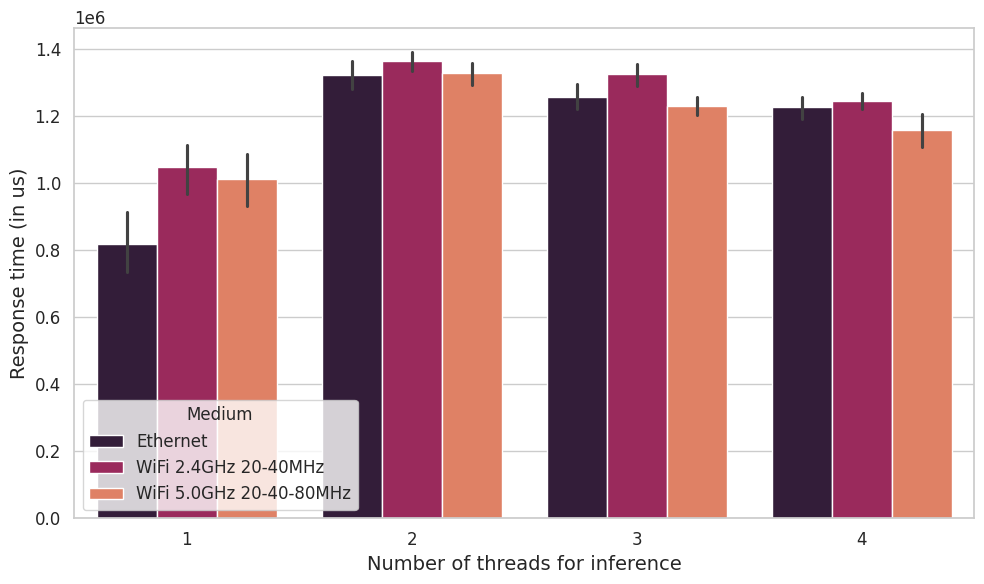

In [149]:
df_exec_time = pd.read_csv(exp_dir + "/execution_time_by_parts.csv")
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

for imp in implementations:
    df_exec_time_imp = df_exec_time[df_exec_time["Implementation"] == imp]
    df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
    df_cpu_usage_imp = df_cpu_usage[df_cpu_usage["Implementation"] == imp]
    df_ram_usage_imp = df_ram_usage[df_ram_usage["Implementation"] == imp]

    df_exec_time_imp_med = df_exec_time_imp.groupby(["Medium"])

    medium_group = df_exec_time_imp.groupby("Medium")

    colors = sns.color_palette('rocket')[0::2]
    
    hue_order = np.sort(df_exec_time_imp["Medium"].unique())

    
    # Generate unique colors for each part
    # colors = plt.cm.viridis([i / float(len(part_order)) for i in range(len(part_order))])

    # item = item[["Inference Threads", "Part", "Execution Time (in us)"]]
    item = df_exec_time_imp[df_exec_time_imp["Part"] == "Real time"]

    
    
    # Barplot comparison
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    sns.barplot(data=item, x='Inference Threads', y='Execution Time (in us)', hue="Medium", hue_order=hue_order, palette=colors)

    plt.xlabel("Number of threads for inference")
    plt.ylabel("Response time (in us)")
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show

    plt.savefig(graphs_exec_time_dir + "/barplot_evolution_threads_" + experiment_name.replace(' ', '_') + "_" + imp + "_overall" + ".pdf")

    # for med, item in medium_group:
    #     item = item[["Inference Threads", "Part", "Execution Time (in us)"]]
    #     item = item[item["Part"] == "Real time"]
    #     # Barplot comparison
    #     plt.figure(figsize=(10, 6))
    #     sns.set_style("whitegrid")
    #     sns.barplot(data=item, x='Inference Threads', y='Execution Time (in us)', palette=colors)

    #     plt.xlabel("Number of threads for inference")
    #     plt.ylim(bottom=0)
    #     plt.tight_layout()
    #     plt.show
    
    #     plt.savefig(graphs_exec_time_dir + "/barplot_evolution_threads_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")


In [ ]:
df_exec_time = pd.read_csv(exp_dir + "/execution_time_by_parts.csv")
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

for imp in implementations:
    df_exec_time_imp = df_exec_time[df_exec_time["Implementation"] == imp]
    df_exec_time_imp = df_exec_time_imp[((df_exec_time_imp["Subpart"] != "Global time") | (df_exec_time_imp["Part"] == "Real time")) & (df_exec_time_imp["Subpart"] != "Run inference") & (df_exec_time_imp["Subpart"] != "Average invokation time per loop")]
    df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
    df_cpu_usage_imp = df_cpu_usage[df_cpu_usage["Implementation"] == imp]
    df_ram_usage_imp = df_ram_usage[df_ram_usage["Implementation"] == imp]

    df_exec_time_imp_med = df_exec_time_imp.groupby(["Medium"])

    medium_group = df_exec_time_imp.groupby("Medium")

    colors = sns.color_palette('rocket')[::-1]
    # Generate unique colors for each part
    # colors = plt.cm.viridis([i / float(len(part_order)) for i in range(len(part_order))])

    for med, item in medium_group:
        plt.figure(figsize=(10, 6))
    
        plt.savefig(graphs_exec_time_dir + "/barplot_global_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")


## Experiment 3: Analysis of the evolution of the execution time of each important part of the TensorFlow Lite application for classical setup with various image sizes.

In [ ]:
# Experiment setup
experiment_name = "Evolution of execution time with image sizes"
timestamp = timestamp=datetime.datetime.now() # Current timestamp

iteration = 20
ssh_info = "pptc@192.168.88.3"
ssh_ip = "192.168.88.3"
implementations = ["label_image", "label_image_with_crow"]
mediums = ["WiFi 2.4GHz 20-40MHz", "WiFi 5.0GHz 20-40-80MHz", "Ethernet"]
images = [1, 2, 3, 4]
count_for_usage_script = 30 # correspond to the number of measure taken (1 per second)# Experiment setup

### Perform experiment

In [ ]:
# Experiment path
exp_folder_name = experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_folder_name = experiment_name.replace(' ', '_') + "_Final"
curr_exp_dir = global_res_dir + "/" + exp_folder_name

# Remote path
remote_exp_results_dir = "~/" + exp_folder_name + "/results"
remote_exp_cpu_usage_dir = remote_exp_results_dir + "/cpu_usage"
remote_exp_ram_usage_dir = remote_exp_results_dir + "/ram_usage"
remote_exp_scripts_dir = "~/" + exp_folder_name + "/scripts"

# Copy scripts on remote device
!{ssh_with_args} {ssh_info} "mkdir -p ~/{exp_folder_name}"
!{scp_with_args} -r scripts/ {ssh_info}:~/{exp_folder_name}

# Perform the experiment
for imp in implementations:
    imp_mediums = ["na"] if imp == "label_image" else mediums

    # Copy needed assets (executable and images)
    print(f"Copy assets for {imp} on remote device")
    !{scp_with_args} -r {assets_path}/{imp} {ssh_info}:~/{exp_folder_name}/{imp}

    for med in imp_mediums:
        # Validate config:
        print(f"Prepare next config:\n\tImplementation: {imp}\n\tMedium: {med}\n\t\n")
        time.sleep(2)
        v = input("Press ENTER to run the benchmark")
        print(f"Value : {v}")
        if v == "s": # stop
            break
        print("Run benchmark...")

        # Create remote workspace
        !{ssh_with_args} {ssh_info} "mkdir -p {remote_exp_cpu_usage_dir}; mkdir -p {remote_exp_ram_usage_dir}"

        # Implementation paths
        curr_exp_imp_dir = curr_exp_dir + "/" + imp.replace(' ', '_')
        curr_exp_imp_med_dir = curr_exp_imp_dir + ("/" + med.replace(' ', '_') if med != "na" else "")
        curr_exp_imp_raw_dir = curr_exp_imp_med_dir + "/raw_results"
        curr_exp_imp_res_dir = curr_exp_imp_med_dir + "/results"
        curr_exp_imp_raw_file = curr_exp_imp_raw_dir + "/execution_time_by_part.txt"

        # Create results dir
        path = Path(curr_exp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_raw_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Print experiment setup in results file
        # Local for execution time
        with open(curr_exp_imp_raw_file, "w") as raw:
            raw.write(f"# SSH_INFO={ssh_info}\n")
            raw.write(f"# ITERATIONS={iteration}\n")
            raw.write(f"# IMPLEMENTATION={imp}\n")
            raw.write(f"# MEDIUM={med}\n")

        for t in n_threads:
            with open(curr_exp_imp_raw_file, "a") as raw:
                raw.write(f"\n# THREADS {t}\n")

            # Remote paths
            cpu_usage_remote_file = remote_exp_cpu_usage_dir + "/results_cpu_usage_" + imp + "_" + med.replace(' ', '_') + "_" + str(t) + ".txt"
            ram_usage_remote_file = remote_exp_ram_usage_dir + "/results_ram_usage_" + imp + "_" + med.replace(' ', '_') + "_" + str(t) + ".txt"

            # Remote for cpu and ram usage
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# THREADS={t}\n# COUNT={count_for_usage_script}\n\" > {cpu_usage_remote_file}"
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# THREADS={t}\n# COUNT={count_for_usage_script}\n\" > {ram_usage_remote_file}"

            # Perform test
            for i in range(iteration):
                # Print iteration
                print(f"Iteration {i}")
                with open(curr_exp_imp_raw_file, "a") as raw:
                    raw.write(f"\n# ITERATION {i}\n")
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {cpu_usage_remote_file}"
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {ram_usage_remote_file}"

                # Run cpu and ram usage script
                print("Start CPU and RAM usage scripts")
                
                cpu_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/cpu_usage_script.sh {count_for_usage_script} {cpu_usage_remote_file} 0"', shell=True)
                ram_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/ram_usage_script.sh {count_for_usage_script} {ram_usage_remote_file} 0"', shell=True)

                print("Sleep 3s")
                time.sleep(3) # To have more usage measures

                
                print("Perform measure")
                if imp == "label_image":
                    start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                    !{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; (time ./{imp} -m mobilenet_v1_1.0_224.tflite -l labels.txt -i grace_hopper.bmp --num_threads {t} -d 1 -w 0)" &>> {curr_exp_imp_raw_file}

                    stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                else:
                    server_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; ./{imp} -c config.json -t {t}"', shell=True)
                    time.sleep(3)
                    
                    start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                    !(time curl -X POST -F "image=@{assets_path}/label_image_with_crow/grace_hopper.bmp" http://{ssh_ip}:18080/label_image) &>> {curr_exp_imp_raw_file}

                    stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                    
                    # Kill server
                    print("Kill server")
                    server_process.kill()
                    !{ssh_with_args} {ssh_info} 'kill $(pidof {imp})'


                print("Sleep 3s")
                time.sleep(3)  # To have more usage measures

                print("Kill CPU and RAM usage scripts")
                cpu_usage_process.kill()
                ram_usage_process.kill()
                !{ssh_with_args} {ssh_info} 'kill $(pidof cpu_usage_script.sh)'
                !{ssh_with_args} {ssh_info} 'kill $(pidof ram_usage_script.sh)'

                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {cpu_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {cpu_usage_remote_file}"
                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {ram_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {ram_usage_remote_file}"

        print("Retrieve usage results and remove remote workspace")
        !{scp_with_args} -r {ssh_info}:{remote_exp_cpu_usage_dir} {curr_exp_imp_raw_dir}
        !{scp_with_args} -r {ssh_info}:{remote_exp_ram_usage_dir} {curr_exp_imp_raw_dir}

        !{ssh_with_args} {ssh_info} "rm -rf {remote_exp_cpu_usage_dir}; rm -rf {remote_exp_ram_usage_dir}"

# Remove remote workspace
!{ssh_with_args} {ssh_info} "rm -rf ~/{exp_folder_name}"

### Process results

In [ ]:
def process_part_execution_time_raw_results_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    parts = []
    subparts = []
    values = []
    iterations = []
    n_threads = []

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                iterations.append(int(line.split(' ')[2].strip()))
            elif line.startswith("# THREADS"):
                n_threads.append(int(line.split(' ')[2].strip()))
            elif line.startswith("TIME: "):
                _, part, subpart, value = line.split(':')
                value = float(value.strip().split(' ')[0].strip())
                parts.append(part.strip())
                subparts.append(subpart.strip())
                values.append(value)
            elif line.startswith("real"):
                min_sec_ms = line.strip().split('\t')[1]
                min, sec_ms = min_sec_ms.split('m')
                min = int(min.strip())
                sec_ms = float(sec_ms.strip()[:-1])
                parts.append("Real time")
                subparts.append("Global time")
                values.append(((min * 60) + sec_ms) * 1000000)


    n_repeat = len(parts)//len(iterations)
    iterations = [iterations[i//n_repeat] for i in range(len(iterations) * n_repeat)]
    n_iter = len(iterations) // len(n_threads)
    n_threads = [n_threads[i//n_iter] for i in range(len(iterations))]
    df["Iteration"] = iterations
    df["Inference Threads"] = n_threads
    df["Part"] = parts
    df["Subpart"] = subparts
    df["Execution Time (in us)"] = values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]

    df["Part"] = df["Part"].replace("Crow", "Crow Webserver")

    return df

def process_cpu_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""
    n_threads=0

    timestamp_values = []
    user_values = []
    nice_values = []
    system_values = []
    idle_values = []
    iowait_values = []
    irq_values = []
    softirq_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# THREADS="):
                n_threads = int(line.split('=')[1].strip())
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, user_v, nice_v, system_v, idle_v, iowait_v, irq_v, softirq_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                user_values.append(float(user_v.strip()))
                nice_values.append(float(nice_v.strip()))
                system_values.append(float(system_v.strip()))
                idle_values.append(float(idle_v.strip()))
                iowait_values.append(float(iowait_v.strip()))
                irq_values.append(float(irq_v.strip()))
                softirq_values.append(float(softirq_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Inference Threads"] = [n_threads] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["User"] = user_values
    df["Nice"] = nice_values
    df["System"] = system_values
    df["Idle"] = idle_values
    df["IOwait"] = iowait_values
    df["IRQ"] = irq_values
    df["SoftIRQ"] = softirq_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute CPU usage and Timestamp from 0
    df['Total'] = df[["User", "Nice", "System", "Idle", "IOwait", "IRQ", "SoftIRQ"]].sum(axis=1)
    
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])

        group['Last Idle'] = group['Idle'].shift(1).fillna(0)
        group['Last Total'] = group['Total'].shift(1).fillna(0)
        group['Idle Delta'] = group['Idle'] - group['Last Idle']
        group['Total Delta'] = group['Total'] - group['Last Total']
        group['Usage'] = 100.0 * (1.0 - (group['Idle Delta'] / group['Total Delta']))

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df.drop(["Total"], axis="columns")


def process_ram_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""
    n_threads=0

    timestamp_values = []
    memtotal_values = []
    memfree_values = []
    memavailable_values = []
    cache_values = []
    buffer_values = []
    swaptotal_values = []
    swapfree_values = []
    swapcached_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# THREADS="):
                n_threads = int(line.split('=')[1].strip())
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, memtotal_v, memfree_v, memavailable_v, cache_v, buffer_v, swaptotal_v, swapfree_v, swapcached_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                memtotal_values.append(float(memtotal_v.strip()))
                memfree_values.append(float(memfree_v.strip()))
                memavailable_values.append(float(memavailable_v.strip()))
                cache_values.append(float(cache_v.strip()))
                buffer_values.append(float(buffer_v.strip()))
                swaptotal_values.append(float(swaptotal_v.strip()))
                swapfree_values.append(float(swapfree_v.strip()))
                swapcached_values.append(float(swapcached_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Inference Threads"] = [n_threads] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["Total Memory"] = memtotal_values
    df["Free Memory"] = memfree_values
    df["Available Memory"] = memavailable_values
    df["Cache"] = cache_values
    df["Buffer"] = buffer_values
    df["Total Swap"] = swaptotal_values
    df["Free Swap"] = swapfree_values
    df["Cached Swap"] = swapcached_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute RAM usage and Timestamp from 0
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])
        group["Usage"] = (1 - (group["Free Memory"]/group["Total Memory"])) * 100.0

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df


In [ ]:
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

df_execution_time_by_part = []
df_cpu_usages = []
df_ram_usages= []

for imp in implementations:
    exp_imp_dir = exp_dir + "/" + imp
    imp_mediums = ["na"] if imp == "label_image" else mediums
    for med in imp_mediums:
        exp_imp_med_dir = exp_imp_dir + (("/" + med.replace(' ', '_')) if imp != "label_image" else "")
        exp_imp_med_raw_dir = exp_imp_med_dir + "/raw_results"
        exp_cpu_imp_med_raw_dir = exp_imp_med_raw_dir + "/cpu_usage"
        exp_ram_imp_med_raw_dir = exp_imp_med_raw_dir + "/ram_usage"
        exp_imp_med_res_dir = exp_imp_med_dir + "/results"

        path = Path(exp_imp_med_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Execution time by part
        df_execution_time_by_part_imp_med = process_part_execution_time_raw_results_to_dataframe(exp_imp_med_raw_dir + "/execution_time_by_part.txt")
        df_execution_time_by_part.append(df_execution_time_by_part_imp_med)
        df_execution_time_by_part_imp_med.to_csv(exp_imp_med_res_dir + "/execution_time_by_parts_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

        # CPU usage
        df_cpu_usages_med = []
        for file in os.listdir(exp_cpu_imp_med_raw_dir):
            df_cpu_usages_med.append(process_cpu_usage_to_dataframe(exp_cpu_imp_med_raw_dir + "/" + file))
        df_cpu_usages_med = pd.concat(df_cpu_usages_med, ignore_index=True)
        df_cpu_usages.append(df_cpu_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/cpu_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)


        # RAM usage
        df_ram_usages_med = []
        for file in os.listdir(exp_ram_imp_med_raw_dir):
            df_ram_usages_med.append(process_ram_usage_to_dataframe(exp_ram_imp_med_raw_dir + "/" + file))
        df_ram_usages_med = pd.concat(df_ram_usages_med, ignore_index=True)
        df_ram_usages.append(df_ram_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/ram_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

# Execution time by part
df_execution_time_by_part = pd.concat(df_execution_time_by_part, ignore_index=True)
df_execution_time_by_part.to_csv(exp_dir + "/execution_time_by_parts.csv", index=False)

# CPU usage
df_cpu_usages = pd.concat(df_cpu_usages, ignore_index=True)
df_cpu_usages.to_csv(exp_dir + "/cpu_usage.csv", index=False)

# RAM usage
df_ram_usages = pd.concat(df_ram_usages, ignore_index=True)
df_ram_usages.to_csv(exp_dir + "/ram_usage.csv", index=False)

# display(df_execution_time_by_part)
# display(df_cpu_usages)
# display(df_ram_usages)

### Make Graphs

In [ ]:
# Global variables
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

graphs_dir = exp_dir + "/graphs"
graphs_exec_time_dir = graphs_dir + "/execution_time_by_part"
graphs_cpu_usage_dir = graphs_dir + "/cpu_usage"
graphs_ram_usage_dir = graphs_dir + "/ram_usage"

path = Path(graphs_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_exec_time_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_cpu_usage_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_ram_usage_dir)
path.mkdir(parents=True, exist_ok=True)


In [ ]:
df_exec_time = pd.read_csv(exp_dir + "/execution_time_by_parts.csv")
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

for imp in implementations:
    df_exec_time_imp = df_exec_time[df_exec_time["Implementation"] == imp]
    df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
    df_cpu_usage_imp = df_cpu_usage[df_cpu_usage["Implementation"] == imp]
    df_ram_usage_imp = df_ram_usage[df_ram_usage["Implementation"] == imp]

    df_exec_time_imp_med = df_exec_time_imp.groupby(["Medium"])

    medium_group = df_exec_time_imp.groupby("Medium")

    colors = sns.color_palette('rocket')[::-1]

    
    # Generate unique colors for each part
    # colors = plt.cm.viridis([i / float(len(part_order)) for i in range(len(part_order))])

    for med, item in medium_group:
        item = item[["Inference Threads", "Part", "Execution Time (in us)"]]
        item = item[item["Part"] == "Real time"]
        # Barplot comparison
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        sns.barplot(data=item, x='Inference Threads', y='Execution Time (in us)', palette=colors)

        plt.xlabel("Number of threads for inference")
        plt.ylim(bottom=0)
        plt.tight_layout()
        plt.show
    
        plt.savefig(graphs_exec_time_dir + "/barplot_evolution_threads_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")


## Experiment 4: Evolution of the number of requests per seconde with the number of server threads

In [138]:
# Experiment setup
experiment_name = "Evolution of request per sec with server threads"
timestamp = timestamp=datetime.datetime.now() # Current timestamp

iteration = 20
ssh_info = "pptc@192.168.88.3"
ssh_ip = "192.168.88.3"
implementations = ["label_image_with_crow"]
mediums = ["WiFi 2.4GHz 20-40MHz", "WiFi 5.0GHz 20-40-80MHz", "Ethernet"]
n_threads = [2, 3, 4]

wrk_threads = 8
wrk_connections_by_device = 10
wrk_duration = "20s"
wrk_lua_script = "./assets/wrk/generate_request_script.lua"
cluster_port = 18080

count_for_usage_script = 30 # correspond to the number of measure taken (1 per second)# Experiment setup

In [14]:
# Experiment path
exp_folder_name = experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
# exp_folder_name = experiment_name.replace(' ', '_') + "_Final"
curr_exp_dir = global_res_dir + "/" + exp_folder_name

# Remote path
remote_exp_results_dir = "~/" + exp_folder_name + "/results"
remote_exp_cpu_usage_dir = remote_exp_results_dir + "/cpu_usage"
remote_exp_ram_usage_dir = remote_exp_results_dir + "/ram_usage"
remote_exp_scripts_dir = "~/" + exp_folder_name + "/scripts"

# Copy scripts on remote device
!{ssh_with_args} {ssh_info} "mkdir -p ~/{exp_folder_name}"
!{scp_with_args} -r scripts/ {ssh_info}:~/{exp_folder_name}

# Perform the experiment
for imp in implementations:
    imp_mediums = ["na"] if imp == "label_image" else mediums

    # Copy needed assets (executable and images)
    print(f"Copy assets for {imp} on remote device")
    !{scp_with_args} -r {assets_path}/{imp} {ssh_info}:~/{exp_folder_name}/{imp}

    for med in imp_mediums:
        # Validate config:
        print(f"Prepare next config:\n\tImplementation: {imp}\n\tMedium: {med}\n\t\n")
        time.sleep(2)
        v = input("Press ENTER to run the benchmark")
        print(f"Value : {v}")
        if v == "s": # stop
            break
        print("Run benchmark...")

        # Create remote workspace
        !{ssh_with_args} {ssh_info} "mkdir -p {remote_exp_cpu_usage_dir}; mkdir -p {remote_exp_ram_usage_dir}"

        # Implementation paths
        curr_exp_imp_dir = curr_exp_dir + "/" + imp.replace(' ', '_')
        curr_exp_imp_med_dir = curr_exp_imp_dir + ("/" + med.replace(' ', '_') if med != "na" else "")
        curr_exp_imp_raw_dir = curr_exp_imp_med_dir + "/raw_results"
        curr_exp_imp_res_dir = curr_exp_imp_med_dir + "/results"
        curr_exp_imp_raw_file = curr_exp_imp_raw_dir + "/request_per_sec.txt"

        # Create results dir
        path = Path(curr_exp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_raw_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Print experiment setup in results file
        # Local for execution time
        with open(curr_exp_imp_raw_file, "w") as raw:
            raw.write(f"# SSH_INFO={ssh_info}\n")
            raw.write(f"# ITERATIONS={iteration}\n")
            raw.write(f"# IMPLEMENTATION={imp}\n")
            raw.write(f"# MEDIUM={med}\n")

        for t in n_threads:
            with open(curr_exp_imp_raw_file, "a") as raw:
                raw.write(f"\n# THREADS {t}\n")

            # Remote paths
            cpu_usage_remote_file = remote_exp_cpu_usage_dir + "/results_cpu_usage_" + imp + "_" + med.replace(' ', '_') + "_" + str(t) + ".txt"
            ram_usage_remote_file = remote_exp_ram_usage_dir + "/results_ram_usage_" + imp + "_" + med.replace(' ', '_') + "_" + str(t) + ".txt"

            # Remote for cpu and ram usage
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# THREADS={t}\n# COUNT={count_for_usage_script}\n\" > {cpu_usage_remote_file}"
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# THREADS={t}\n# COUNT={count_for_usage_script}\n\" > {ram_usage_remote_file}"

            # Perform test
            for i in range(iteration):
                # Print iteration
                print(f"Iteration {i}")
                with open(curr_exp_imp_raw_file, "a") as raw:
                    raw.write(f"\n# ITERATION {i}\n")
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {cpu_usage_remote_file}"
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {ram_usage_remote_file}"

                # Run cpu and ram usage script
                print("Start CPU and RAM usage scripts")
                
                cpu_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/cpu_usage_script.sh {count_for_usage_script} {cpu_usage_remote_file} 0"', shell=True)
                ram_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/ram_usage_script.sh {count_for_usage_script} {ram_usage_remote_file} 0"', shell=True)

                print("Sleep 3s")
                time.sleep(3) # To have more usage measures

                
                print("Perform measure")
                if imp == "label_image":
                    start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                    !{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; (time ./{imp} -m mobilenet_v1_1.0_224.tflite -l labels.txt -i grace_hopper.bmp --num_threads {t} -d 1 -w 0)" &>> {curr_exp_imp_raw_file}

                    stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                else:
                    server_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; ./{imp} -c config.json -s {t}"', shell=True)
                    time.sleep(3)
                    
                    start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                    command = f"wrk -t {wrk_threads} -c {wrk_connections_by_device} -d {wrk_duration} -s {wrk_lua_script} http://{ssh_info}:{cluster_port}/label_image"
                    result = subprocess.run(command, shell=True, capture_output=True, text=True)
                    with open(curr_exp_imp_raw_file, "a") as raw:
                        raw.write(result.stdout)

                    stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                    
                    # Kill server
                    print("Kill server")
                    server_process.kill()
                    !{ssh_with_args} {ssh_info} 'kill $(pidof {imp})'


                print("Sleep 3s")
                time.sleep(3)  # To have more usage measures

                print("Kill CPU and RAM usage scripts")
                cpu_usage_process.kill()
                ram_usage_process.kill()
                !{ssh_with_args} {ssh_info} 'kill $(pidof cpu_usage_script.sh)'
                !{ssh_with_args} {ssh_info} 'kill $(pidof ram_usage_script.sh)'

                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {cpu_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {cpu_usage_remote_file}"
                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {ram_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {ram_usage_remote_file}"

        print("Retrieve usage results and remove remote workspace")
        !{scp_with_args} -r {ssh_info}:{remote_exp_cpu_usage_dir} {curr_exp_imp_raw_dir}
        !{scp_with_args} -r {ssh_info}:{remote_exp_ram_usage_dir} {curr_exp_imp_raw_dir}

        !{ssh_with_args} {ssh_info} "rm -rf {remote_exp_cpu_usage_dir}; rm -rf {remote_exp_ram_usage_dir}"

# Remove remote workspace
!{ssh_with_args} {ssh_info} "rm -rf ~/{exp_folder_name}"

INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:14:32) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:14:32) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.


(2024-08-18 15:14:35) [INFO    ] Request: 192.168.88.200:54330 0xb5c58ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:14:36) [INFO    ] Response: 0xb5c58ab0 /label_image 200 0
(2024-08-18 15:14:36) [INFO    ] Request: 192.168.88.200:54324 0xb5c56210 HTTP/1.1 POST /label_image
(2024-08-18 15:14:36) [INFO    ] Response: 0xb5c56210 /label_image 200 0
(2024-08-18 15:14:36) [INFO    ] Request: 192.168.88.200:54314 0xb5c57740 HTTP/1.1 POST /label_image
(2024-08-18 15:14:37) [INFO    ] Response: 0xb5c57740 /label_image 200 0
(2024-08-18 15:14:37) [INFO    ] Request: 192.168.88.200:54346 0xb56cc0a0 HTTP/1.1 POST /label_image
(2024-08-18 15:14:38) [INFO    ] Response: 0xb56cc0a0 /label_image 200 0
(2024-08-18 15:14:38) [INFO    ] Request: 192.168.88.200:54358 0xb56cd630 HTTP/1.1 POST /label_image
(2024-08-18 15:14:38) [INFO    ] Response: 0xb56cd630 /label_image 200 0
(2024-08-18 15:14:38) [INFO    ] Request: 192.168.88.200:54372 0xb56cebe0 HTTP/1.1 POST /label_image
(2024-08-18 15:14:39) [INFO  

Kill server
Sleep 3s


(2024-08-18 15:14:55) [INFO    ] Response: 0xb56cc0a0 /label_image 200 0
(2024-08-18 15:14:55) [INFO    ] Request: 192.168.88.200:54358 0xb56cd630 HTTP/1.1 POST /label_image
(2024-08-18 15:14:55) [INFO    ] Closing IO service 0xb5c43850
(2024-08-18 15:14:55) [INFO    ] Closing main IO service (0xb5c444dc)
(2024-08-18 15:14:55) [INFO    ] Exiting.
(2024-08-18 15:14:56) [INFO    ] Response: 0xb56cd630 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:15:05) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:15:05) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:15:08) [INFO    ] Request: 192.168.88.200:46762 0xb5c8bab0 HTTP/1.1 POST /label_image
(2024-08-18 15:15:08) [INFO    ] Response: 0xb5c8bab0 /label_image 200 0
(2024-08-18 15:15:08) [INFO    ] Request: 192.168.88.200:46746 0xb5c89210 HTTP/1.1 POST /label_image
(2024-08-18 15:15:09) [INFO    ] Response: 0xb5c89210 /label_image 200 0
(2024-08-18 15:15:09) [INFO    ] Request: 192.168.88.200:46778 0xb56ff090 HTTP/1.1 POST /label_image
(2024-08-18 15:15:09) [INFO    ] Response: 0xb56ff090 /label_image 200 0
(2024-08-18 15:15:09) [INFO    ] Request: 192.168.88.200:46742 0xb5c8a740 HTTP/1.1 POST /label_image
(2024-08-18 15:15:10) [INFO    ] Response: 0xb5c8a740 /label_image 200 0
(2024-08-18 15:15:10) [IN

Kill server
Sleep 3s


(2024-08-18 15:15:28) [INFO    ] Closing IO service 0xb5c76850
(2024-08-18 15:15:28) [INFO    ] Closing main IO service (0xb5c774dc)
(2024-08-18 15:15:28) [INFO    ] Exiting.
(2024-08-18 15:15:28) [INFO    ] Response: 0xb5c89210 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:15:37) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:15:37) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:15:40) [INFO    ] Request: 192.168.88.200:56508 0xb5d48210 HTTP/1.1 POST /label_image
(2024-08-18 15:15:41) [INFO    ] Response: 0xb5d48210 /label_image 200 0
(2024-08-18 15:15:41) [INFO    ] Request: 192.168.88.200:56512 0xb5d4aab0 HTTP/1.1 POST /label_image
(2024-08-18 15:15:42) [INFO    ] Response: 0xb5d4aab0 /label_image 200 0
(2024-08-18 15:15:42) [INFO    ] Request: 192.168.88.200:56502 0xb5d49740 HTTP/1.1 POST /label_image
(2024-08-18 15:15:43) [INFO    ] Response: 0xb5d49740 /label_image 200 0
(2024-08-18 15:15:43) [INFO    ] Request: 192.168.88.200:56514 0xb57be0a0 HTTP/1.1 POST /label_image
(2024-08-18 15:15:44) [INFO    ] Response: 0xb57be0a0 /label_image 200 0
(2024-08-18 15:15:44) [IN

Kill server


(2024-08-18 15:16:00) [INFO    ] Response: 0xb57bf640 /label_image 200 0
(2024-08-18 15:16:00) [INFO    ] Request: 192.168.88.200:56536 0xb57c0be0 HTTP/1.1 POST /label_image
(2024-08-18 15:16:00) [INFO    ] Closing IO service 0xb5d35850
(2024-08-18 15:16:00) [INFO    ] Closing main IO service (0xb5d364dc)
(2024-08-18 15:16:00) [INFO    ] Exiting.


Sleep 3s


(2024-08-18 15:16:00) [INFO    ] Response: 0xb57c0be0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:16:09) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:16:09) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:16:12) [INFO    ] Request: 192.168.88.200:36204 0xb5c97210 HTTP/1.1 POST /label_image
(2024-08-18 15:16:13) [INFO    ] Response: 0xb5c97210 /label_image 200 0
(2024-08-18 15:16:13) [INFO    ] Request: 192.168.88.200:36206 0xb5c99ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:16:14) [INFO    ] Response: 0xb5c99ab0 /label_image 200 0
(2024-08-18 15:16:14) [INFO    ] Request: 192.168.88.200:36188 0xb5c98740 HTTP/1.1 POST /label_image
(2024-08-18 15:16:15) [INFO    ] Response: 0xb5c98740 /label_image 200 0
(2024-08-18 15:16:15) [INFO    ] Request: 192.168.88.200:36212 0xb570d0a0 HTTP/1.1 POST /label_image
(2024-08-18 15:16:16) [INFO    ] Response: 0xb570d0a0 /label_image 200 0
(2024-08-18 15:16:16) [IN

Kill server
Sleep 3s


(2024-08-18 15:16:32) [INFO    ] Closing IO service 0xb5c84850
(2024-08-18 15:16:32) [INFO    ] Closing main IO service (0xb5c854dc)
(2024-08-18 15:16:32) [INFO    ] Exiting.
(2024-08-18 15:16:33) [INFO    ] Response: 0xb570e640 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:16:42) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:16:42) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:16:45) [INFO    ] Request: 192.168.88.200:42018 0xb5c9a210 HTTP/1.1 POST /label_image
(2024-08-18 15:16:46) [INFO    ] Response: 0xb5c9a210 /label_image 200 0
(2024-08-18 15:16:46) [INFO    ] Request: 192.168.88.200:42048 0xb5712bb0 HTTP/1.1 POST /label_image
(2024-08-18 15:16:47) [INFO    ] Response: 0xb5712bb0 /label_image 200 0
(2024-08-18 15:16:47) [INFO    ] Request: 192.168.88.200:42026 0xb5c9cab0 HTTP/1.1 POST /label_image
(2024-08-18 15:16:48) [INFO    ] Response: 0xb5c9cab0 /label_image 200 0
(2024-08-18 15:16:48) [INFO    ] Request: 192.168.88.200:42042 0xb57100b0 HTTP/1.1 POST /label_image
(2024-08-18 15:16:49) [INFO    ] Response: 0xb57100b0 /label_image 200 0
(2024-08-18 15:16:49) [IN

Kill server
Sleep 3s


(2024-08-18 15:17:05) [INFO    ] Closing IO service 0xb5c87660
(2024-08-18 15:17:05) [INFO    ] Closing main IO service (0xb5c884dc)
(2024-08-18 15:17:05) [INFO    ] Exiting.
(2024-08-18 15:17:05) [INFO    ] Response: 0xb57115f0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:17:14) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:17:14) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:17:17) [INFO    ] Request: 192.168.88.200:59566 0xb5d00ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:17:18) [INFO    ] Response: 0xb5d00ab0 /label_image 200 0
(2024-08-18 15:17:18) [INFO    ] Request: 192.168.88.200:59554 0xb5cfe210 HTTP/1.1 POST /label_image
(2024-08-18 15:17:19) [INFO    ] Response: 0xb5cfe210 /label_image 200 0
(2024-08-18 15:17:19) [INFO    ] Request: 192.168.88.200:59548 0xb5cff740 HTTP/1.1 POST /label_image
(2024-08-18 15:17:20) [INFO    ] Response: 0xb5cff740 /label_image 200 0
(2024-08-18 15:17:20) [INFO    ] Request: 192.168.88.200:59598 0xb5776bf0 HTTP/1.1 POST /label_image
(2024-08-18 15:17:21) [INFO    ] Response: 0xb5776bf0 /label_image 200 0
(2024-08-18 15:17:21) [IN

Kill server
Sleep 3s


(2024-08-18 15:17:37) [INFO    ] Closing IO service 0xb5ceb850
(2024-08-18 15:17:37) [INFO    ] Closing main IO service (0xb5cec4dc)
(2024-08-18 15:17:37) [INFO    ] Exiting.
(2024-08-18 15:17:38) [INFO    ] Response: 0xb5775650 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:17:47) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:17:47) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:17:50) [INFO    ] Request: 192.168.88.200:45070 0xb5cda210 HTTP/1.1 POST /label_image
(2024-08-18 15:17:51) [INFO    ] Response: 0xb5cda210 /label_image 200 0
(2024-08-18 15:17:51) [INFO    ] Request: 192.168.88.200:45084 0xb5cdcaa0 HTTP/1.1 POST /label_image
(2024-08-18 15:17:52) [INFO    ] Response: 0xb5cdcaa0 /label_image 200 0
(2024-08-18 15:17:52) [INFO    ] Request: 192.168.88.200:45062 0xb5cdb740 HTTP/1.1 POST /label_image
(2024-08-18 15:17:53) [INFO    ] Response: 0xb5cdb740 /label_image 200 0
(2024-08-18 15:17:53) [INFO    ] Request: 192.168.88.200:45096 0xb57500a0 HTTP/1.1 POST /label_image
(2024-08-18 15:17:54) [INFO    ] Response: 0xb57500a0 /label_image 200 0
(2024-08-18 15:17:54) [IN

Kill server
Sleep 3s


(2024-08-18 15:18:10) [INFO    ] Closing IO service 0xb5cc7850
(2024-08-18 15:18:10) [INFO    ] Closing main IO service (0xb5cc84dc)
(2024-08-18 15:18:10) [INFO    ] Exiting.
(2024-08-18 15:18:10) [INFO    ] Response: 0xb5751630 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:18:19) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:18:19) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:18:22) [INFO    ] Request: 192.168.88.200:37868 0xb5ca9ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:18:23) [INFO    ] Response: 0xb5ca9ab0 /label_image 200 0
(2024-08-18 15:18:23) [INFO    ] Request: 192.168.88.200:37856 0xb5ca7210 HTTP/1.1 POST /label_image
(2024-08-18 15:18:24) [INFO    ] Response: 0xb5ca7210 /label_image 200 0
(2024-08-18 15:18:24) [INFO    ] Request: 192.168.88.200:37852 0xb5ca8740 HTTP/1.1 POST /label_image
(2024-08-18 15:18:25) [INFO    ] Response: 0xb5ca8740 /label_image 200 0
(2024-08-18 15:18:25) [INFO    ] Request: 192.168.88.200:37870 0xb57120a0 HTTP/1.1 POST /label_image
(2024-08-18 15:18:26) [INFO    ] Response: 0xb57120a0 /label_image 200 0
(2024-08-18 15:18:26) [IN

Kill server
Sleep 3s


(2024-08-18 15:18:42) [INFO    ] Response: 0xb5714bd0 /label_image 200 0
(2024-08-18 15:18:42) [INFO    ] Request: 192.168.88.200:37882 0xb5713630 HTTP/1.1 POST /label_image
(2024-08-18 15:18:42) [INFO    ] Closing IO service 0xb5c94850
(2024-08-18 15:18:42) [INFO    ] Closing main IO service (0xb5c954dc)
(2024-08-18 15:18:42) [INFO    ] Exiting.
(2024-08-18 15:18:43) [INFO    ] Response: 0xb5713630 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:18:51) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:18:51) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:18:54) [INFO    ] Request: 192.168.88.200:53176 0xb5c91210 HTTP/1.1 POST /label_image
(2024-08-18 15:18:55) [INFO    ] Response: 0xb5c91210 /label_image 200 0
(2024-08-18 15:18:55) [INFO    ] Request: 192.168.88.200:53190 0xb5c93ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:18:56) [INFO    ] Response: 0xb5c93ab0 /label_image 200 0
(2024-08-18 15:18:56) [INFO    ] Request: 192.168.88.200:53166 0xb5c92740 HTTP/1.1 POST /label_image
(2024-08-18 15:18:57) [INFO    ] Response: 0xb5c92740 /label_image 200 0
(2024-08-18 15:18:57) [INFO    ] Request: 192.168.88.200:53206 0xb57070a0 HTTP/1.1 POST /label_image
(2024-08-18 15:18:58) [INFO    ] Response: 0xb57070a0 /label_image 200 0
(2024-08-18 15:18:58) [IN

Kill server
Sleep 3s


(2024-08-18 15:19:14) [INFO    ] Closing IO service 0xb5c7e850
(2024-08-18 15:19:14) [INFO    ] Closing main IO service (0xb5c7f4dc)
(2024-08-18 15:19:14) [INFO    ] Exiting.
(2024-08-18 15:19:15) [INFO    ] Response: 0xb5708630 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:19:24) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:19:24) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:19:27) [INFO    ] Request: 192.168.88.200:33494 0xb5c73210 HTTP/1.1 POST /label_image
(2024-08-18 15:19:28) [INFO    ] Response: 0xb5c73210 /label_image 200 0
(2024-08-18 15:19:28) [INFO    ] Request: 192.168.88.200:33510 0xb5c75ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:19:29) [INFO    ] Response: 0xb5c75ab0 /label_image 200 0
(2024-08-18 15:19:29) [INFO    ] Request: 192.168.88.200:33492 0xb5c74740 HTTP/1.1 POST /label_image
(2024-08-18 15:19:30) [INFO    ] Response: 0xb5c74740 /label_image 200 0
(2024-08-18 15:19:30) [INFO    ] Request: 192.168.88.200:33520 0xb56e90b0 HTTP/1.1 POST /label_image
(2024-08-18 15:19:31) [INFO    ] Response: 0xb56e90b0 /label_image 200 0
(2024-08-18 15:19:31) [IN

Kill server
Sleep 3s


(2024-08-18 15:19:47) [INFO    ] Closing IO service 0xb5c60660
(2024-08-18 15:19:47) [INFO    ] Closing main IO service (0xb5c614dc)
(2024-08-18 15:19:47) [INFO    ] Exiting.
(2024-08-18 15:19:47) [INFO    ] Response: 0xb56ea660 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:19:56) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:19:56) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:19:59) [INFO    ] Request: 192.168.88.200:58214 0xb5c9b210 HTTP/1.1 POST /label_image
(2024-08-18 15:20:00) [INFO    ] Response: 0xb5c9b210 /label_image 200 0
(2024-08-18 15:20:00) [INFO    ] Request: 192.168.88.200:58228 0xb5c9dab0 HTTP/1.1 POST /label_image
(2024-08-18 15:20:01) [INFO    ] Response: 0xb5c9dab0 /label_image 200 0
(2024-08-18 15:20:01) [INFO    ] Request: 192.168.88.200:58206 0xb5c9c740 HTTP/1.1 POST /label_image
(2024-08-18 15:20:02) [INFO    ] Response: 0xb5c9c740 /label_image 200 0
(2024-08-18 15:20:02) [INFO    ] Request: 192.168.88.200:58230 0xb57110b0 HTTP/1.1 POST /label_image
(2024-08-18 15:20:03) [INFO    ] Response: 0xb57110b0 /label_image 200 0
(2024-08-18 15:20:03) [IN

Kill server
Sleep 3s


(2024-08-18 15:20:19) [INFO    ] Closing IO service 0xb5c88850
(2024-08-18 15:20:19) [INFO    ] Closing main IO service (0xb5c894dc)
(2024-08-18 15:20:19) [INFO    ] Exiting.
(2024-08-18 15:20:20) [INFO    ] Response: 0xb5712660 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:20:29) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:20:29) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:20:32) [INFO    ] Request: 192.168.88.200:33892 0xb5cebac0 HTTP/1.1 POST /label_image
(2024-08-18 15:20:33) [INFO    ] Response: 0xb5cebac0 /label_image 200 0
(2024-08-18 15:20:33) [INFO    ] Request: 192.168.88.200:33886 0xb5cea740 HTTP/1.1 POST /label_image
(2024-08-18 15:20:34) [INFO    ] Response: 0xb5cea740 /label_image 200 0
(2024-08-18 15:20:34) [INFO    ] Request: 192.168.88.200:33904 0xb575f0b0 HTTP/1.1 POST /label_image
(2024-08-18 15:20:35) [INFO    ] Response: 0xb575f0b0 /label_image 200 0
(2024-08-18 15:20:35) [INFO    ] Request: 192.168.88.200:33912 0xb5760660 HTTP/1.1 POST /label_image
(2024-08-18 15:20:36) [INFO    ] Response: 0xb5760660 /label_image 200 0
(2024-08-18 15:20:36) [IN

Kill server
Sleep 3s


(2024-08-18 15:20:52) [INFO    ] Closing IO service 0xb5cd6850
(2024-08-18 15:20:52) [INFO    ] Closing main IO service (0xb5cd74dc)
(2024-08-18 15:20:52) [INFO    ] Exiting.
(2024-08-18 15:20:52) [INFO    ] Response: 0xb5761c00 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:21:01) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:21:01) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:21:04) [INFO    ] Request: 192.168.88.200:43892 0xb5cad210 HTTP/1.1 POST /label_image
(2024-08-18 15:21:05) [INFO    ] Response: 0xb5cad210 /label_image 200 0
(2024-08-18 15:21:05) [INFO    ] Request: 192.168.88.200:43896 0xb5cafab0 HTTP/1.1 POST /label_image
(2024-08-18 15:21:06) [INFO    ] Response: 0xb5cafab0 /label_image 200 0
(2024-08-18 15:21:06) [INFO    ] Request: 192.168.88.200:43878 0xb5cae740 HTTP/1.1 POST /label_image
(2024-08-18 15:21:07) [INFO    ] Response: 0xb5cae740 /label_image 200 0
(2024-08-18 15:21:07) [INFO    ] Request: 192.168.88.200:43912 0xb57180b0 HTTP/1.1 POST /label_image
(2024-08-18 15:21:08) [INFO    ] Response: 0xb57180b0 /label_image 200 0
(2024-08-18 15:21:08) [IN

Kill server
Sleep 3s


(2024-08-18 15:21:24) [INFO    ] Closing IO service 0xb5c9a850
(2024-08-18 15:21:24) [INFO    ] Closing main IO service (0xb5c9b4dc)
(2024-08-18 15:21:24) [INFO    ] Exiting.
(2024-08-18 15:21:25) [INFO    ] Response: 0xb5719640 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:21:33) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:21:33) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:21:37) [INFO    ] Request: 192.168.88.200:58992 0xb5728560 HTTP/1.1 POST /label_image
(2024-08-18 15:21:37) [INFO    ] Response: 0xb5728560 /label_image 200 0
(2024-08-18 15:21:37) [INFO    ] Request: 192.168.88.200:58934 0xb5cbd210 HTTP/1.1 POST /label_image
(2024-08-18 15:21:38) [INFO    ] Response: 0xb5cbd210 /label_image 200 0
(2024-08-18 15:21:38) [INFO    ] Request: 192.168.88.200:58950 0xb5cbfaa0 HTTP/1.1 POST /label_image
(2024-08-18 15:21:38) [INFO    ] Response: 0xb5cbfaa0 /label_image 200 0
(2024-08-18 15:21:38) [INFO    ] Request: 192.168.88.200:58952 0xb5733090 HTTP/1.1 POST /label_image
(2024-08-18 15:21:39) [INFO    ] Response: 0xb5733090 /label_image 200 0
(2024-08-18 15:21:39) [IN

Kill server
Sleep 3s


(2024-08-18 15:21:57) [INFO    ] Closing IO service 0xb5caa850
(2024-08-18 15:21:57) [INFO    ] Closing main IO service (0xb5cab4dc)
(2024-08-18 15:21:57) [INFO    ] Exiting.
(2024-08-18 15:21:57) [INFO    ] Response: 0xb5728560 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:22:06) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:22:06) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:22:09) [INFO    ] Request: 192.168.88.200:49704 0xb5d25210 HTTP/1.1 POST /label_image
(2024-08-18 15:22:10) [INFO    ] Response: 0xb5d25210 /label_image 200 0
(2024-08-18 15:22:10) [INFO    ] Request: 192.168.88.200:49720 0xb5d27ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:22:11) [INFO    ] Response: 0xb5d27ab0 /label_image 200 0
(2024-08-18 15:22:11) [INFO    ] Request: 192.168.88.200:49694 0xb5d26740 HTTP/1.1 POST /label_image
(2024-08-18 15:22:12) [INFO    ] Response: 0xb5d26740 /label_image 200 0
(2024-08-18 15:22:12) [INFO    ] Request: 192.168.88.200:49734 0xb579b0a0 HTTP/1.1 POST /label_image
(2024-08-18 15:22:13) [INFO    ] Response: 0xb579b0a0 /label_image 200 0
(2024-08-18 15:22:13) [IN

Kill server
Sleep 3s


(2024-08-18 15:22:29) [INFO    ] Closing IO service 0xb5d12850
(2024-08-18 15:22:29) [INFO    ] Closing main IO service (0xb5d134dc)
(2024-08-18 15:22:29) [INFO    ] Exiting.
(2024-08-18 15:22:29) [INFO    ] Response: 0xb579c630 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:22:38) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 2 threads
(2024-08-18 15:22:38) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:22:41) [INFO    ] Request: 192.168.88.200:51440 0xb5cb7210 HTTP/1.1 POST /label_image
(2024-08-18 15:22:42) [INFO    ] Response: 0xb5cb7210 /label_image 200 0
(2024-08-18 15:22:42) [INFO    ] Request: 192.168.88.200:51454 0xb5cb9ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:22:43) [INFO    ] Response: 0xb5cb9ab0 /label_image 200 0
(2024-08-18 15:22:43) [INFO    ] Request: 192.168.88.200:51436 0xb5cb8740 HTTP/1.1 POST /label_image
(2024-08-18 15:22:43) [INFO    ] Response: 0xb5cb8740 /label_image 200 0
(2024-08-18 15:22:43) [INFO    ] Request: 192.168.88.200:51460 0xb572d0a0 HTTP/1.1 POST /label_image
(2024-08-18 15:22:44) [INFO    ] Response: 0xb572d0a0 /label_image 200 0
(2024-08-18 15:22:44) [IN

Kill server
Sleep 3s


(2024-08-18 15:23:01) [INFO    ] Closing IO service 0xb5ca4850
(2024-08-18 15:23:01) [INFO    ] Closing main IO service (0xb5ca54dc)
(2024-08-18 15:23:01) [INFO    ] Exiting.
(2024-08-18 15:23:01) [INFO    ] Response: 0xb5cb9ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:23:12) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:23:12) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:23:15) [INFO    ] Request: 192.168.88.200:58570 0xb5cb5210 HTTP/1.1 POST /label_image
(2024-08-18 15:23:15) [INFO    ] Request: 192.168.88.200:58584 0xb5cb7ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:23:16) [INFO    ] Response: 0xb5cb5210 /label_image 200 0
(2024-08-18 15:23:16) [INFO    ] Response: 0xb5cb7ab0 /label_image 200 0
(2024-08-18 15:23:16) [INFO    ] Request: 192.168.88.200:58590 0xb5704080 HTTP/1.1 POST /label_image
(2024-08-18 15:23:16) [INFO    ] Request: 192.168.88.200:58604 0xb5705640 HTTP/1.1 POST /label_image
(2024-08-18 15:23:17) [INFO    ] Response: 0xb5705640 /label_image 200 0
(2024-08-18 15:23:17) [INFO    ] Response: 0xb5704080 /label_image 200 0
(2024-08-18 15:23:17) [IN

Kill server


(2024-08-18 15:23:34) [INFO    ] Response: 0xb56fc1a0 /label_image 200 0
(2024-08-18 15:23:34) [INFO    ] Response: 0xb56fd5a0 /label_image 200 0
(2024-08-18 15:23:34) [INFO    ] Request: 192.168.88.200:58584 0xb5cb7ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:23:34) [INFO    ] Request: 192.168.88.200:58570 0xb5cb5210 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:23:35) [INFO    ] Closing IO service 0xb5ca2870
(2024-08-18 15:23:35) [INFO    ] Closing IO service 0xb5ca2874
(2024-08-18 15:23:35) [INFO    ] Closing main IO service (0xb5ca34dc)
(2024-08-18 15:23:35) [INFO    ] Exiting.
(2024-08-18 15:23:35) [INFO    ] Response: 0xb5cb7ab0 /label_image 200 0
(2024-08-18 15:23:35) [INFO    ] Response: 0xb5cb5210 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:23:44) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:23:44) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:23:47) [INFO    ] Request: 192.168.88.200:37038 0xb5ce5210 HTTP/1.1 POST /label_image
(2024-08-18 15:23:47) [INFO    ] Request: 192.168.88.200:37046 0xb5ce7ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:23:48) [INFO    ] Response: 0xb5ce5210 /label_image 200 0
(2024-08-18 15:23:48) [INFO    ] Request: 192.168.88.200:37062 0xb57380b0 HTTP/1.1 POST /label_image
(2024-08-18 15:23:48) [INFO    ] Response: 0xb5ce7ab0 /label_image 200 0
(2024-08-18 15:23:48) [INFO    ] Request: 192.168.88.200:37036 0xb5ce6740 HTTP/1.1 POST /label_image
(2024-08-18 15:23:49) [INFO    ] Response: 0xb57380b0 /label_image 200 0
(2024-08-18 15:23:49) [INFO    ] Request: 192.168.88.200:37086 0xb573abe0 HTTP/1.1 POST /label_ima

Kill server
Sleep 3s


(2024-08-18 15:24:07) [INFO    ] Closing IO service 0xb5cd2680
(2024-08-18 15:24:07) [INFO    ] Closing IO service 0xb5cd2684
(2024-08-18 15:24:07) [INFO    ] Closing main IO service (0xb5cd34dc)
(2024-08-18 15:24:07) [INFO    ] Exiting.
(2024-08-18 15:24:08) [INFO    ] Response: 0xb5ce5210 /label_image 200 0
(2024-08-18 15:24:08) [INFO    ] Response: 0xb5ce7ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:24:17) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:24:17) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:24:19) [INFO    ] Request: 192.168.88.200:53782 0xb5d32210 HTTP/1.1 POST /label_image
(2024-08-18 15:24:20) [INFO    ] Request: 192.168.88.200:53798 0xb5d34ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:24:20) [INFO    ] Response: 0xb5d32210 /label_image 200 0
(2024-08-18 15:24:21) [INFO    ] Response: 0xb5d34ab0 /label_image 200 0
(2024-08-18 15:24:21) [INFO    ] Request: 192.168.88.200:53810 0xb57850b0 HTTP/1.1 POST /label_image
(2024-08-18 15:24:21) [INFO    ] Request: 192.168.88.200:53818 0xb5786640 HTTP/1.1 POST /label_image
(2024-08-18 15:24:22) [INFO    ] Response: 0xb5786640 /label_image 200 0
(2024-08-18 15:24:22) [INFO    ] Response: 0xb57850b0 /label_image 200 0
(2024-08-18 15:24:22) [IN

Kill server


(2024-08-18 15:24:39) [INFO    ] Response: 0xb57850b0 /label_image 200 0
(2024-08-18 15:24:39) [INFO    ] Request: 192.168.88.200:53830 0xb5787bf0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:24:40) [INFO    ] Closing IO service 0xb5d1f870
(2024-08-18 15:24:40) [INFO    ] Closing IO service 0xb5d1f874
(2024-08-18 15:24:40) [INFO    ] Closing main IO service (0xb5d204dc)
(2024-08-18 15:24:40) [INFO    ] Exiting.
(2024-08-18 15:24:40) [INFO    ] Response: 0xb5d34ab0 /label_image 200 0
(2024-08-18 15:24:40) [INFO    ] Response: 0xb5787bf0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:24:49) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:24:49) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:24:52) [INFO    ] Request: 192.168.88.200:33378 0xb5c5b210 HTTP/1.1 POST /label_image
(2024-08-18 15:24:52) [INFO    ] Request: 192.168.88.200:33386 0xb5c5dab0 HTTP/1.1 POST /label_image
(2024-08-18 15:24:53) [INFO    ] Response: 0xb5c5dab0 /label_image 200 0
(2024-08-18 15:24:53) [INFO    ] Response: 0xb5c5b210 /label_image 200 0
(2024-08-18 15:24:53) [INFO    ] Request: 192.168.88.200:33408 0xb56af620 HTTP/1.1 POST /label_image
(2024-08-18 15:24:53) [INFO    ] Request: 192.168.88.200:33394 0xb56ae0a0 HTTP/1.1 POST /label_image
(2024-08-18 15:24:54) [INFO    ] Response: 0xb56af620 /label_image 200 0
(2024-08-18 15:24:54) [INFO    ] Response: 0xb56ae0a0 /label_image 200 0
(2024-08-18 15:24:54) [IN

Kill server


(2024-08-18 15:25:12) [INFO    ] Response: 0xb5c5c740 /label_image 200 0
(2024-08-18 15:25:12) [INFO    ] Response: 0xb56b0bd0 /label_image 200 0
(2024-08-18 15:25:12) [INFO    ] Request: 192.168.88.200:33386 0xb5c5dab0 HTTP/1.1 POST /label_image
(2024-08-18 15:25:12) [INFO    ] Request: 192.168.88.200:33378 0xb5c5b210 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:25:12) [INFO    ] Closing IO service 0xb5c48870
(2024-08-18 15:25:12) [INFO    ] Closing IO service 0xb5c48874
(2024-08-18 15:25:12) [INFO    ] Closing main IO service (0xb5c494dc)
(2024-08-18 15:25:12) [INFO    ] Exiting.
(2024-08-18 15:25:12) [INFO    ] Response: 0xb5c5b210 /label_image 200 0
(2024-08-18 15:25:13) [INFO    ] Response: 0xb5c5dab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:25:21) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:25:21) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:25:24) [INFO    ] Request: 192.168.88.200:54636 0xb5d29210 HTTP/1.1 POST /label_image
(2024-08-18 15:25:24) [INFO    ] Request: 192.168.88.200:54640 0xb5d2bab0 HTTP/1.1 POST /label_image
(2024-08-18 15:25:25) [INFO    ] Response: 0xb5d29210 /label_image 200 0
(2024-08-18 15:25:25) [INFO    ] Request: 192.168.88.200:54656 0xb577c0b0 HTTP/1.1 POST /label_image
(2024-08-18 15:25:25) [INFO    ] Response: 0xb5d2bab0 /label_image 200 0
(2024-08-18 15:25:25) [INFO    ] Request: 192.168.88.200:54632 0xb5d2a740 HTTP/1.1 POST /label_image
(2024-08-18 15:25:26) [INFO    ] Response: 0xb577c0b0 /label_image 200 0
(2024-08-18 15:25:26) [INFO    ] Request: 192.168.88.200:54678 0xb577ec10 HTTP/1.1 POST /label_ima

Kill server
Sleep 3s


(2024-08-18 15:25:45) [INFO    ] Closing IO service 0xb5d16870
(2024-08-18 15:25:45) [INFO    ] Closing IO service 0xb5d16874
(2024-08-18 15:25:45) [INFO    ] Closing main IO service (0xb5d174dc)
(2024-08-18 15:25:45) [INFO    ] Exiting.
(2024-08-18 15:25:45) [INFO    ] Response: 0xb5d29210 /label_image 200 0
(2024-08-18 15:25:45) [INFO    ] Response: 0xb5d2bab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:25:54) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:25:54) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:25:57) [INFO    ] Request: 192.168.88.200:53802 0xb5cf7210 HTTP/1.1 POST /label_image
(2024-08-18 15:25:57) [INFO    ] Request: 192.168.88.200:53812 0xb5cf9ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:25:58) [INFO    ] Response: 0xb5cf7210 /label_image 200 0
(2024-08-18 15:25:58) [INFO    ] Response: 0xb5cf9ab0 /label_image 200 0
(2024-08-18 15:25:58) [INFO    ] Request: 192.168.88.200:53824 0xb574a0a0 HTTP/1.1 POST /label_image
(2024-08-18 15:25:58) [INFO    ] Request: 192.168.88.200:53830 0xb574b660 HTTP/1.1 POST /label_image
(2024-08-18 15:25:59) [INFO    ] Response: 0xb574a0a0 /label_image 200 0
(2024-08-18 15:25:59) [INFO    ] Response: 0xb574b660 /label_image 200 0
(2024-08-18 15:25:59) [IN

Kill server
Sleep 3s


(2024-08-18 15:26:17) [INFO    ] Closing IO service 0xb5ce4870
(2024-08-18 15:26:17) [INFO    ] Closing IO service 0xb5ce4874
(2024-08-18 15:26:17) [INFO    ] Closing main IO service (0xb5ce54dc)
(2024-08-18 15:26:17) [INFO    ] Exiting.
(2024-08-18 15:26:17) [INFO    ] Response: 0xb5cf7210 /label_image 200 0
(2024-08-18 15:26:18) [INFO    ] Response: 0xb5cf9ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:26:26) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:26:26) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:26:29) [INFO    ] Request: 192.168.88.200:39592 0xb5d0a210 HTTP/1.1 POST /label_image
(2024-08-18 15:26:29) [INFO    ] Request: 192.168.88.200:39596 0xb5d0cab0 HTTP/1.1 POST /label_image
(2024-08-18 15:26:30) [INFO    ] Response: 0xb5d0a210 /label_image 200 0
(2024-08-18 15:26:30) [INFO    ] Response: 0xb5d0cab0 /label_image 200 0
(2024-08-18 15:26:30) [INFO    ] Request: 192.168.88.200:39602 0xb575d0a0 HTTP/1.1 POST /label_image
(2024-08-18 15:26:30) [INFO    ] Request: 192.168.88.200:39606 0xb575e640 HTTP/1.1 POST /label_image
(2024-08-18 15:26:31) [INFO    ] Response: 0xb575d0a0 /label_image 200 0
(2024-08-18 15:26:31) [INFO    ] Request: 192.168.88.200:39622 0xb575fc10 HTTP/1.1 POST /label_ima

Kill server


(2024-08-18 15:26:49) [INFO    ] Response: 0xb5d0a210 /label_image 200 0
(2024-08-18 15:26:49) [INFO    ] Request: 192.168.88.200:39602 0xb575d0a0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:26:49) [INFO    ] Closing IO service 0xb5cf7870
(2024-08-18 15:26:49) [INFO    ] Closing IO service 0xb5cf7874
(2024-08-18 15:26:49) [INFO    ] Closing main IO service (0xb5cf84dc)
(2024-08-18 15:26:49) [INFO    ] Exiting.
(2024-08-18 15:26:50) [INFO    ] Response: 0xb5d0cab0 /label_image 200 0
(2024-08-18 15:26:50) [INFO    ] Response: 0xb575d0a0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:26:59) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:26:59) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:27:02) [INFO    ] Request: 192.168.88.200:59550 0xb5caaab0 HTTP/1.1 POST /label_image
(2024-08-18 15:27:02) [INFO    ] Request: 192.168.88.200:59556 0xb56fb0a0 HTTP/1.1 POST /label_image
(2024-08-18 15:27:03) [INFO    ] Response: 0xb5caaab0 /label_image 200 0
(2024-08-18 15:27:03) [INFO    ] Response: 0xb56fb0a0 /label_image 200 0
(2024-08-18 15:27:03) [INFO    ] Request: 192.168.88.200:59564 0xb56fc620 HTTP/1.1 POST /label_image
(2024-08-18 15:27:03) [INFO    ] Request: 192.168.88.200:59566 0xb56fdbe0 HTTP/1.1 POST /label_image
(2024-08-18 15:27:04) [INFO    ] Response: 0xb56fc620 /label_image 200 0
(2024-08-18 15:27:04) [INFO    ] Request: 192.168.88.200:59536 0xb5ca9740 HTTP/1.1 POST /label_ima

Kill server


(2024-08-18 15:27:21) [INFO    ] Response: 0xb56f3020 /label_image 200 0
(2024-08-18 15:27:21) [INFO    ] Request: 192.168.88.200:59550 0xb5caaab0 HTTP/1.1 POST /label_image
(2024-08-18 15:27:21) [INFO    ] Response: 0xb5ca8210 /label_image 200 0
(2024-08-18 15:27:21) [INFO    ] Request: 192.168.88.200:59566 0xb56fdbe0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:27:22) [INFO    ] Closing IO service 0xb5c95870
(2024-08-18 15:27:22) [INFO    ] Closing IO service 0xb5c95874
(2024-08-18 15:27:22) [INFO    ] Closing main IO service (0xb5c964dc)
(2024-08-18 15:27:22) [INFO    ] Exiting.
(2024-08-18 15:27:22) [INFO    ] Response: 0xb5caaab0 /label_image 200 0
(2024-08-18 15:27:22) [INFO    ] Response: 0xb56fdbe0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:27:31) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:27:31) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:27:34) [INFO    ] Request: 192.168.88.200:34750 0xb5d22210 HTTP/1.1 POST /label_image
(2024-08-18 15:27:34) [INFO    ] Request: 192.168.88.200:34760 0xb5d24ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:27:35) [INFO    ] Response: 0xb5d22210 /label_image 200 0
(2024-08-18 15:27:35) [INFO    ] Response: 0xb5d24ab0 /label_image 200 0
(2024-08-18 15:27:35) [INFO    ] Request: 192.168.88.200:34764 0xb57750b0 HTTP/1.1 POST /label_image
(2024-08-18 15:27:35) [INFO    ] Request: 192.168.88.200:34776 0xb5776660 HTTP/1.1 POST /label_image
(2024-08-18 15:27:36) [INFO    ] Response: 0xb57750b0 /label_image 200 0
(2024-08-18 15:27:36) [INFO    ] Request: 192.168.88.200:34800 0xb5772600 HTTP/1.1 POST /label_ima

Kill server
Sleep 3s


(2024-08-18 15:27:54) [INFO    ] Closing IO service 0xb5d0f870
(2024-08-18 15:27:54) [INFO    ] Closing IO service 0xb5d0f874
(2024-08-18 15:27:54) [INFO    ] Closing main IO service (0xb5d104dc)
(2024-08-18 15:27:54) [INFO    ] Exiting.
(2024-08-18 15:27:55) [INFO    ] Response: 0xb5d22210 /label_image 200 0
(2024-08-18 15:27:55) [INFO    ] Response: 0xb5d24ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:28:04) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:28:04) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:28:07) [INFO    ] Request: 192.168.88.200:39058 0xb5d40ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:28:07) [INFO    ] Request: 192.168.88.200:39064 0xb57910b0 HTTP/1.1 POST /label_image
(2024-08-18 15:28:08) [INFO    ] Response: 0xb5d40ab0 /label_image 200 0
(2024-08-18 15:28:08) [INFO    ] Response: 0xb57910b0 /label_image 200 0
(2024-08-18 15:28:08) [INFO    ] Request: 192.168.88.200:39074 0xb5793be0 HTTP/1.1 POST /label_image
(2024-08-18 15:28:08) [INFO    ] Request: 192.168.88.200:39036 0xb5d3f740 HTTP/1.1 POST /label_image
(2024-08-18 15:28:09) [INFO    ] Response: 0xb5793be0 /label_image 200 0
(2024-08-18 15:28:09) [INFO    ] Response: 0xb5d3f740 /label_image 200 0
(2024-08-18 15:28:09) [IN

Kill server


(2024-08-18 15:28:26) [INFO    ] Response: 0xb5d3e210 /label_image 200 0
(2024-08-18 15:28:26) [INFO    ] Request: 192.168.88.200:39092 0xb578a5b0 HTTP/1.1 POST /label_image
(2024-08-18 15:28:26) [INFO    ] Response: 0xb5789020 /label_image 200 0
(2024-08-18 15:28:26) [INFO    ] Request: 192.168.88.200:39058 0xb5d40ab0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:28:27) [INFO    ] Closing IO service 0xb5d2b870
(2024-08-18 15:28:27) [INFO    ] Closing IO service 0xb5d2b874
(2024-08-18 15:28:27) [INFO    ] Closing main IO service (0xb5d2c4dc)
(2024-08-18 15:28:27) [INFO    ] Exiting.
(2024-08-18 15:28:27) [INFO    ] Response: 0xb578a5b0 /label_image 200 0
(2024-08-18 15:28:27) [INFO    ] Response: 0xb5d40ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:28:36) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:28:36) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:28:39) [INFO    ] Request: 192.168.88.200:34366 0xb5c79210 HTTP/1.1 POST /label_image
(2024-08-18 15:28:39) [INFO    ] Request: 192.168.88.200:34370 0xb5c7bab0 HTTP/1.1 POST /label_image
(2024-08-18 15:28:40) [INFO    ] Response: 0xb5c79210 /label_image 200 0
(2024-08-18 15:28:40) [INFO    ] Response: 0xb5c7bab0 /label_image 200 0
(2024-08-18 15:28:40) [INFO    ] Request: 192.168.88.200:34376 0xb56cc0b0 HTTP/1.1 POST /label_image
(2024-08-18 15:28:40) [INFO    ] Request: 192.168.88.200:34350 0xb5c7a740 HTTP/1.1 POST /label_image
(2024-08-18 15:28:41) [INFO    ] Response: 0xb56cc0b0 /label_image 200 0
(2024-08-18 15:28:41) [INFO    ] Request: 192.168.88.200:34396 0xb56cebf0 HTTP/1.1 POST /label_ima

Kill server
Sleep 3s


(2024-08-18 15:28:59) [INFO    ] Closing IO service 0xb5c66870
(2024-08-18 15:28:59) [INFO    ] Closing IO service 0xb5c66874
(2024-08-18 15:28:59) [INFO    ] Closing main IO service (0xb5c674dc)
(2024-08-18 15:28:59) [INFO    ] Exiting.
(2024-08-18 15:28:59) [INFO    ] Response: 0xb56c15c0 /label_image 200 0
(2024-08-18 15:29:00) [INFO    ] Response: 0xb5c7bab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:29:08) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:29:08) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:29:11) [INFO    ] Request: 192.168.88.200:39564 0xb5d34210 HTTP/1.1 POST /label_image
(2024-08-18 15:29:11) [INFO    ] Request: 192.168.88.200:39570 0xb5d36ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:29:12) [INFO    ] Response: 0xb5d34210 /label_image 200 0
(2024-08-18 15:29:12) [INFO    ] Request: 192.168.88.200:39584 0xb57870b0 HTTP/1.1 POST /label_image
(2024-08-18 15:29:12) [INFO    ] Response: 0xb5d36ab0 /label_image 200 0
(2024-08-18 15:29:12) [INFO    ] Request: 192.168.88.200:39552 0xb5d35740 HTTP/1.1 POST /label_image
(2024-08-18 15:29:13) [INFO    ] Response: 0xb57870b0 /label_image 200 0
(2024-08-18 15:29:13) [INFO    ] Request: 192.168.88.200:39602 0xb5789bf0 HTTP/1.1 POST /label_ima

Kill server


(2024-08-18 15:29:31) [INFO    ] Response: 0xb5783060 /label_image 200 0
(2024-08-18 15:29:31) [INFO    ] Request: 192.168.88.200:39570 0xb5d36ab0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:29:32) [INFO    ] Closing IO service 0xb5d21870
(2024-08-18 15:29:32) [INFO    ] Closing IO service 0xb5d21874
(2024-08-18 15:29:32) [INFO    ] Closing main IO service (0xb5d224dc)
(2024-08-18 15:29:32) [INFO    ] Exiting.
(2024-08-18 15:29:32) [INFO    ] Response: 0xb5d34210 /label_image 200 0
(2024-08-18 15:29:32) [INFO    ] Response: 0xb5d36ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:29:41) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:29:41) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:29:44) [INFO    ] Request: 192.168.88.200:56024 0xb5d19210 HTTP/1.1 POST /label_image
(2024-08-18 15:29:44) [INFO    ] Request: 192.168.88.200:56028 0xb5d1bab0 HTTP/1.1 POST /label_image
(2024-08-18 15:29:45) [INFO    ] Response: 0xb5d19210 /label_image 200 0
(2024-08-18 15:29:45) [INFO    ] Response: 0xb5d1bab0 /label_image 200 0
(2024-08-18 15:29:45) [INFO    ] Request: 192.168.88.200:56042 0xb576c0b0 HTTP/1.1 POST /label_image
(2024-08-18 15:29:45) [INFO    ] Request: 192.168.88.200:56008 0xb5d1a740 HTTP/1.1 POST /label_image
(2024-08-18 15:29:46) [INFO    ] Response: 0xb576c0b0 /label_image 200 0
(2024-08-18 15:29:46) [INFO    ] Request: 192.168.88.200:56062 0xb576ebf0 HTTP/1.1 POST /label_ima

Kill server
Sleep 3s


(2024-08-18 15:30:04) [INFO    ] Closing IO service 0xb5d06870
(2024-08-18 15:30:04) [INFO    ] Closing IO service 0xb5d06874
(2024-08-18 15:30:04) [INFO    ] Closing main IO service (0xb5d074dc)
(2024-08-18 15:30:04) [INFO    ] Exiting.
(2024-08-18 15:30:04) [INFO    ] Response: 0xb5d1bab0 /label_image 200 0
(2024-08-18 15:30:04) [INFO    ] Response: 0xb5d19210 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:30:13) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:30:13) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:30:16) [INFO    ] Request: 192.168.88.200:57758 0xb5d11210 HTTP/1.1 POST /label_image
(2024-08-18 15:30:16) [INFO    ] Request: 192.168.88.200:57772 0xb5d13ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:30:17) [INFO    ] Response: 0xb5d13ab0 /label_image 200 0
(2024-08-18 15:30:17) [INFO    ] Response: 0xb5d11210 /label_image 200 0
(2024-08-18 15:30:18) [INFO    ] Request: 192.168.88.200:57780 0xb57640b0 HTTP/1.1 POST /label_image
(2024-08-18 15:30:18) [INFO    ] Request: 192.168.88.200:57788 0xb5765630 HTTP/1.1 POST /label_image
(2024-08-18 15:30:18) [INFO    ] Response: 0xb5765630 /label_image 200 0
(2024-08-18 15:30:18) [INFO    ] Response: 0xb57640b0 /label_image 200 0
(2024-08-18 15:30:18) [IN

Kill server


(2024-08-18 15:30:36) [INFO    ] Response: 0xb575c020 /label_image 200 0
(2024-08-18 15:30:36) [INFO    ] Request: 192.168.88.200:57772 0xb5d13ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:30:36) [INFO    ] Response: 0xb575d5e0 /label_image 200 0
(2024-08-18 15:30:36) [INFO    ] Request: 192.168.88.200:57758 0xb5d11210 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:30:36) [INFO    ] Closing IO service 0xb5cfe870
(2024-08-18 15:30:36) [INFO    ] Closing IO service 0xb5cfe874
(2024-08-18 15:30:36) [INFO    ] Closing main IO service (0xb5cff4dc)
(2024-08-18 15:30:36) [INFO    ] Exiting.
(2024-08-18 15:30:37) [INFO    ] Response: 0xb5d13ab0 /label_image 200 0
(2024-08-18 15:30:37) [INFO    ] Response: 0xb5d11210 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:30:46) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:30:46) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:30:49) [INFO    ] Request: 192.168.88.200:55488 0xb5cea210 HTTP/1.1 POST /label_image
(2024-08-18 15:30:49) [INFO    ] Request: 192.168.88.200:55502 0xb5cecab0 HTTP/1.1 POST /label_image
(2024-08-18 15:30:50) [INFO    ] Response: 0xb5cea210 /label_image 200 0
(2024-08-18 15:30:50) [INFO    ] Response: 0xb5cecab0 /label_image 200 0
(2024-08-18 15:30:50) [INFO    ] Request: 192.168.88.200:55512 0xb573d0b0 HTTP/1.1 POST /label_image
(2024-08-18 15:30:50) [INFO    ] Request: 192.168.88.200:55514 0xb573e660 HTTP/1.1 POST /label_image
(2024-08-18 15:30:51) [INFO    ] Response: 0xb573d0b0 /label_image 200 0
(2024-08-18 15:30:51) [INFO    ] Request: 192.168.88.200:55530 0xb573fbf0 HTTP/1.1 POST /label_ima

Kill server
Sleep 3s


(2024-08-18 15:31:09) [INFO    ] Closing IO service 0xb5cd7870
(2024-08-18 15:31:09) [INFO    ] Closing IO service 0xb5cd7874
(2024-08-18 15:31:09) [INFO    ] Closing main IO service (0xb5cd84dc)
(2024-08-18 15:31:09) [INFO    ] Exiting.
(2024-08-18 15:31:09) [INFO    ] Response: 0xb5cecab0 /label_image 200 0
(2024-08-18 15:31:09) [INFO    ] Response: 0xb5cea210 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:31:18) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:31:18) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:31:21) [INFO    ] Request: 192.168.88.200:55394 0xb5d04210 HTTP/1.1 POST /label_image
(2024-08-18 15:31:21) [INFO    ] Request: 192.168.88.200:55406 0xb5d06ac0 HTTP/1.1 POST /label_image
(2024-08-18 15:31:22) [INFO    ] Response: 0xb5d04210 /label_image 200 0
(2024-08-18 15:31:22) [INFO    ] Request: 192.168.88.200:55416 0xb57570b0 HTTP/1.1 POST /label_image
(2024-08-18 15:31:22) [INFO    ] Response: 0xb5d06ac0 /label_image 200 0
(2024-08-18 15:31:22) [INFO    ] Request: 192.168.88.200:55378 0xb5d05740 HTTP/1.1 POST /label_image
(2024-08-18 15:31:23) [INFO    ] Response: 0xb57570b0 /label_image 200 0
(2024-08-18 15:31:23) [INFO    ] Request: 192.168.88.200:55438 0xb5759c10 HTTP/1.1 POST /label_ima

Kill server
Sleep 3s


(2024-08-18 15:31:41) [INFO    ] Closing IO service 0xb5cf1870
(2024-08-18 15:31:41) [INFO    ] Closing IO service 0xb5cf1874
(2024-08-18 15:31:41) [INFO    ] Closing main IO service (0xb5cf24dc)
(2024-08-18 15:31:41) [INFO    ] Exiting.
(2024-08-18 15:31:42) [INFO    ] Response: 0xb5759c10 /label_image 200 0
(2024-08-18 15:31:42) [INFO    ] Response: 0xb5d06ac0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:31:51) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:31:51) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:31:54) [INFO    ] Request: 192.168.88.200:51504 0xb5c8d210 HTTP/1.1 POST /label_image
(2024-08-18 15:31:54) [INFO    ] Request: 192.168.88.200:51520 0xb5c8fab0 HTTP/1.1 POST /label_image
(2024-08-18 15:31:55) [INFO    ] Response: 0xb5c8d210 /label_image 200 0
(2024-08-18 15:31:55) [INFO    ] Response: 0xb5c8fab0 /label_image 200 0
(2024-08-18 15:31:55) [INFO    ] Request: 192.168.88.200:51534 0xb56e2bf0 HTTP/1.1 POST /label_image
(2024-08-18 15:31:55) [INFO    ] Request: 192.168.88.200:51490 0xb5c8e740 HTTP/1.1 POST /label_image
(2024-08-18 15:31:56) [INFO    ] Response: 0xb56e2bf0 /label_image 200 0
(2024-08-18 15:31:56) [INFO    ] Request: 192.168.88.200:51524 0xb56e00a0 HTTP/1.1 POST /label_ima

Kill server
Sleep 3s


(2024-08-18 15:32:14) [INFO    ] Closing IO service 0xb5c7a870
(2024-08-18 15:32:14) [INFO    ] Closing IO service 0xb5c7a874
(2024-08-18 15:32:14) [INFO    ] Closing main IO service (0xb5c7b4dc)
(2024-08-18 15:32:14) [INFO    ] Exiting.
(2024-08-18 15:32:14) [INFO    ] Response: 0xb5c8fab0 /label_image 200 0
(2024-08-18 15:32:14) [INFO    ] Response: 0xb5c8d210 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:32:23) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:32:23) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:32:26) [INFO    ] Request: 192.168.88.200:51442 0xb5d4bab0 HTTP/1.1 POST /label_image
(2024-08-18 15:32:26) [INFO    ] Request: 192.168.88.200:51438 0xb5d49210 HTTP/1.1 POST /label_image
(2024-08-18 15:32:27) [INFO    ] Response: 0xb5d49210 /label_image 200 0
(2024-08-18 15:32:27) [INFO    ] Response: 0xb5d4bab0 /label_image 200 0
(2024-08-18 15:32:27) [INFO    ] Request: 192.168.88.200:51444 0xb579c0b0 HTTP/1.1 POST /label_image
(2024-08-18 15:32:27) [INFO    ] Request: 192.168.88.200:51422 0xb5d4a740 HTTP/1.1 POST /label_image
(2024-08-18 15:32:28) [INFO    ] Response: 0xb579c0b0 /label_image 200 0
(2024-08-18 15:32:28) [INFO    ] Request: 192.168.88.200:51454 0xb579ebe0 HTTP/1.1 POST /label_ima

Kill server
Sleep 3s


(2024-08-18 15:32:46) [INFO    ] Closing IO service 0xb5d36870
(2024-08-18 15:32:46) [INFO    ] Closing IO service 0xb5d36874
(2024-08-18 15:32:46) [INFO    ] Closing main IO service (0xb5d374dc)
(2024-08-18 15:32:46) [INFO    ] Exiting.
(2024-08-18 15:32:47) [INFO    ] Response: 0xb579ebe0 /label_image 200 0
(2024-08-18 15:32:47) [INFO    ] Response: 0xb5d4bab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:32:56) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:32:56) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:32:59) [INFO    ] Request: 192.168.88.200:33482 0xb5ca1210 HTTP/1.1 POST /label_image
(2024-08-18 15:32:59) [INFO    ] Request: 192.168.88.200:33486 0xb5ca3ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:33:00) [INFO    ] Response: 0xb5ca1210 /label_image 200 0
(2024-08-18 15:33:00) [INFO    ] Response: 0xb5ca3ab0 /label_image 200 0
(2024-08-18 15:33:00) [INFO    ] Request: 192.168.88.200:33496 0xb56f0090 HTTP/1.1 POST /label_image
(2024-08-18 15:33:00) [INFO    ] Request: 192.168.88.200:33506 0xb56f1650 HTTP/1.1 POST /label_image
(2024-08-18 15:33:01) [INFO    ] Response: 0xb56f0090 /label_image 200 0
(2024-08-18 15:33:01) [INFO    ] Request: 192.168.88.200:33514 0xb56f2be0 HTTP/1.1 POST /label_ima

Kill server


(2024-08-18 15:33:18) [INFO    ] Response: 0xb5ca2740 /label_image 200 0
(2024-08-18 15:33:18) [INFO    ] Request: 192.168.88.200:33486 0xb5ca3ab0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:33:19) [INFO    ] Closing IO service 0xb5c8e870
(2024-08-18 15:33:19) [INFO    ] Closing IO service 0xb5c8e874
(2024-08-18 15:33:19) [INFO    ] Closing main IO service (0xb5c8f4dc)
(2024-08-18 15:33:19) [INFO    ] Exiting.
(2024-08-18 15:33:19) [INFO    ] Response: 0xb56f2be0 /label_image 200 0
(2024-08-18 15:33:19) [INFO    ] Response: 0xb5ca3ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:33:28) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 3 threads
(2024-08-18 15:33:28) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:33:31) [INFO    ] Request: 192.168.88.200:48642 0xb5cb1210 HTTP/1.1 POST /label_image
(2024-08-18 15:33:31) [INFO    ] Request: 192.168.88.200:48646 0xb5cb3ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:33:32) [INFO    ] Response: 0xb5cb1210 /label_image 200 0
(2024-08-18 15:33:32) [INFO    ] Request: 192.168.88.200:48654 0xb57040b0 HTTP/1.1 POST /label_image
(2024-08-18 15:33:32) [INFO    ] Response: 0xb5cb3ab0 /label_image 200 0
(2024-08-18 15:33:32) [INFO    ] Request: 192.168.88.200:48630 0xb5cb2740 HTTP/1.1 POST /label_image
(2024-08-18 15:33:33) [INFO    ] Response: 0xb57040b0 /label_image 200 0
(2024-08-18 15:33:33) [INFO    ] Request: 192.168.88.200:48678 0xb5706c00 HTTP/1.1 POST /label_ima

Kill server
Sleep 3s


(2024-08-18 15:33:51) [INFO    ] Closing IO service 0xb5c9e870
(2024-08-18 15:33:51) [INFO    ] Closing IO service 0xb5c9e874
(2024-08-18 15:33:51) [INFO    ] Closing main IO service (0xb5c9f4dc)
(2024-08-18 15:33:51) [INFO    ] Exiting.
(2024-08-18 15:33:52) [INFO    ] Response: 0xb5cb1210 /label_image 200 0
(2024-08-18 15:33:52) [INFO    ] Response: 0xb5cb2740 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:34:02) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:34:02) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:34:04) [INFO    ] Request: 192.168.88.200:60460 0xb5d31210 HTTP/1.1 POST /label_image
(2024-08-18 15:34:05) [INFO    ] Request: 192.168.88.200:60472 0xb5d33ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:34:05) [INFO    ] Request: 192.168.88.200:60488 0xb57610a0 HTTP/1.1 POST /label_image
(2024-08-18 15:34:05) [INFO    ] Response: 0xb5d31210 /label_image 200 0
(2024-08-18 15:34:06) [INFO    ] Request: 192.168.88.200:60496 0xb5762660 HTTP/1.1 POST /label_image
(2024-08-18 15:34:06) [INFO    ] Response: 0xb5d33ab0 /label_image 200 0
(2024-08-18 15:34:06) [INFO    ] Request: 192.168.88.200:60508 0xb5763c00 HTTP/1.1 POST /label_image
(2024-08-18 15:34:06) [INFO    ] Response: 0xb57610a0 /label_image 200

Kill server


(2024-08-18 15:34:24) [INFO    ] Response: 0xb5d31210 /label_image 200 0
(2024-08-18 15:34:24) [INFO    ] Request: 192.168.88.200:60496 0xb5762660 HTTP/1.1 POST /label_image
(2024-08-18 15:34:25) [INFO    ] Response: 0xb5d33ab0 /label_image 200 0
(2024-08-18 15:34:25) [INFO    ] Request: 192.168.88.200:60508 0xb5763c00 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:34:25) [INFO    ] Response: 0xb57610a0 /label_image 200 0
(2024-08-18 15:34:25) [INFO    ] Request: 192.168.88.200:60516 0xb575d040 HTTP/1.1 POST /label_image
(2024-08-18 15:34:25) [INFO    ] Closing IO service 0xb57f16f0
(2024-08-18 15:34:25) [INFO    ] Closing IO service 0xb57f16f4
(2024-08-18 15:34:25) [INFO    ] Closing IO service 0xb57f16f8
(2024-08-18 15:34:25) [INFO    ] Closing main IO service (0xb5d1f4dc)
(2024-08-18 15:34:25) [INFO    ] Exiting.
(2024-08-18 15:34:25) [INFO    ] Response: 0xb5763c00 /label_image 200 0
(2024-08-18 15:34:25) [INFO    ] Response: 0xb5762660 /label_image 200 0
(2024-08-18 15:34:26) [INFO    ] Response: 0xb575d040 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:34:34) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:34:34) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:34:37) [INFO    ] Request: 192.168.88.200:58528 0xb5c9e210 HTTP/1.1 POST /label_image
(2024-08-18 15:34:37) [INFO    ] Request: 192.168.88.200:58532 0xb5ca0ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:34:37) [INFO    ] Request: 192.168.88.200:58544 0xb56ce0a0 HTTP/1.1 POST /label_image
(2024-08-18 15:34:38) [INFO    ] Response: 0xb5ca0ab0 /label_image 200 0
(2024-08-18 15:34:38) [INFO    ] Request: 192.168.88.200:58572 0xb56d0bf0 HTTP/1.1 POST /label_image
(2024-08-18 15:34:38) [INFO    ] Response: 0xb5c9e210 /label_image 200 0
(2024-08-18 15:34:38) [INFO    ] Request: 192.168.88.200:58528 0xb5c9e210 HTTP/1.1 POST /label_image
(2024-08-18 15:34:38) [INFO    ] Response: 0xb56ce0a0 /label_image 200

Kill server


(2024-08-18 15:34:57) [INFO    ] Response: 0xb56cb5e0 /label_image 200 0
(2024-08-18 15:34:57) [INFO    ] Request: 192.168.88.200:58528 0xb5c9e210 HTTP/1.1 POST /label_image


(2024-08-18 15:34:57) [INFO    ] Response: 0xb5ca0ab0 /label_image 200 0
(2024-08-18 15:34:57) [INFO    ] Request: 192.168.88.200:58572 0xb56d0bf0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:34:57) [INFO    ] Closing IO service 0xb575e6f0
(2024-08-18 15:34:57) [INFO    ] Closing IO service 0xb575e6f4
(2024-08-18 15:34:57) [INFO    ] Closing IO service 0xb575e6f8
(2024-08-18 15:34:57) [INFO    ] Closing main IO service (0xb5c8c4dc)
(2024-08-18 15:34:57) [INFO    ] Exiting.
(2024-08-18 15:34:57) [INFO    ] Response: 0xb56ca040 /label_image 200 0
(2024-08-18 15:34:58) [INFO    ] Response: 0xb56d0bf0 /label_image 200 0
(2024-08-18 15:34:58) [INFO    ] Response: 0xb5c9e210 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:35:07) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:35:07) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:35:09) [INFO    ] Request: 192.168.88.200:33782 0xb5cb5210 HTTP/1.1 POST /label_image
(2024-08-18 15:35:10) [INFO    ] Request: 192.168.88.200:33790 0xb5cb7ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:35:10) [INFO    ] Request: 192.168.88.200:33800 0xb56e50a0 HTTP/1.1 POST /label_image
(2024-08-18 15:35:10) [INFO    ] Response: 0xb5cb5210 /label_image 200 0
(2024-08-18 15:35:10) [INFO    ] Response: 0xb5cb7ab0 /label_image 200 0
(2024-08-18 15:35:10) [INFO    ] Request: 192.168.88.200:33812 0xb56e7bf0 HTTP/1.1 POST /label_image
(2024-08-18 15:35:11) [INFO    ] Request: 192.168.88.200:33782 0xb5cb5210 HTTP/1.1 POST /label_image
(2024-08-18 15:35:11) [INFO    ] Response: 0xb56e50a0 /label_image 200

Kill server


(2024-08-18 15:35:29) [INFO    ] Response: 0xb56e6660 /label_image 200 0
(2024-08-18 15:35:29) [INFO    ] Request: 192.168.88.200:33832 0xb56de5c0 HTTP/1.1 POST /label_image
(2024-08-18 15:35:29) [INFO    ] Response: 0xb56e7bf0 /label_image 200 0
(2024-08-18 15:35:30) [INFO    ] Request: 192.168.88.200:33790 0xb5cb7ab0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:35:30) [INFO    ] Response: 0xb5cb6740 /label_image 200 0
(2024-08-18 15:35:30) [INFO    ] Request: 192.168.88.200:33820 0xb56dd020 HTTP/1.1 POST /label_image
(2024-08-18 15:35:30) [INFO    ] Closing IO service 0xb57756f0
(2024-08-18 15:35:30) [INFO    ] Closing IO service 0xb57756f4
(2024-08-18 15:35:30) [INFO    ] Closing IO service 0xb57756f8
(2024-08-18 15:35:30) [INFO    ] Closing main IO service (0xb5ca34dc)
(2024-08-18 15:35:30) [INFO    ] Exiting.
(2024-08-18 15:35:30) [INFO    ] Response: 0xb56de5c0 /label_image 200 0
(2024-08-18 15:35:30) [INFO    ] Response: 0xb5cb7ab0 /label_image 200 0
(2024-08-18 15:35:31) [INFO    ] Response: 0xb56dd020 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:35:39) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:35:39) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:35:42) [INFO    ] Request: 192.168.88.200:32998 0xb5cf0210 HTTP/1.1 POST /label_image
(2024-08-18 15:35:42) [INFO    ] Request: 192.168.88.200:33010 0xb5cf2ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:35:42) [INFO    ] Request: 192.168.88.200:33018 0xb57200b0 HTTP/1.1 POST /label_image
(2024-08-18 15:35:43) [INFO    ] Response: 0xb5cf0210 /label_image 200 0
(2024-08-18 15:35:43) [INFO    ] Response: 0xb5cf2ab0 /label_image 200 0
(2024-08-18 15:35:43) [INFO    ] Request: 192.168.88.200:33028 0xb5721660 HTTP/1.1 POST /label_image
(2024-08-18 15:35:43) [INFO    ] Request: 192.168.88.200:33038 0xb5722bf0 HTTP/1.1 POST /label_image
(2024-08-18 15:35:43) [INFO    ] Response: 0xb57200b0 /label_image 200

Kill server
Sleep 3s


(2024-08-18 15:36:02) [INFO    ] Response: 0xb5722bf0 /label_image 200 0
(2024-08-18 15:36:02) [INFO    ] Request: 192.168.88.200:33010 0xb5cf2ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:36:02) [INFO    ] Closing IO service 0xb57b06f0
(2024-08-18 15:36:02) [INFO    ] Closing IO service 0xb57b06f4
(2024-08-18 15:36:02) [INFO    ] Closing IO service 0xb57b06f8
(2024-08-18 15:36:02) [INFO    ] Closing main IO service (0xb5cde4dc)
(2024-08-18 15:36:02) [INFO    ] Exiting.
(2024-08-18 15:36:03) [INFO    ] Response: 0xb5721660 /label_image 200 0
(2024-08-18 15:36:03) [INFO    ] Response: 0xb571c030 /label_image 200 0
(2024-08-18 15:36:03) [INFO    ] Response: 0xb5cf2ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:36:11) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:36:11) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:36:14) [INFO    ] Request: 192.168.88.200:34380 0xb5d1b210 HTTP/1.1 POST /label_image
(2024-08-18 15:36:14) [INFO    ] Request: 192.168.88.200:34392 0xb5d1dab0 HTTP/1.1 POST /label_image
(2024-08-18 15:36:15) [INFO    ] Request: 192.168.88.200:34402 0xb574b0b0 HTTP/1.1 POST /label_image
(2024-08-18 15:36:15) [INFO    ] Response: 0xb5d1b210 /label_image 200 0
(2024-08-18 15:36:15) [INFO    ] Request: 192.168.88.200:34414 0xb574c660 HTTP/1.1 POST /label_image
(2024-08-18 15:36:15) [INFO    ] Response: 0xb5d1dab0 /label_image 200 0
(2024-08-18 15:36:16) [INFO    ] Request: 192.168.88.200:34420 0xb574dc00 HTTP/1.1 POST /label_image
(2024-08-18 15:36:16) [INFO    ] Response: 0xb574b0b0 /label_image 200

Kill server


(2024-08-18 15:36:34) [INFO    ] Response: 0xb5d1b210 /label_image 200 0
(2024-08-18 15:36:34) [INFO    ] Request: 192.168.88.200:34414 0xb574c660 HTTP/1.1 POST /label_image
(2024-08-18 15:36:34) [INFO    ] Response: 0xb574dc00 /label_image 200 0
(2024-08-18 15:36:34) [INFO    ] Request: 192.168.88.200:34392 0xb5d1dab0 HTTP/1.1 POST /label_image
(2024-08-18 15:36:34) [INFO    ] Response: 0xb5d1c740 /label_image 200 0
(2024-08-18 15:36:35) [INFO    ] Request: 192.168.88.200:34434 0xb5747050 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:36:35) [INFO    ] Closing IO service 0xb57db6f0
(2024-08-18 15:36:35) [INFO    ] Closing IO service 0xb57db6f4
(2024-08-18 15:36:35) [INFO    ] Closing IO service 0xb57db6f8
(2024-08-18 15:36:35) [INFO    ] Closing main IO service (0xb5d094dc)
(2024-08-18 15:36:35) [INFO    ] Exiting.
(2024-08-18 15:36:35) [INFO    ] Response: 0xb574c660 /label_image 200 0
(2024-08-18 15:36:35) [INFO    ] Response: 0xb5d1dab0 /label_image 200 0
(2024-08-18 15:36:36) [INFO    ] Response: 0xb5747050 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:36:44) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:36:44) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:36:47) [INFO    ] Request: 192.168.88.200:34222 0xb5d3a210 HTTP/1.1 POST /label_image
(2024-08-18 15:36:47) [INFO    ] Request: 192.168.88.200:34238 0xb5d3cab0 HTTP/1.1 POST /label_image
(2024-08-18 15:36:47) [INFO    ] Request: 192.168.88.200:34254 0xb576a0a0 HTTP/1.1 POST /label_image
(2024-08-18 15:36:48) [INFO    ] Response: 0xb576a0a0 /label_image 200 0
(2024-08-18 15:36:48) [INFO    ] Request: 192.168.88.200:34210 0xb5d3b740 HTTP/1.1 POST /label_image
(2024-08-18 15:36:48) [INFO    ] Response: 0xb5d3a210 /label_image 200 0
(2024-08-18 15:36:48) [INFO    ] Request: 192.168.88.200:34270 0xb576b630 HTTP/1.1 POST /label_image
(2024-08-18 15:36:48) [INFO    ] Response: 0xb5d3cab0 /label_image 200

Kill server


(2024-08-18 15:37:07) [INFO    ] Response: 0xb576cbf0 /label_image 200 0
(2024-08-18 15:37:07) [INFO    ] Request: 192.168.88.200:34238 0xb5d3cab0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:37:07) [INFO    ] Closing IO service 0xb57fa6f0
(2024-08-18 15:37:07) [INFO    ] Closing IO service 0xb57fa6f4
(2024-08-18 15:37:07) [INFO    ] Closing IO service 0xb57fa6f8
(2024-08-18 15:37:07) [INFO    ] Closing main IO service (0xb5d284dc)
(2024-08-18 15:37:07) [INFO    ] Exiting.
(2024-08-18 15:37:07) [INFO    ] Response: 0xb5d3b740 /label_image 200 0
(2024-08-18 15:37:08) [INFO    ] Response: 0xb5d3cab0 /label_image 200 0
(2024-08-18 15:37:08) [INFO    ] Response: 0xb57635c0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:37:16) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:37:16) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:37:19) [INFO    ] Request: 192.168.88.200:41104 0xb5d46210 HTTP/1.1 POST /label_image
(2024-08-18 15:37:20) [INFO    ] Request: 192.168.88.200:41108 0xb5d48ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:37:20) [INFO    ] Request: 192.168.88.200:41112 0xb57760b0 HTTP/1.1 POST /label_image
(2024-08-18 15:37:20) [INFO    ] Response: 0xb5d46210 /label_image 200 0
(2024-08-18 15:37:20) [INFO    ] Response: 0xb5d48ab0 /label_image 200 0
(2024-08-18 15:37:21) [INFO    ] Request: 192.168.88.200:41126 0xb5778bf0 HTTP/1.1 POST /label_image
(2024-08-18 15:37:21) [INFO    ] Request: 192.168.88.200:41114 0xb5777660 HTTP/1.1 POST /label_image
(2024-08-18 15:37:21) [INFO    ] Response: 0xb57760b0 /label_image 200

Kill server


(2024-08-18 15:37:39) [INFO    ] Response: 0xb5777660 /label_image 200 0
(2024-08-18 15:37:39) [INFO    ] Request: 192.168.88.200:41134 0xb57735f0 HTTP/1.1 POST /label_image
(2024-08-18 15:37:39) [INFO    ] Response: 0xb5778bf0 /label_image 200 0
(2024-08-18 15:37:39) [INFO    ] Request: 192.168.88.200:41108 0xb5d48ab0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:37:40) [INFO    ] Closing IO service 0xb58066f0
(2024-08-18 15:37:40) [INFO    ] Closing IO service 0xb58066f4
(2024-08-18 15:37:40) [INFO    ] Closing IO service 0xb58066f8
(2024-08-18 15:37:40) [INFO    ] Closing main IO service (0xb5d344dc)
(2024-08-18 15:37:40) [INFO    ] Exiting.
(2024-08-18 15:37:40) [INFO    ] Response: 0xb5772050 /label_image 200 0
(2024-08-18 15:37:40) [INFO    ] Response: 0xb57735f0 /label_image 200 0
(2024-08-18 15:37:40) [INFO    ] Response: 0xb5d48ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:37:49) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:37:49) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:37:52) [INFO    ] Request: 192.168.88.200:32924 0xb5ccf210 HTTP/1.1 POST /label_image
(2024-08-18 15:37:52) [INFO    ] Request: 192.168.88.200:32940 0xb5cd1ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:37:52) [INFO    ] Request: 192.168.88.200:32948 0xb56ff0a0 HTTP/1.1 POST /label_image
(2024-08-18 15:37:53) [INFO    ] Response: 0xb5cd1ab0 /label_image 200 0
(2024-08-18 15:37:53) [INFO    ] Request: 192.168.88.200:32962 0xb5701be0 HTTP/1.1 POST /label_image
(2024-08-18 15:37:53) [INFO    ] Response: 0xb5ccf210 /label_image 200 0
(2024-08-18 15:37:53) [INFO    ] Request: 192.168.88.200:32950 0xb5700630 HTTP/1.1 POST /label_image
(2024-08-18 15:37:53) [INFO    ] Response: 0xb56ff0a0 /label_image 200

Kill server


(2024-08-18 15:38:12) [INFO    ] Response: 0xb5cd0740 /label_image 200 0
(2024-08-18 15:38:12) [INFO    ] Request: 192.168.88.200:32976 0xb56f7020 HTTP/1.1 POST /label_image


(2024-08-18 15:38:12) [INFO    ] Response: 0xb56f85b0 /label_image 200 0
(2024-08-18 15:38:12) [INFO    ] Request: 192.168.88.200:32924 0xb5ccf210 HTTP/1.1 POST /label_image
(2024-08-18 15:38:12) [INFO    ] Response: 0xb5cd1ab0 /label_image 200 0
(2024-08-18 15:38:12) [INFO    ] Request: 192.168.88.200:32962 0xb5701be0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:38:12) [INFO    ] Closing IO service 0xb578f6f0
(2024-08-18 15:38:12) [INFO    ] Closing IO service 0xb578f6f4
(2024-08-18 15:38:12) [INFO    ] Closing IO service 0xb578f6f8
(2024-08-18 15:38:12) [INFO    ] Closing main IO service (0xb5cbd4dc)
(2024-08-18 15:38:12) [INFO    ] Exiting.
(2024-08-18 15:38:13) [INFO    ] Response: 0xb5ccf210 /label_image 200 0
(2024-08-18 15:38:13) [INFO    ] Response: 0xb56f7020 /label_image 200 0
(2024-08-18 15:38:13) [INFO    ] Response: 0xb5701be0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:38:21) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:38:21) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:38:24) [INFO    ] Request: 192.168.88.200:59054 0xb5cea210 HTTP/1.1 POST /label_image
(2024-08-18 15:38:25) [INFO    ] Request: 192.168.88.200:59068 0xb5cecab0 HTTP/1.1 POST /label_image
(2024-08-18 15:38:25) [INFO    ] Request: 192.168.88.200:59078 0xb571a0b0 HTTP/1.1 POST /label_image
(2024-08-18 15:38:25) [INFO    ] Response: 0xb5cea210 /label_image 200 0
(2024-08-18 15:38:25) [INFO    ] Request: 192.168.88.200:59080 0xb571b640 HTTP/1.1 POST /label_image
(2024-08-18 15:38:26) [INFO    ] Response: 0xb5cecab0 /label_image 200 0
(2024-08-18 15:38:26) [INFO    ] Request: 192.168.88.200:59092 0xb571cbe0 HTTP/1.1 POST /label_image
(2024-08-18 15:38:26) [INFO    ] Response: 0xb571a0b0 /label_image 200

Kill server


(2024-08-18 15:38:44) [INFO    ] Response: 0xb5ceb740 /label_image 200 0
(2024-08-18 15:38:44) [INFO    ] Request: 192.168.88.200:59094 0xb570d040 HTTP/1.1 POST /label_image


(2024-08-18 15:38:44) [INFO    ] Response: 0xb571cbe0 /label_image 200 0
(2024-08-18 15:38:44) [INFO    ] Request: 192.168.88.200:59068 0xb5cecab0 HTTP/1.1 POST /label_image
(2024-08-18 15:38:45) [INFO    ] Closing IO service 0xb57aa6f0
(2024-08-18 15:38:45) [INFO    ] Closing IO service 0xb57aa6f4
(2024-08-18 15:38:45) [INFO    ] Closing IO service 0xb57aa6f8
(2024-08-18 15:38:45) [INFO    ] Closing main IO service (0xb5cd84dc)
(2024-08-18 15:38:45) [INFO    ] Exiting.


Sleep 3s


(2024-08-18 15:38:45) [INFO    ] Response: 0xb570e5e0 /label_image 200 0
(2024-08-18 15:38:45) [INFO    ] Response: 0xb570d040 /label_image 200 0
(2024-08-18 15:38:45) [INFO    ] Response: 0xb5cecab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:38:54) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:38:54) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:38:57) [INFO    ] Request: 192.168.88.200:50978 0xb5d20210 HTTP/1.1 POST /label_image
(2024-08-18 15:38:57) [INFO    ] Request: 192.168.88.200:50988 0xb5d22ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:38:57) [INFO    ] Request: 192.168.88.200:51000 0xb57500b0 HTTP/1.1 POST /label_image
(2024-08-18 15:38:58) [INFO    ] Response: 0xb5d20210 /label_image 200 0
(2024-08-18 15:38:58) [INFO    ] Request: 192.168.88.200:51016 0xb5751630 HTTP/1.1 POST /label_image
(2024-08-18 15:38:58) [INFO    ] Response: 0xb5d22ab0 /label_image 200 0
(2024-08-18 15:38:58) [INFO    ] Request: 192.168.88.200:51024 0xb5752be0 HTTP/1.1 POST /label_image
(2024-08-18 15:38:58) [INFO    ] Response: 0xb57500b0 /label_image 200

Kill server


(2024-08-18 15:39:17) [INFO    ] Response: 0xb5d22ab0 /label_image 200 0
(2024-08-18 15:39:17) [INFO    ] Request: 192.168.88.200:51024 0xb5752be0 HTTP/1.1 POST /label_image


(2024-08-18 15:39:17) [INFO    ] Response: 0xb5d21740 /label_image 200 0
(2024-08-18 15:39:17) [INFO    ] Response: 0xb5d20210 /label_image 200 0
(2024-08-18 15:39:17) [INFO    ] Request: 192.168.88.200:51016 0xb5751630 HTTP/1.1 POST /label_image
(2024-08-18 15:39:17) [INFO    ] Request: 192.168.88.200:51026 0xb5748020 HTTP/1.1 POST /label_image
(2024-08-18 15:39:17) [INFO    ] Closing IO service 0xb57e06f0
(2024-08-18 15:39:17) [INFO    ] Closing IO service 0xb57e06f4
(2024-08-18 15:39:17) [INFO    ] Closing IO service 0xb57e06f8
(2024-08-18 15:39:17) [INFO    ] Closing main IO service (0xb5d0e4dc)
(2024-08-18 15:39:17) [INFO    ] Exiting.


Sleep 3s


(2024-08-18 15:39:17) [INFO    ] Response: 0xb5751630 /label_image 200 0
(2024-08-18 15:39:18) [INFO    ] Response: 0xb5752be0 /label_image 200 0
(2024-08-18 15:39:18) [INFO    ] Response: 0xb5748020 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:39:26) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:39:26) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:39:29) [INFO    ] Request: 192.168.88.200:37898 0xb5d0f210 HTTP/1.1 POST /label_image
(2024-08-18 15:39:29) [INFO    ] Request: 192.168.88.200:37902 0xb5d11ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:39:29) [INFO    ] Request: 192.168.88.200:37908 0xb573f0b0 HTTP/1.1 POST /label_image
(2024-08-18 15:39:30) [INFO    ] Response: 0xb5d11ab0 /label_image 200 0
(2024-08-18 15:39:30) [INFO    ] Request: 192.168.88.200:37934 0xb5741bf0 HTTP/1.1 POST /label_image
(2024-08-18 15:39:30) [INFO    ] Response: 0xb5d0f210 /label_image 200 0
(2024-08-18 15:39:30) [INFO    ] Request: 192.168.88.200:37922 0xb5740640 HTTP/1.1 POST /label_image
(2024-08-18 15:39:30) [INFO    ] Response: 0xb573f0b0 /label_image 200

Kill server


(2024-08-18 15:39:49) [INFO    ] Response: 0xb5741bf0 /label_image 200 0
(2024-08-18 15:39:49) [INFO    ] Request: 192.168.88.200:37902 0xb5d11ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:39:49) [INFO    ] Closing IO service 0xb57cf6f0
(2024-08-18 15:39:49) [INFO    ] Closing IO service 0xb57cf6f4
(2024-08-18 15:39:49) [INFO    ] Closing IO service 0xb57cf6f8
(2024-08-18 15:39:49) [INFO    ] Closing main IO service (0xb5cfd4dc)
(2024-08-18 15:39:49) [INFO    ] Exiting.
(2024-08-18 15:39:49) [INFO    ] Response: 0xb573f0b0 /label_image 200 0


Sleep 3s


(2024-08-18 15:39:50) [INFO    ] Response: 0xb57385d0 /label_image 200 0
(2024-08-18 15:39:50) [INFO    ] Response: 0xb5d11ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:39:59) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:39:59) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:40:02) [INFO    ] Request: 192.168.88.200:58830 0xb5cd0210 HTTP/1.1 POST /label_image
(2024-08-18 15:40:02) [INFO    ] Request: 192.168.88.200:58840 0xb5cd2ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:40:02) [INFO    ] Request: 192.168.88.200:58846 0xb57000b0 HTTP/1.1 POST /label_image
(2024-08-18 15:40:02) [INFO    ] Response: 0xb5cd0210 /label_image 200 0
(2024-08-18 15:40:02) [INFO    ] Request: 192.168.88.200:58858 0xb5701630 HTTP/1.1 POST /label_image
(2024-08-18 15:40:03) [INFO    ] Response: 0xb5cd2ab0 /label_image 200 0
(2024-08-18 15:40:03) [INFO    ] Request: 192.168.88.200:58874 0xb5702bf0 HTTP/1.1 POST /label_image
(2024-08-18 15:40:03) [INFO    ] Response: 0xb57000b0 /label_image 200

Kill server


(2024-08-18 15:40:22) [INFO    ] Response: 0xb56ea020 /label_image 200 0
(2024-08-18 15:40:22) [INFO    ] Request: 192.168.88.200:58814 0xb5cd1740 HTTP/1.1 POST /label_image
(2024-08-18 15:40:22) [INFO    ] Response: 0xb5702bf0 /label_image 200 0
(2024-08-18 15:40:22) [INFO    ] Request: 192.168.88.200:58840 0xb5cd2ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:40:22) [INFO    ] Closing IO service 0xb57906f0
(2024-08-18 15:40:22) [INFO    ] Closing IO service 0xb57906f4
(2024-08-18 15:40:22) [INFO    ] Closing IO service 0xb57906f8
(2024-08-18 15:40:22) [INFO    ] Closing main IO service (0xb5cbe4dc)
(2024-08-18 15:40:22) [INFO    ] Exiting.


Sleep 3s


(2024-08-18 15:40:22) [INFO    ] Response: 0xb5cd0210 /label_image 200 0
(2024-08-18 15:40:22) [INFO    ] Response: 0xb5cd1740 /label_image 200 0
(2024-08-18 15:40:23) [INFO    ] Response: 0xb5cd2ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:40:31) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:40:31) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:40:34) [INFO    ] Request: 192.168.88.200:52192 0xb5cdf210 HTTP/1.1 POST /label_image
(2024-08-18 15:40:34) [INFO    ] Request: 192.168.88.200:52202 0xb5ce1ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:40:34) [INFO    ] Request: 192.168.88.200:52212 0xb570f0b0 HTTP/1.1 POST /label_image
(2024-08-18 15:40:35) [INFO    ] Response: 0xb5cdf210 /label_image 200 0
(2024-08-18 15:40:35) [INFO    ] Response: 0xb570f0b0 /label_image 200 0
(2024-08-18 15:40:35) [INFO    ] Request: 192.168.88.200:52222 0xb5710640 HTTP/1.1 POST /label_image
(2024-08-18 15:40:35) [INFO    ] Request: 192.168.88.200:52242 0xb5707020 HTTP/1.1 POST /label_image
(2024-08-18 15:40:35) [INFO    ] Response: 0xb5ce1ab0 /label_image 200

Kill server


(2024-08-18 15:40:54) [INFO    ] Response: 0xb5711be0 /label_image 200 0
(2024-08-18 15:40:54) [INFO    ] Request: 192.168.88.200:52202 0xb5ce1ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:40:54) [INFO    ] Response: 0xb5707020 /label_image 200 0
(2024-08-18 15:40:54) [INFO    ] Request: 192.168.88.200:52184 0xb5ce0740 HTTP/1.1 POST /label_image
(2024-08-18 15:40:54) [INFO    ] Response: 0xb5cdf210 /label_image 200 0
(2024-08-18 15:40:54) [INFO    ] Request: 192.168.88.200:52222 0xb5710640 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:40:54) [INFO    ] Closing IO service 0xb579f6f0
(2024-08-18 15:40:54) [INFO    ] Closing IO service 0xb579f6f4
(2024-08-18 15:40:54) [INFO    ] Closing IO service 0xb579f6f8
(2024-08-18 15:40:54) [INFO    ] Closing main IO service (0xb5ccd4dc)
(2024-08-18 15:40:54) [INFO    ] Exiting.
(2024-08-18 15:40:55) [INFO    ] Response: 0xb5710640 /label_image 200 0
(2024-08-18 15:40:55) [INFO    ] Response: 0xb5ce1ab0 /label_image 200 0
(2024-08-18 15:40:55) [INFO    ] Response: 0xb5ce0740 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:41:04) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:41:04) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:41:06) [INFO    ] Request: 192.168.88.200:44284 0xb5cae210 HTTP/1.1 POST /label_image
(2024-08-18 15:41:07) [INFO    ] Request: 192.168.88.200:44290 0xb5cb0ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:41:07) [INFO    ] Request: 192.168.88.200:44304 0xb56de0b0 HTTP/1.1 POST /label_image
(2024-08-18 15:41:07) [INFO    ] Response: 0xb5cae210 /label_image 200 0
(2024-08-18 15:41:07) [INFO    ] Request: 192.168.88.200:44314 0xb56df640 HTTP/1.1 POST /label_image
(2024-08-18 15:41:08) [INFO    ] Response: 0xb5cb0ab0 /label_image 200 0
(2024-08-18 15:41:08) [INFO    ] Request: 192.168.88.200:44326 0xb56e0bf0 HTTP/1.1 POST /label_image
(2024-08-18 15:41:08) [INFO    ] Response: 0xb56de0b0 /label_image 200

Kill server
Sleep 3s


(2024-08-18 15:41:27) [INFO    ] Response: 0xb56e0bf0 /label_image 200 0
(2024-08-18 15:41:27) [INFO    ] Request: 192.168.88.200:44290 0xb5cb0ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:41:27) [INFO    ] Closing IO service 0xb576e6f0
(2024-08-18 15:41:27) [INFO    ] Closing IO service 0xb576e6f4
(2024-08-18 15:41:27) [INFO    ] Closing IO service 0xb576e6f8
(2024-08-18 15:41:27) [INFO    ] Closing main IO service (0xb5c9c4dc)
(2024-08-18 15:41:27) [INFO    ] Response: 0xb56df640 /label_image 200 0
(2024-08-18 15:41:27) [INFO    ] Exiting.
(2024-08-18 15:41:27) [INFO    ] Response: 0xb5caf740 /label_image 200 0
(2024-08-18 15:41:28) [INFO    ] Response: 0xb5cb0ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:41:36) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:41:36) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:41:39) [INFO    ] Request: 192.168.88.200:45918 0xb5d1d210 HTTP/1.1 POST /label_image
(2024-08-18 15:41:39) [INFO    ] Request: 192.168.88.200:45930 0xb5d1fab0 HTTP/1.1 POST /label_image
(2024-08-18 15:41:39) [INFO    ] Request: 192.168.88.200:45944 0xb574d0b0 HTTP/1.1 POST /label_image
(2024-08-18 15:41:40) [INFO    ] Response: 0xb5d1d210 /label_image 200 0
(2024-08-18 15:41:40) [INFO    ] Request: 192.168.88.200:45960 0xb574e660 HTTP/1.1 POST /label_image
(2024-08-18 15:41:40) [INFO    ] Response: 0xb5d1fab0 /label_image 200 0
(2024-08-18 15:41:40) [INFO    ] Request: 192.168.88.200:45968 0xb574fad0 HTTP/1.1 POST /label_image
(2024-08-18 15:41:40) [INFO    ] Response: 0xb574d0b0 /label_image 200

Kill server


(2024-08-18 15:41:59) [INFO    ] Response: 0xb574fad0 /label_image 200 0
(2024-08-18 15:41:59) [INFO    ] Request: 192.168.88.200:45930 0xb5d1fab0 HTTP/1.1 POST /label_image
(2024-08-18 15:41:59) [INFO    ] Response: 0xb574e660 /label_image 200 0
(2024-08-18 15:41:59) [INFO    ] Request: 192.168.88.200:45982 0xb5746600 HTTP/1.1 POST /label_image


(2024-08-18 15:41:59) [INFO    ] Response: 0xb5d1e740 /label_image 200 0
(2024-08-18 15:41:59) [INFO    ] Request: 192.168.88.200:45970 0xb5745050 HTTP/1.1 POST /label_image
(2024-08-18 15:41:59) [INFO    ] Closing IO service 0xb57dd6f0
(2024-08-18 15:41:59) [INFO    ] Closing IO service 0xb57dd6f4
(2024-08-18 15:41:59) [INFO    ] Closing IO service 0xb57dd6f8
(2024-08-18 15:41:59) [INFO    ] Closing main IO service (0xb5d0b4dc)
(2024-08-18 15:41:59) [INFO    ] Exiting.


Sleep 3s


(2024-08-18 15:42:00) [INFO    ] Response: 0xb5d1fab0 /label_image 200 0
(2024-08-18 15:42:00) [INFO    ] Response: 0xb5746600 /label_image 200 0
(2024-08-18 15:42:00) [INFO    ] Response: 0xb5745050 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:42:08) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:42:08) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:42:11) [INFO    ] Request: 192.168.88.200:36404 0xb5d55210 HTTP/1.1 POST /label_image
(2024-08-18 15:42:11) [INFO    ] Request: 192.168.88.200:36408 0xb5d57ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:42:11) [INFO    ] Request: 192.168.88.200:36414 0xb57850a0 HTTP/1.1 POST /label_image
(2024-08-18 15:42:12) [INFO    ] Response: 0xb5d57ab0 /label_image 200 0
(2024-08-18 15:42:12) [INFO    ] Request: 192.168.88.200:36428 0xb5787bf0 HTTP/1.1 POST /label_image
(2024-08-18 15:42:12) [INFO    ] Response: 0xb5d55210 /label_image 200 0
(2024-08-18 15:42:12) [INFO    ] Request: 192.168.88.200:36418 0xb5786660 HTTP/1.1 POST /label_image
(2024-08-18 15:42:12) [INFO    ] Response: 0xb57850a0 /label_image 200

Kill server


(2024-08-18 15:42:31) [INFO    ] Response: 0xb5786660 /label_image 200 0
(2024-08-18 15:42:31) [INFO    ] Request: 192.168.88.200:36404 0xb5d55210 HTTP/1.1 POST /label_image
(2024-08-18 15:42:32) [INFO    ] Closing IO service 0xb58156f0
(2024-08-18 15:42:32) [INFO    ] Closing IO service 0xb58156f4
(2024-08-18 15:42:32) [INFO    ] Closing IO service 0xb58156f8
(2024-08-18 15:42:32) [INFO    ] Closing main IO service (0xb5d434dc)
(2024-08-18 15:42:32) [INFO    ] Exiting.


Sleep 3s


(2024-08-18 15:42:32) [INFO    ] Response: 0xb5781050 /label_image 200 0
(2024-08-18 15:42:32) [INFO    ] Response: 0xb5d57ab0 /label_image 200 0
(2024-08-18 15:42:32) [INFO    ] Response: 0xb5d55210 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:42:41) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:42:41) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:42:44) [INFO    ] Request: 192.168.88.200:48534 0xb5cfbab0 HTTP/1.1 POST /label_image
(2024-08-18 15:42:44) [INFO    ] Request: 192.168.88.200:48542 0xb57290b0 HTTP/1.1 POST /label_image
(2024-08-18 15:42:44) [INFO    ] Request: 192.168.88.200:48548 0xb572a630 HTTP/1.1 POST /label_image
(2024-08-18 15:42:45) [INFO    ] Response: 0xb5cfbab0 /label_image 200 0
(2024-08-18 15:42:45) [INFO    ] Request: 192.168.88.200:48558 0xb572bbe0 HTTP/1.1 POST /label_image
(2024-08-18 15:42:45) [INFO    ] Response: 0xb57290b0 /label_image 200 0
(2024-08-18 15:42:45) [INFO    ] Response: 0xb572a630 /label_image 200 0
(2024-08-18 15:42:45) [INFO    ] Request: 192.168.88.200:48564 0xb5725020 HTTP/1.1 POST /label_ima

Kill server


(2024-08-18 15:43:03) [INFO    ] Response: 0xb572bbe0 /label_image 200 0
(2024-08-18 15:43:04) [INFO    ] Request: 192.168.88.200:48534 0xb5cfbab0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:43:04) [INFO    ] Closing IO service 0xb57b96f0
(2024-08-18 15:43:04) [INFO    ] Closing IO service 0xb57b96f4
(2024-08-18 15:43:04) [INFO    ] Closing IO service 0xb57b96f8
(2024-08-18 15:43:04) [INFO    ] Closing main IO service (0xb5ce74dc)
(2024-08-18 15:43:04) [INFO    ] Exiting.
(2024-08-18 15:43:04) [INFO    ] Response: 0xb57265a0 /label_image 200 0
(2024-08-18 15:43:04) [INFO    ] Response: 0xb5725020 /label_image 200 0
(2024-08-18 15:43:04) [INFO    ] Response: 0xb5cfbab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:43:13) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:43:13) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:43:16) [INFO    ] Request: 192.168.88.200:43728 0xb5d52210 HTTP/1.1 POST /label_image
(2024-08-18 15:43:16) [INFO    ] Request: 192.168.88.200:43730 0xb5d54ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:43:16) [INFO    ] Request: 192.168.88.200:43740 0xb57820a0 HTTP/1.1 POST /label_image
(2024-08-18 15:43:17) [INFO    ] Response: 0xb5d54ab0 /label_image 200 0
(2024-08-18 15:43:17) [INFO    ] Request: 192.168.88.200:43766 0xb5784be0 HTTP/1.1 POST /label_image
(2024-08-18 15:43:17) [INFO    ] Response: 0xb5d52210 /label_image 200 0
(2024-08-18 15:43:17) [INFO    ] Request: 192.168.88.200:43756 0xb5783630 HTTP/1.1 POST /label_image
(2024-08-18 15:43:17) [INFO    ] Response: 0xb57820a0 /label_image 200

Kill server


(2024-08-18 15:43:36) [INFO    ] Response: 0xb5784be0 /label_image 200 0
(2024-08-18 15:43:36) [INFO    ] Request: 192.168.88.200:43730 0xb5d54ab0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:43:36) [INFO    ] Closing IO service 0xb58126f0
(2024-08-18 15:43:36) [INFO    ] Closing IO service 0xb58126f4
(2024-08-18 15:43:36) [INFO    ] Closing IO service 0xb58126f8
(2024-08-18 15:43:36) [INFO    ] Closing main IO service (0xb5d404dc)
(2024-08-18 15:43:36) [INFO    ] Exiting.
(2024-08-18 15:43:36) [INFO    ] Response: 0xb577b5d0 /label_image 200 0
(2024-08-18 15:43:37) [INFO    ] Response: 0xb577a020 /label_image 200 0
(2024-08-18 15:43:37) [INFO    ] Response: 0xb5d54ab0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:43:46) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:43:46) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:43:48) [INFO    ] Request: 192.168.88.200:53248 0xb5cf6210 HTTP/1.1 POST /label_image
(2024-08-18 15:43:49) [INFO    ] Request: 192.168.88.200:53252 0xb5cf8ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:43:49) [INFO    ] Request: 192.168.88.200:53262 0xb57260a0 HTTP/1.1 POST /label_image
(2024-08-18 15:43:49) [INFO    ] Response: 0xb57260a0 /label_image 200 0
(2024-08-18 15:43:49) [INFO    ] Request: 192.168.88.200:53294 0xb5722030 HTTP/1.1 POST /label_image
(2024-08-18 15:43:50) [INFO    ] Response: 0xb5cf6210 /label_image 200 0
(2024-08-18 15:43:50) [INFO    ] Request: 192.168.88.200:53276 0xb5727690 HTTP/1.1 POST /label_image
(2024-08-18 15:43:50) [INFO    ] Response: 0xb5cf8ab0 /label_image 200

Kill server


(2024-08-18 15:44:08) [INFO    ] Response: 0xb5728bf0 /label_image 200 0
(2024-08-18 15:44:08) [INFO    ] Request: 192.168.88.200:53252 0xb5cf8ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:44:08) [INFO    ] Response: 0xb5722030 /label_image 200 0
(2024-08-18 15:44:08) [INFO    ] Request: 192.168.88.200:53262 0xb57260a0 HTTP/1.1 POST /label_image


(2024-08-18 15:44:09) [INFO    ] Response: 0xb5727690 /label_image 200 0
(2024-08-18 15:44:09) [INFO    ] Request: 192.168.88.200:53306 0xb57235c0 HTTP/1.1 POST /label_image
(2024-08-18 15:44:09) [INFO    ] Closing IO service 0xb57b66f0
(2024-08-18 15:44:09) [INFO    ] Closing IO service 0xb57b66f4
(2024-08-18 15:44:09) [INFO    ] Closing IO service 0xb57b66f8
(2024-08-18 15:44:09) [INFO    ] Closing main IO service (0xb5ce44dc)
(2024-08-18 15:44:09) [INFO    ] Exiting.


Sleep 3s


(2024-08-18 15:44:09) [INFO    ] Response: 0xb5cf8ab0 /label_image 200 0
(2024-08-18 15:44:09) [INFO    ] Response: 0xb57260a0 /label_image 200 0
(2024-08-18 15:44:10) [INFO    ] Response: 0xb57235c0 /label_image 200 0


Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-18 15:44:18) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-18 15:44:18) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-18 15:44:21) [INFO    ] Request: 192.168.88.200:50784 0xb5cf3210 HTTP/1.1 POST /label_image
(2024-08-18 15:44:21) [INFO    ] Request: 192.168.88.200:50800 0xb5cf5ab0 HTTP/1.1 POST /label_image
(2024-08-18 15:44:21) [INFO    ] Request: 192.168.88.200:50804 0xb57230a0 HTTP/1.1 POST /label_image
(2024-08-18 15:44:22) [INFO    ] Response: 0xb5cf3210 /label_image 200 0
(2024-08-18 15:44:22) [INFO    ] Request: 192.168.88.200:50806 0xb5724660 HTTP/1.1 POST /label_image
(2024-08-18 15:44:22) [INFO    ] Response: 0xb5cf5ab0 /label_image 200 0
(2024-08-18 15:44:22) [INFO    ] Request: 192.168.88.200:50814 0xb5725bf0 HTTP/1.1 POST /label_image
(2024-08-18 15:44:22) [INFO    ] Response: 0xb57230a0 /label_image 200

Kill server


(2024-08-18 15:44:41) [INFO    ] Response: 0xb5cf4740 /label_image 200 0
(2024-08-18 15:44:41) [INFO    ] Request: 192.168.88.200:50820 0xb571f030 HTTP/1.1 POST /label_image
(2024-08-18 15:44:41) [INFO    ] Response: 0xb5cf5ab0 /label_image 200 0
(2024-08-18 15:44:41) [INFO    ] Request: 192.168.88.200:50814 0xb5725bf0 HTTP/1.1 POST /label_image
(2024-08-18 15:44:41) [INFO    ] Response: 0xb5724660 /label_image 200 0
(2024-08-18 15:44:41) [INFO    ] Request: 192.168.88.200:50828 0xb57205e0 HTTP/1.1 POST /label_image


Sleep 3s


(2024-08-18 15:44:41) [INFO    ] Closing IO service 0xb57b36f0
(2024-08-18 15:44:41) [INFO    ] Closing IO service 0xb57b36f4
(2024-08-18 15:44:41) [INFO    ] Closing IO service 0xb57b36f8
(2024-08-18 15:44:41) [INFO    ] Closing main IO service (0xb5ce14dc)
(2024-08-18 15:44:41) [INFO    ] Exiting.
(2024-08-18 15:44:42) [INFO    ] Response: 0xb5725bf0 /label_image 200 0
(2024-08-18 15:44:42) [INFO    ] Response: 0xb571f030 /label_image 200 0
(2024-08-18 15:44:42) [INFO    ] Response: 0xb57205e0 /label_image 200 0


Kill CPU and RAM usage scripts
Retrieve usage results and remove remote workspace
results_cpu_usage_label_image_with_crow_Ether 100%   26KB   3.7MB/s   00:00    
results_cpu_usage_label_image_with_crow_Ether 100%   26KB   4.4MB/s   00:00    
results_cpu_usage_label_image_with_crow_Ether 100%   25KB   4.4MB/s   00:00    
results_ram_usage_label_image_with_crow_Ether 100%   32KB   4.0MB/s   00:00    
results_ram_usage_label_image_with_crow_Ether 100%   32KB   4.7MB/s   00:00    
results_ram_usage_label_image_with_crow_Ether 100%   32KB   5.4MB/s   00:00    


### Process results

In [39]:
def process_part_requests_per_seconds_raw_results_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    req_per_secs = []
    iterations = []
    n_threads = []

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                iterations.append(int(line.split(' ')[2].strip()))
            elif line.startswith("# THREADS"):
                n_threads.append(int(line.split(' ')[2].strip()))
            elif line.startswith("Requests/sec: "):
                req_per_secs.append(float(line.split(':')[1].strip()))


    n_iter = len(iterations) // len(n_threads)
    n_threads = [n_threads[i//n_iter] for i in range(len(iterations))]
    df["Iteration"] = iterations
    df["Server Threads"] = n_threads
    df["Requests/s"] = req_per_secs
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    return df

def process_cpu_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""
    n_threads=0

    timestamp_values = []
    user_values = []
    nice_values = []
    system_values = []
    idle_values = []
    iowait_values = []
    irq_values = []
    softirq_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# THREADS="):
                n_threads = int(line.split('=')[1].strip())
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, user_v, nice_v, system_v, idle_v, iowait_v, irq_v, softirq_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                user_values.append(float(user_v.strip()))
                nice_values.append(float(nice_v.strip()))
                system_values.append(float(system_v.strip()))
                idle_values.append(float(idle_v.strip()))
                iowait_values.append(float(iowait_v.strip()))
                irq_values.append(float(irq_v.strip()))
                softirq_values.append(float(softirq_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Server Threads"] = [n_threads] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["User"] = user_values
    df["Nice"] = nice_values
    df["System"] = system_values
    df["Idle"] = idle_values
    df["IOwait"] = iowait_values
    df["IRQ"] = irq_values
    df["SoftIRQ"] = softirq_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute CPU usage and Timestamp from 0
    df['Total'] = df[["User", "Nice", "System", "Idle", "IOwait", "IRQ", "SoftIRQ"]].sum(axis=1)
    
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])

        group['Last Idle'] = group['Idle'].shift(1).fillna(0)
        group['Last Total'] = group['Total'].shift(1).fillna(0)
        group['Idle Delta'] = group['Idle'] - group['Last Idle']
        group['Total Delta'] = group['Total'] - group['Last Total']
        group['Usage'] = 100.0 * (1.0 - (group['Idle Delta'] / group['Total Delta']))

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df.drop(["Total"], axis="columns")


def process_ram_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""
    n_threads=0

    timestamp_values = []
    memtotal_values = []
    memfree_values = []
    memavailable_values = []
    cache_values = []
    buffer_values = []
    swaptotal_values = []
    swapfree_values = []
    swapcached_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# THREADS="):
                n_threads = int(line.split('=')[1].strip())
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, memtotal_v, memfree_v, memavailable_v, cache_v, buffer_v, swaptotal_v, swapfree_v, swapcached_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                memtotal_values.append(float(memtotal_v.strip()))
                memfree_values.append(float(memfree_v.strip()))
                memavailable_values.append(float(memavailable_v.strip()))
                cache_values.append(float(cache_v.strip()))
                buffer_values.append(float(buffer_v.strip()))
                swaptotal_values.append(float(swaptotal_v.strip()))
                swapfree_values.append(float(swapfree_v.strip()))
                swapcached_values.append(float(swapcached_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Server Threads"] = [n_threads] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["Total Memory"] = memtotal_values
    df["Free Memory"] = memfree_values
    df["Available Memory"] = memavailable_values
    df["Cache"] = cache_values
    df["Buffer"] = buffer_values
    df["Total Swap"] = swaptotal_values
    df["Free Swap"] = swapfree_values
    df["Cached Swap"] = swapcached_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute RAM usage and Timestamp from 0
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])
        group["Usage"] = (1 - (group["Free Memory"]/group["Total Memory"])) * 100.0

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df


In [40]:
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

df_execution_time_by_part = []
df_cpu_usages = []
df_ram_usages= []

for imp in implementations:
    exp_imp_dir = exp_dir + "/" + imp
    imp_mediums = ["na"] if imp == "label_image" else mediums
    for med in imp_mediums:
        exp_imp_med_dir = exp_imp_dir + (("/" + med.replace(' ', '_')) if imp != "label_image" else "")
        exp_imp_med_raw_dir = exp_imp_med_dir + "/raw_results"
        exp_cpu_imp_med_raw_dir = exp_imp_med_raw_dir + "/cpu_usage"
        exp_ram_imp_med_raw_dir = exp_imp_med_raw_dir + "/ram_usage"
        exp_imp_med_res_dir = exp_imp_med_dir + "/results"

        path = Path(exp_imp_med_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Execution time by part
        df_execution_time_by_part_imp_med = process_part_requests_per_seconds_raw_results_to_dataframe(exp_imp_med_raw_dir + "/request_per_sec.txt")
        df_execution_time_by_part.append(df_execution_time_by_part_imp_med)
        df_execution_time_by_part_imp_med.to_csv(exp_imp_med_res_dir + "/request_per_sec" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

        # CPU usage
        df_cpu_usages_med = []
        for file in os.listdir(exp_cpu_imp_med_raw_dir):
            df_cpu_usages_med.append(process_cpu_usage_to_dataframe(exp_cpu_imp_med_raw_dir + "/" + file))
        df_cpu_usages_med = pd.concat(df_cpu_usages_med, ignore_index=True)
        df_cpu_usages.append(df_cpu_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/cpu_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)


        # RAM usage
        df_ram_usages_med = []
        for file in os.listdir(exp_ram_imp_med_raw_dir):
            df_ram_usages_med.append(process_ram_usage_to_dataframe(exp_ram_imp_med_raw_dir + "/" + file))
        df_ram_usages_med = pd.concat(df_ram_usages_med, ignore_index=True)
        df_ram_usages.append(df_ram_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/ram_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

# Execution time by part
df_execution_time_by_part = pd.concat(df_execution_time_by_part, ignore_index=True)
df_execution_time_by_part.to_csv(exp_dir + "/request_per_sec.csv", index=False)

# CPU usage
df_cpu_usages = pd.concat(df_cpu_usages, ignore_index=True)
df_cpu_usages.to_csv(exp_dir + "/cpu_usage.csv", index=False)

# RAM usage
df_ram_usages = pd.concat(df_ram_usages, ignore_index=True)
df_ram_usages.to_csv(exp_dir + "/ram_usage.csv", index=False)

# display(df_execution_time_by_part)
# display(df_cpu_usages)
# display(df_ram_usages)

### Make Graphs

In [139]:
# Global variables
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

graphs_dir = exp_dir + "/graphs"
graphs_exec_time_dir = graphs_dir + "/request_per_sec"
graphs_cpu_usage_dir = graphs_dir + "/cpu_usage"
graphs_ram_usage_dir = graphs_dir + "/ram_usage"

path = Path(graphs_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_exec_time_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_cpu_usage_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_ram_usage_dir)
path.mkdir(parents=True, exist_ok=True)


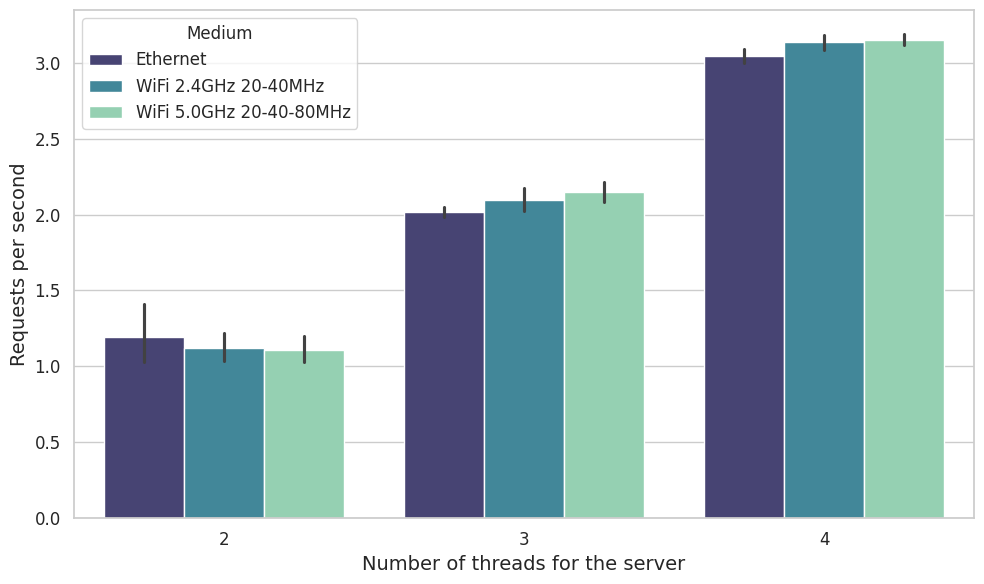

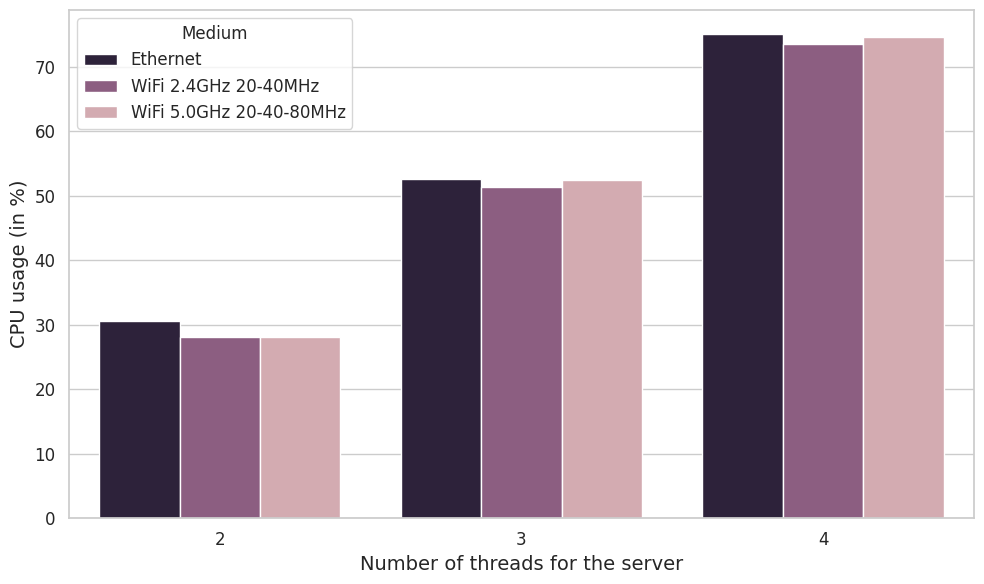

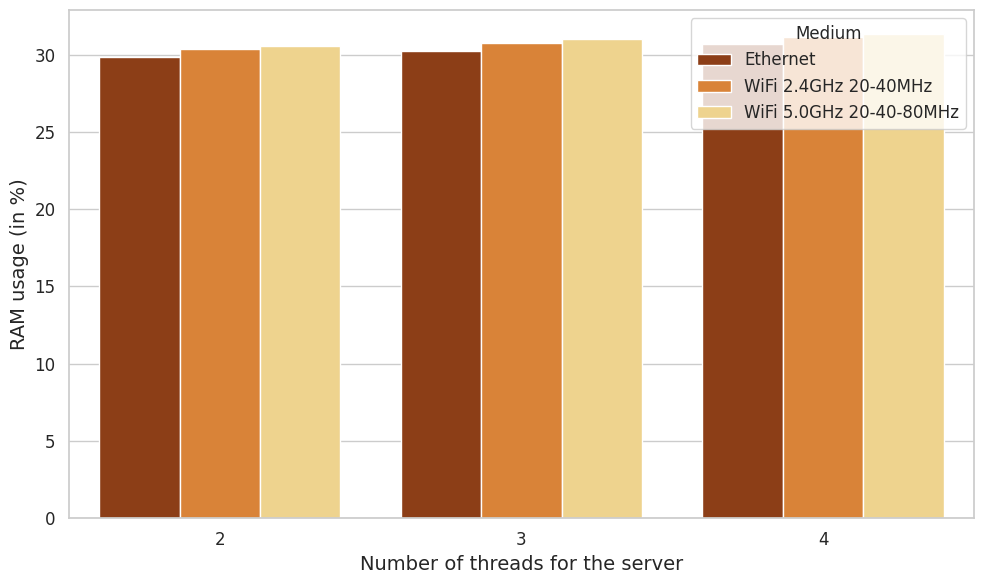

In [143]:
df_exec_time = pd.read_csv(exp_dir + "/request_per_sec.csv")
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

for imp in implementations:
    df_exec_time_imp = df_exec_time[df_exec_time["Implementation"] == imp]
    # df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
    df_cpu_usage_imp = df_cpu_usage[df_cpu_usage["Implementation"] == imp]
    df_ram_usage_imp = df_ram_usage[df_ram_usage["Implementation"] == imp]

    df_exec_time_imp_med = df_exec_time_imp.groupby(["Medium"])

    medium_group = df_exec_time_imp.groupby("Medium")

    hue_order = np.sort(df_exec_time_imp["Medium"].unique())
    
    # Barplot comparison request per second
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    sns.barplot(data=df_exec_time_imp, x='Server Threads', y='Requests/s', hue="Medium", hue_order=hue_order, palette=sns.color_palette('mako')[1::2])

    plt.xlabel("Number of threads for the server")
    plt.ylabel("Requests per second")
    plt.ylim(bottom=0)
    plt.tight_layout()

    plt.savefig(graphs_exec_time_dir + "/barplot_evolution_threads_req_per_sec" + experiment_name.replace(' ', '_') + "_" + imp + "_overall" + ".pdf")
    plt.show()


    # CPU usage
    df_cpu_usage_imp = df_cpu_usage_imp[df_cpu_usage_imp["Has Workload"] == True]
    df_cpu_thread_iter = df_cpu_usage_imp[["Server Threads", "Iteration", "Medium", "Usage"]]
    df_cpu_thread_iter = df_cpu_thread_iter.groupby(["Server Threads", "Iteration", "Medium"]).mean()
    df_cpu_thread_iter = df_cpu_thread_iter.reset_index()
    df_cpu_thread_iter = df_cpu_thread_iter.groupby(["Server Threads", "Medium"]).mean()
    df_cpu_thread_iter = df_cpu_thread_iter.reset_index()
    # display(df_cpu_thread_iter)

    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    sns.barplot(data=df_cpu_thread_iter, x='Server Threads', y='Usage', hue="Medium", hue_order=hue_order, palette=sns.cubehelix_palette()[::-2])

    plt.xlabel("Number of threads for the server")
    plt.ylabel("CPU usage (in %)")
    plt.ylim(bottom=0)
    plt.tight_layout()

    plt.savefig(graphs_cpu_usage_dir + "/barplot_evolution_threads_cpu_usage" + experiment_name.replace(' ', '_') + "_" + imp + "_overall" + ".pdf")
    plt.show()

    # RAM usage
    df_ram_usage_imp = df_ram_usage_imp[df_ram_usage_imp["Has Workload"] == True]
    df_ram_thread_iter = df_ram_usage_imp[["Server Threads", "Iteration", "Medium", "Usage"]]
    df_ram_thread_iter = df_ram_thread_iter.groupby(["Server Threads", "Iteration", "Medium"]).mean()
    df_ram_thread_iter = df_ram_thread_iter.reset_index()
    df_ram_thread_iter = df_ram_thread_iter.groupby(["Server Threads", "Medium"]).mean()
    df_ram_thread_iter = df_ram_thread_iter.reset_index()
    # display(df_ram_thread_iter)

    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    sns.barplot(data=df_ram_thread_iter, x='Server Threads', y='Usage', hue="Medium", hue_order=hue_order, palette=sns.color_palette("YlOrBr")[::-2])

    plt.xlabel("Number of threads for the server")
    plt.ylabel("RAM usage (in %)")
    plt.ylim(bottom=0)
    plt.tight_layout()

    plt.savefig(graphs_ram_usage_dir + "/barplot_evolution_threads_ram_usage" + experiment_name.replace(' ', '_') + "_" + imp + "_overall" + ".pdf")
    plt.show()